# Описание проекта 

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

**Цель —** Предсказать вероятность покупки в течение 90 дней

**Задачи:**
- Изучить данные
- Разработать полезные признаки
- Создать модель для классификации пользователей
- Улучшить модель и максимизировать метрику roc_auc
- Выполнить тестирование

**Данные**

*apparel-purchases* — история покупок

- `client_id` — идентификатор пользователя
- `quantity` — количество товаров в заказе
- `price` — цена товара
- `category_ids` — вложенные категории, к которым относится товар
- `date` — дата покупки
- `message_id` — идентификатор сообщения из рассылки

*apparel-messages* — история рекламных рассылок

- `bulk_campaign_id` — идентификатор рекламной кампании
- `client_id` — идентификатор пользователя
- `message_id` — идентификатор сообщений
- `event` — тип действия
- `channel` — канал рассылки
- `date` — дата действия
- `created_at` — точное время создания сообщения

*apparel-target_binary* — совершит ли клиент покупку в течение следующих 90 дней

- `client_id` — идентификатор пользователя
- `target` — целевой признак

# Импорт библиотек, определение констант

In [1]:
# Стандартные библиотеки
#from collections import defaultdict
import ast
import os
import warnings

# Сторонние библиотеки
from catboost import CatBoostClassifier
from catboost import Pool

from collections import defaultdict

from datetime import datetime

from imblearn.metrics import specificity_score

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks

from IPython.display import display, HTML

from itertools import combinations

import joblib

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
#from matplotlib.ticker import MaxNLocator
import matplotlib.colors as mcolors

import missingno as msno

import numpy as np
import pandas as pd

from phik.report import plot_correlation_matrix

#import plotly.express as px
#import plotly.graph_objects as go

#import scipy.stats as st

import seaborn as sns

import shap

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    classification_report,
    confusion_matrix,
    make_scorer,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    f1_score    
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    train_test_split,
)
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sys

from textwrap import wrap
from typing import List, Optional

# Глобальные настройки
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None

# Игнорирование предупреждений
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.metrics import roc_curve

In [2]:
# константа RANDOM_STATE
RANDOM_STATE = 42

# константа TEST_SIZE
TEST_SIZE = 0.25

# пороговый уровень для стат-теста
#ALFA = 0.05

# Защита от деления на ноль
#EPSILON = 1e-6

# Используемые в проекте основные собственные функции

In [3]:
def extended_describe(df, name="DataFrame"):
    """
    Возвращает расширенное описание датафрейма в виде HTML-таблицы.

    Добавляет полезные метрики к стандартному описанию:
    - mismatch%: отклонение среднего (mean) от медианы (50%) в процентах
    - rel_std%: относительное стандартное отклонение в процентах (std / mean * 100)
    - cat_top_ratio%: доля самого частого значения в категориальных столбцах (freq / count * 100)

    Параметры:
    ----------
    df : pd.DataFrame
        Входной датафрейм для анализа.
    name : str, optional (default="DataFrame")
        Название датафрейма, отображается в заголовке вывода.

    Возвращает:
    -----------
    None
        Результат выводится в виде HTML-таблицы в интерфейсе (например, Jupyter Notebook).

    Пример использования:
    ---------------------
    >>> extended_describe(messages_df, name="messages_df")

    Числовое описание данных: messages_df
    +--------------+--------+--------+----------+-------------+----------------+----------------+
    |              | count  | unique |   mean   |     std     |   mismatch%    |   rel_std%     |
    +--------------+--------+--------+----------+-------------+----------------+----------------+
    | column_1     | 100.00 | NaN    |  50.23   |   10.45     |     0.46       |     20.81      |
    | category_col | 100.00 | 5.00   |   NaN    |    NaN      |     NaN        |     NaN        |
    +--------------+--------+--------+----------+-------------+----------------+----------------+

    Примечание:
    ------------
    Функция работает как с числовыми, так и с категориальными столбцами.
    Требует библиотеки pandas и IPython для отображения HTML.
    """

    # Получаем стандартное описание
    desc = df.describe(include='all')

    # Создаем копию, чтобы не модифицировать исходный describe
    pivot = desc.copy()

    # Добавляем mismatch% для числовых столбцов
    if 'mean' in pivot.index and '50%' in pivot.index:
        with pd.option_context('mode.use_inf_as_na', True):
            mismatch = ((pivot.loc['mean'] - pivot.loc['50%']) / pivot.loc['50%']) * 100
        mismatch.name = 'mismatch%'
        pivot = pd.concat([pivot, mismatch.to_frame().T])

    # Добавляем rel_std% для числовых столбцов
    if 'std' in pivot.index and 'mean' in pivot.index:
        with pd.option_context('mode.use_inf_as_na', True):
            rel_std = (pivot.loc['std'] / pivot.loc['mean']) * 100
        rel_std.name = 'rel_std%'
        pivot = pd.concat([pivot, rel_std.to_frame().T])

    # Добавляем cat_top_ratio% для категориальных столбцов
    if 'freq' in pivot.index and 'count' in pivot.index:
        with pd.option_context('mode.use_inf_as_na', True):
            cat_ratio = (pivot.loc['freq'] / pivot.loc['count']) * 100
        cat_ratio.name = 'cat_top_ratio%'
        pivot = pd.concat([pivot, cat_ratio.to_frame().T])

    # Округляем и транспонируем
    styled_table = pivot.round(2).T

    # Выводим в HTML
    print(f'\033[1mЧисловое описание данных: {name}\033[0m')
    display(HTML(styled_table.to_html(index=True)))

In [4]:
def plot_distribution_with_boxplot(df, features, target_col, category_order=None, bins=None,
                                 auto_bins=False, log_scale=False, minor_category_threshold=0.05,
                                 show_category_types=True):
    """Визуализирует распределения признаков с разделением по категориям целевой переменной.

    Автоматически преобразует числовые целевые переменные в категориальные,
    если они содержат ≤10 уникальных значений. Это преобразование не влияет на исходный датафрейм.

    Создает сетку графиков:
    - Для каждого признака отображаются 2 строки:
      1) Гистограмма с наложениями категорий (stacked) и KDE-кривой (с возможностью
         использования второй оси Y для редких категорий)
      2) Горизонтальный boxplot, где категории размещены по оси y
    - Цвета категорий согласованы между графиками и указаны в легенде
    - Для дисбалансированных данных редкие категории отображаются на отдельной оси Y
    - Графики автоматически размещаются в сетке (до 4 столбцов)
    - Убираются пустые оси для незаполненных ячеек сетки
    - Настройки: сетка, поворот меток, оптимизация макета

    Args:
        df (pd.DataFrame): DataFrame с данными
        features (List[Tuple[str, str]]): Список кортежей (колонка, человекочитаемая метка)
        target_col (str): Название целевой колонки. Если тип числовой и содержит ≤10 уникальных значений,
                          будет преобразована в категориальную внутри функции
        category_order (Optional[List[str]]): Список категорий в нужном порядке. Если None,
            используется отсортированный порядок (по умолчанию None)
        bins (Optional[int]): Количество корзин для гистограмм. Если None и auto_bins=False,
            используется значение по умолчанию в sns.histplot (по умолчанию None)
        auto_bins (bool): Если True, для каждого признака количество корзин будет определяться
            автоматически с помощью правила Фридмана-Дьякониса (по умолчанию False)
        log_scale (bool or str or list): Если True, логарифмический масштаб применяется ко всем признакам.
            Если 'auto', применяется только к признакам с большим разбросом значений.
            Если список, указывает к каким именно признакам применить (по именам колонок).
            (по умолчанию False)
        minor_category_threshold (float): Порог для определения редких категорий (доля от общего числа записей).
            Категории с долей меньше этого значения будут отображаться на отдельной оси Y.
            (по умолчанию 0.05)
        show_category_types (bool): Если True, в легенде будет указано, является ли категория
            основной или редкой (по умолчанию True)

    Notes:
        - features ожидает кортежи (колонка, человекочитаемая метка)
        - Для числовых целевых переменных с ≤10 уникальными значениями автоматически создаётся
          категориальная переменная (без изменения исходного DataFrame)

    Examples:
        >>> # Пример 1: Базовое использование с автоматическим определением категорий
        >>> features = [('age', 'Возраст'), ('income', 'Доход')]
        >>> plot_distribution_with_boxplot(df, features, 'gender')

        >>> # Пример 2: Логарифмический масштаб для всех признаков
        >>> plot_distribution_with_boxplot(df, features, 'gender', log_scale=True)

        >>> # Пример 3: Логарифмический масштаб только для определенных признаков
        >>> plot_distribution_with_boxplot(df, features, 'gender', log_scale=['income'])

        >>> # Пример 4: Автоматическое определение признаков для логарифмического масштаба
        >>> plot_distribution_with_boxplot(df, features, 'gender', log_scale='auto')

        >>> # Пример 5: Настройка отображения редких категорий (менее 10% записей)
        >>> plot_distribution_with_boxplot(df, features, 'rare_category', minor_category_threshold=0.1)

        >>> # Пример 6: Отключение пометок категорий в легенде
        >>> plot_distribution_with_boxplot(df, features, 'category', show_category_types=False)

        >>> # Пример 7: Комбинированное использование параметров
        >>> plot_distribution_with_boxplot(
        ...     df,
        ...     features=[('age', 'Возраст'), ('income', 'Доход')],
        ...     target_col='membership_type',
        ...     minor_category_threshold=0.1,
        ...     log_scale='auto',
        ...     auto_bins=True
        ... )
    """
    # Проверка и преобразование целевой переменной
    target_series = df[target_col]
    unique_count = target_series.nunique()
    is_numeric = pd.api.types.is_numeric_dtype(target_series)

    # Создаем временную целевую переменную
    if is_numeric and unique_count <= 10:
        transformed_target = target_series.astype(str)
        print(f"Целевой признак '{target_col}' преобразован в категориальный. "
              f"Уникальные значения: {sorted(transformed_target.unique())}")
    else:
        transformed_target = target_series.copy()

    # Получаем категории в нужном порядке (удалив строки с пропусками, если они имеются)
    if category_order is None:
        if is_numeric and unique_count <= 10:
            numeric_categories = sorted(df[target_col].dropna().unique())
            categories = [str(val) for val in numeric_categories]
        else:
            categories = sorted(transformed_target.dropna().unique())
    else:
        categories = category_order

    # Определяем основные и второстепенные категории
    category_counts = transformed_target.value_counts(normalize=True)
    major_categories = category_counts[category_counts >= minor_category_threshold].index.tolist()
    minor_categories = category_counts[category_counts < minor_category_threshold].index.tolist()

    # Подготовка цветовой палитры и элементов легенды
    palette = plt.cm.Paired(np.linspace(0, 1, len(categories)))
    category_to_color = {cat: color for cat, color in zip(categories, palette)}

    # Формируем элементы легенды с указанием типа категории (если нужно)
    if show_category_types:
        legend_elements = [
            Patch(facecolor=color,
                 label=f"{cat} (Основная)" if cat in major_categories else f"{cat} (Малая)",
                 alpha=0.6)
            for cat, color in category_to_color.items()
        ]
    else:
        legend_elements = [
            Patch(facecolor=color, label=str(cat), alpha=0.6)
            for cat, color in category_to_color.items()
        ]

    # Настройка сетки графиков
    n_features = len(features)
    ncols = min(4, n_features)
    rows_per_feature = 2
    nrows = (n_features + ncols - 1) // ncols * rows_per_feature

    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(14, 3 * nrows),
        squeeze=False
    )

    # Функция для вычисления оптимального числа корзин по правилу Фридмана-Дьякониса
    def calculate_fd_bins(data):
        iqr = np.percentile(data, 75) - np.percentile(data, 25)
        bin_width = 2 * iqr / (len(data) ** (1/3))
        if bin_width == 0:
            return 30
        return int(np.ceil((data.max() - data.min()) / bin_width))

    # Определяем, к каким признакам применять логарифмический масштаб
    if log_scale == 'auto':
        log_features = []
        for feature_col, _ in features:
            if pd.api.types.is_numeric_dtype(df[feature_col]):
                data = df[feature_col].dropna()
                if (data.max() / data.min() > 100) and (data.min() > 0):
                    log_features.append(feature_col)
        print(f"Автоматически применен логарифмический масштаб к признакам: {log_features}")
    elif log_scale is True:
        log_features = [feature_col for feature_col, _ in features
                       if pd.api.types.is_numeric_dtype(df[feature_col])]
    elif isinstance(log_scale, list):
        log_features = log_scale
    else:
        log_features = []

    # Цикл по признакам для создания графиков
    for i, (feature_col, feature_label) in enumerate(features):
        col = i % ncols
        row_base = (i // ncols) * rows_per_feature

        # Определение количества корзин для текущего признака
        current_bins = bins
        if auto_bins and pd.api.types.is_numeric_dtype(df[feature_col]):
            current_bins = calculate_fd_bins(df[feature_col].dropna())
            print(f"Для признака '{feature_col}' автоматически выбрано {current_bins} корзин")

        use_log_scale = feature_col in log_features

        # Гистограмма с двумя осями Y
        ax_hist = axes[row_base, col]
        ax_hist_right = ax_hist.twinx()

        # Рисуем основные категории на левой оси
        if major_categories:
            sns.histplot(
                data=df[df[target_col].isin(major_categories)],
                x=feature_col,
                hue=transformed_target,
                kde=True,
                multiple='stack',
                palette=category_to_color,
                ax=ax_hist,
                legend=False,
                bins=current_bins,
                log_scale=use_log_scale
            )

        # Рисуем второстепенные категории на правой оси
        if minor_categories:
            sns.histplot(
                data=df[df[target_col].isin(minor_categories)],
                x=feature_col,
                hue=transformed_target,
                kde=True,
                multiple='stack',
                palette=category_to_color,
                ax=ax_hist_right,
                legend=False,
                bins=current_bins,
                log_scale=use_log_scale
            )

            # Настраиваем правую ось
            ax_hist_right.spines['right'].set_color('gray')
            ax_hist_right.tick_params(axis='y', colors='gray')
            ax_hist_right.yaxis.label.set_color('gray')
            ax_hist_right.set_ylabel(
                f'Малые категории (<{minor_category_threshold*100:.0f}%)',
                color='gray',
                fontsize=8
            )

        # Настройка гистограммы
        ax_hist.set_title(f'Распределение {feature_label}', fontsize=10)
        ax_hist.set_xlabel('')

        if use_log_scale:
            ax_hist.set_xscale('log')
            ax_hist.set_title(f'Распределение {feature_label} (log scale)', fontsize=10)

        if i == 0:
            ax_hist.set_ylabel(
                f'Основные категории (≥{minor_category_threshold*100:.0f}%)',
                fontsize=9
            )
        else:
            ax_hist.set_ylabel('')

        if i == 0:
            ax_hist.legend(
                handles=legend_elements,
                title=target_col,
                fontsize=8,
                title_fontsize=8,
                loc='upper right'
            )

        ax_hist.grid(axis='y', alpha=0.3)
        ax_hist.tick_params(axis='x', labelrotation=0)

        # Boxplot
        ax_box = axes[row_base + 1, col]
        sns.boxplot(
            data=df,
            x=feature_col,
            y=transformed_target,
            order=categories,
            palette=category_to_color,
            orient='h',
            ax=ax_box,
            width=0.6
        )

        if use_log_scale:
            ax_box.set_xscale('log')

        # Настройка boxplot
        if i == 0:
            ax_box.tick_params(axis='y', labelrotation=45, labelsize=8)
        else:
            ax_box.set_yticklabels([])

        ax_box.set_xlabel(feature_label, fontsize=9)
        ax_box.grid(axis='y', alpha=0.3)
        ax_box.tick_params(axis='x', labelrotation=0)
        ax_box.set_ylabel('')

    # Скрытие пустых осей
    for row in range(nrows):
        for col in range(ncols):
            current_idx = (row // rows_per_feature) * ncols + col
            if current_idx >= n_features:
                axes[row, col].set_visible(False)

    plt.tight_layout(h_pad=1.5, w_pad=1.5)
    plt.show()

In [5]:
def plot_categorical_distributions(
    df: pd.DataFrame,
    target_col: str,
    categorical_features: Optional[List[str]] = None,
    log_scale: bool = False,
    ncols: int = 5,
    max_categories: int = 10,
    rotate_labels: int = 45,
    label_fontsize: int = 10,
    wrap_labels: bool = True,
    label_max_length: int = 15,
    figsize_width: float = 5.0,
    figsize_height: float = 3.5,
    annotation_pos: str = 'top'  # 'top' или 'above_title'
) -> None:
    """
    Визуализирует распределение категориальных признаков относительно бинарного целевого признака.
    Для каждого категориального признака строит два графика:
    1. Абсолютные значения (countplot)
    2. Относительные доли (stacked barplot)

    Parameters
    ----------
    df : pd.DataFrame
        Входной DataFrame с данными для визуализации.
    target_col : str
        Название целевого бинарного признака (должен содержать ровно 2 уникальных значения).
    categorical_features : List[str], optional
        Список категориальных признаков для анализа. Если None, будут использованы все столбцы
        с типами 'object' и 'category', исключая целевой признак.
    log_scale : bool, default=False
        Если True, ось Y на графиках абсолютных значений будет в логарифмическом масштабе.
    ncols : int, default=5
        Количество столбцов в сетке графиков.
    max_categories : int, default=10
        Максимальное количество категорий для отображения на одном графике.
        Если в признаке больше категорий, отображаются только top-N по частоте.
    rotate_labels : int, default=45
        Угол поворота подписей категорий на оси X (в градусах).
    label_fontsize : int, default=10
        Размер шрифта для подписей категорий на оси X.
    wrap_labels : bool, default=True
        Если True, длинные метки категорий будут переноситься на несколько строк.
    label_max_length : int, default=15
        Максимальная длина подписи категории до переноса на новую строку (если wrap_labels=True).
    figsize_width : float, default=5.0
        Ширина одного подграфика в дюймах.
    figsize_height : float, default=3.5
        Высота одного подграфика в дюймах.
    annotation_pos : str, default='top'
        Положение аннотации о количестве категорий:
        - 'top' - в правом верхнем углу графика
        - 'above_title' - над заголовком графика

    Raises
    ------
    ValueError
        Если целевой столбец отсутствует в DataFrame или не является бинарным.
    KeyError
        Если указанные категориальные признаки отсутствуют в DataFrame.
    ValueError
        Если не найдено категориальных признаков для визуализации.
    """
    # Проверка наличия целевого столбца
    if target_col not in df.columns:
        raise ValueError(f"Целевой столбец '{target_col}' отсутствует в датафрейме.")

    # Проверка, что целевой столбец бинарный
    unique_values = df[target_col].dropna().unique()
    if len(unique_values) != 2:
        raise ValueError(f"Целевой столбец '{target_col}' должен быть бинарным (иметь ровно 2 уникальных значения).")

    # Автоматическое определение категориальных признаков, если не переданы
    if categorical_features is None:
        categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
        categorical_features = [col for col in categorical_features if col != target_col]
    else:
        missing_cols = [col for col in categorical_features if col not in df.columns]
        if missing_cols:
            raise KeyError(f"Следующие категориальные признаки отсутствуют в датафрейме: {missing_cols}")

    if not categorical_features:
        raise ValueError("Не найдено категориальных признаков для отображения.")

    def process_label(label):
        if not isinstance(label, str):
            return str(label)
        if wrap_labels and len(label) > label_max_length:
            return '\n'.join(wrap(label, label_max_length))
        return label

    n_features = len(categorical_features)
    nrows = n_features * 2
    ncols = min(ncols, n_features)

    fig, axs = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(ncols * figsize_width, nrows * figsize_height),
        squeeze=False,
        constrained_layout=True
    )
    fig.suptitle('Распределение категориальных признаков (абсолютные значения и доли)',
                fontsize=16, y=1.02)

    for i, feature in enumerate(categorical_features):
        col = i % ncols
        row_abs = (i // ncols) * 2
        row_rel = row_abs + 1

        value_counts = df[feature].value_counts()
        if len(value_counts) > max_categories:
            top_categories = value_counts.nlargest(max_categories).index
            df_plot = df[df[feature].isin(top_categories)].copy()
            categories_dropped = len(value_counts) - max_categories
        else:
            df_plot = df.copy()
            categories_dropped = 0

        categories = df_plot[feature].value_counts().index
        processed_labels = [process_label(str(cat)) for cat in categories]

        # График абсолютных значений
        sns.countplot(
            data=df_plot,
            x=feature,
            hue=target_col,
            ax=axs[row_abs, col],
            order=categories
        )

        axs[row_abs, col].set_title(f'Абсолютные значения: {feature}', pad=10)
        axs[row_abs, col].set_xticks(range(len(categories)))
        axs[row_abs, col].set_xticklabels(
            processed_labels,
            rotation=rotate_labels,
            ha='right' if rotate_labels > 0 else 'center',
            fontsize=label_fontsize
        )
        axs[row_abs, col].legend(title=target_col, loc='upper right')
        axs[row_abs, col].grid(axis='y', linestyle='--', alpha=0.7)

        if log_scale:
            axs[row_abs, col].set_yscale('log')
            axs[row_abs, col].set_ylabel('Количество (log scale)')
        else:
            axs[row_abs, col].set_ylabel('Количество')

        # Аннотация для абсолютных значений
        if categories_dropped > 0:
            if annotation_pos == 'top':
                axs[row_abs, col].annotate(
                    f'Top {max_categories}/{len(value_counts)}',
                    xy=(0.8, 0.95),
                    xycoords='axes fraction',
                    ha='right',
                    va='top',
                    fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7)
                )
            else:
                axs[row_abs, col].annotate(
                    f'Top {max_categories} из {len(value_counts)} категорий',
                    xy=(0.5, 1.13),
                    xycoords='axes fraction',
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7)
                )

        # График долей
        grouped = (
            df_plot
            .groupby([feature, target_col])
            .size()
            .unstack(fill_value=0)
            .apply(lambda x: x / x.sum(), axis=1)
            .loc[categories]
        )

        grouped.plot(
            kind='bar',
            stacked=True,
            ax=axs[row_rel, col],
            colormap='viridis'
        )

        axs[row_rel, col].set_title(f'Доли: {feature}', pad=10)
        axs[row_rel, col].set_xticks(range(len(categories)))
        axs[row_rel, col].set_xticklabels(
            processed_labels,
            rotation=rotate_labels,
            ha='right' if rotate_labels > 0 else 'center',
            fontsize=label_fontsize
        )
        axs[row_rel, col].set_ylabel('Доля')
        axs[row_rel, col].legend(title=target_col, loc='upper right')
        axs[row_rel, col].grid(axis='y', linestyle='--', alpha=0.7)

        # Аннотация для долей
        if categories_dropped > 0:
            if annotation_pos == 'top':
                axs[row_rel, col].annotate(
                    f'Top {max_categories}/{len(value_counts)}',
                    xy=(0.8, 0.95),
                    xycoords='axes fraction',
                    ha='right',
                    va='top',
                    fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7)
                )
            else:
                axs[row_rel, col].annotate(
                    f'Top {max_categories} из {len(value_counts)} категорий',
                    xy=(0.5, 1.13),
                    xycoords='axes fraction',
                    ha='center',
                    va='bottom',
                    fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.7)
                )

    # Удаление пустых подграфиков
    for row in range(nrows):
        for col in range(ncols):
            feature_index = (row // 2) * ncols + col
            if feature_index >= len(categorical_features):
                fig.delaxes(axs[row, col])

    plt.show()

In [6]:
def phik_correlation_matrix(df, target_col=None, threshold=0.9, output_interval_cols=True, interval_cols=None, cell_size=1.1):
    """Строит матрицу корреляции Фи-К (включая целевую переменную) и возвращает корреляции с целевой.

    Args:
        df (pd.DataFrame): DataFrame с данными для анализа
        target_col (str): Название столбца с целевой переменной
        threshold (float): Порог для выделения значимых корреляций (0.9 по умолчанию)
        output_interval_cols (bool): Возвращать ли список числовых непрерывных столбцов
        interval_cols (list): Список числовых непрерывных столбцов (если None, будет определен автоматически)
        cell_size (float): Дюйм на ячейку

    Returns:
        tuple: (correlated_pairs, interval_cols, phi_k_with_target) где:
            - correlated_pairs: DataFrame с парами коррелирующих признаков
            - interval_cols: Список числовых непрерывных столбцов (если output_interval_cols=True)
            - phi_k_with_target: Series с корреляциями признаков с целевой переменной

    Example:
        >>> import pandas as pd
        >>> import numpy as np
        >>> from phik import phik_matrix
        >>>
        >>> # Создаем тестовые данные
        >>> data = {
        ...     'price': [100, 200, 150, 300],  # Целевая переменная
        ...     'mileage': [50, 100, 75, 120],
        ...     'brand': ['A', 'B', 'A', 'C'],
        ...     'engine': [1.6, 2.0, 1.8, 2.5]
        ... }
        >>> df = pd.DataFrame(data)
        >>>
        >>> # Анализ корреляций с ручным заданием числовых столбцов
        >>> result = phik_correlation_matrix(df, target_col='price', threshold=0.3, interval_cols=['mileage', 'engine'])
        >>>
        >>> # Получаем результаты:
        >>> correlated_pairs = result[0]  # Пары коррелирующих признаков
        >>> interval_cols = result[1]     # Числовые непрерывные столбцы
        >>> phi_k_with_target = result[2] # Корреляции с ценой
        >>>
        >>> print("Корреляции с ценой:")
        >>> print(phi_k_with_target.sort_values(ascending=False))
    """

    # Определение числовых непрерывных столбцов (если не заданы вручную)
    if interval_cols is None:
        interval_cols = [
            col for col in df.select_dtypes(include=["number"]).columns
            if (df[col].nunique() > 50) or ((df[col] % 1 != 0).any())
        ]

    # Расчет полной матрицы корреляции (включая целевую переменную)
    phik_matrix = df.phik_matrix(interval_cols=interval_cols).round(2)

    # Получение корреляций с целевой переменной
    phi_k_with_target = None
    if target_col is not None and target_col in phik_matrix.columns:
        phi_k_with_target = phik_matrix[target_col].copy()
        # Удаляем корреляцию целевой с собой (всегда 1.0)
        phi_k_with_target.drop(target_col, inplace=True, errors='ignore')

    # Динамическое определение размера фигуры для подстройки размера ячеек
    num_cols = len(phik_matrix.columns)
    num_rows = len(phik_matrix.index)
    cell_size = cell_size  # Дюймов на ячейку
    figsize = (num_cols * cell_size, num_rows * cell_size)

    # Визуализация матрицы
    plot_correlation_matrix(
        phik_matrix.values,
        x_labels=phik_matrix.columns,
        y_labels=phik_matrix.index,
        vmin=0,
        vmax=1,
        color_map="Greens",
        title=r"Матрица корреляции $\phi_K$",
        fontsize_factor=1,
        figsize=figsize
    )
    plt.tight_layout()
    plt.show()

    # Фильтрация значимых корреляций (исключая целевую из пар)
    close_to_one = phik_matrix[phik_matrix >= threshold]
    close_to_one = close_to_one.where(
        np.triu(np.ones(close_to_one.shape), k=1).astype(bool)
    )

    # Удаление строк/столбцов с целевой переменной для анализа пар признаков
    if target_col is not None:
        close_to_one.drop(target_col, axis=0, inplace=True, errors='ignore')
        close_to_one.drop(target_col, axis=1, inplace=True, errors='ignore')

    # Преобразование в длинный формат
    close_to_one_stacked = close_to_one.stack().reset_index()
    close_to_one_stacked.columns = ["признак_1", "признак_2", "корреляция"]
    close_to_one_stacked = close_to_one_stacked.dropna(subset=["корреляция"])

    # Классификация корреляций
    def classify_correlation(corr):
        if corr >= 0.9: return "Очень высокая"
        elif corr >= 0.7: return "Высокая"
        elif corr >= 0.5: return "Заметная"
        elif corr >= 0.3: return "Умеренная"
        elif corr >= 0.1: return "Слабая"
        return "-"

    close_to_one_stacked["класс_корреляции"] = close_to_one_stacked["корреляция"].apply(
        classify_correlation
    )
    close_to_one_sorted = close_to_one_stacked.sort_values(
        by="корреляция", ascending=False
    ).reset_index(drop=True)

    if len(close_to_one_sorted) == 0 and threshold >= 0.9:
        print("\033[1mМультиколлинеарность между парами входных признаков отсутствует\033[0m")

    # Формирование результата
    result = [close_to_one_sorted]
    if output_interval_cols:
        result.append(interval_cols)
    if target_col is not None:
        result.append(phi_k_with_target)
    elif output_interval_cols:
        result.append(None)

    return tuple(result)

In [7]:
def plot_violin_combinations(
    df: pd.DataFrame,
    x_column: str = 'Age',
    y_features: list = None,
    hue_features: list = None,
    max_classes: int = 10,
    figsize_per_plot: tuple = (5, 5),
    numeric_to_categorical: bool = True,
    log_scale_x: bool = False
):
    """
    Строит комбинации violinplot для заданных/автоматически определённых категориальных признаков.

    Args:
    -----------
        df : pd.DataFrame
            Входной датафрейм с данными.
        x_column : str, optional (default='Age')
            Имя непрерывного числового признака для оси X (например, возраст).
        y_features : list, optional (default=None)
            Список категориальных признаков для оси Y.
            Если None, определяются автоматически:
            - Объектные столбцы с 2-10 уникальными значениями.
            Если numeric_to_categorical=True, числовые столбцы будут преобразованы в категориальные.
        hue_features : list, optional (default=None)
            Список бинарных категориальных признаков для разделения (hue).
            Если None, определяются автоматически:
            - Объектные/числовые столбцы с ровно 2 уникальными значениями.
        max_classes : int, optional (default=10)
            Максимальное количество уникальных значений для признаков на оси Y (по умолчанию до 10).
        figsize_per_plot : tuple, optional (default=(5, 5))
            Размер каждого подграфика в дюймах (width, height).
        numeric_to_categorical : bool, optional (default=True)
            Если True, числовые признаки в y_features будут преобразованы в категориальные.
        log_scale_x : bool, optional (default=False)
            Если True, ось X будет в логарифмическом масштабе.

    Returns:
    --------
    None
        Выводит графики и/или сообщения об ошибках.

    Example:
    --------
        >>> import pandas as pd
        >>> import seaborn as sns
        >>> import matplotlib.pyplot as plt
        >>>
        >>> # Загрузка тестовых данных
        >>> df = sns.load_dataset('titanic')
        >>>
        >>> # Пример использования функции
        >>> plot_violin_combinations(
        ...     df=df,
        ...     x_column='age',
        ...     y_features=['class', 'embarked'],
        ...     hue_features=['sex', 'alive'],
        ...     figsize_per_plot=(6, 4),
        ...     log_scale_x=False
        ... )
        >>>
        >>> # Автоматический режим с логарифмической шкалой
        >>> plot_violin_combinations(
        ...     df=df,
        ...     x_column='fare',
        ...     log_scale_x=True
        ... )
    """

    # --- Шаг 1: Проверка корректности входных данных ---
    if x_column not in df.columns:
        raise ValueError(f"Столбец '{x_column}' не найден в датафрейме.")
    if not pd.api.types.is_numeric_dtype(df[x_column]):
        raise ValueError(f"Столбец '{x_column}' должен быть числовым.")

    # Создаем копию датафрейма для временных преобразований
    temp_df = df.copy()

    # --- Шаг 2: Автоматическое определение признаков ---
    if y_features is None:
        y_features = []
        for col in temp_df.select_dtypes(include=['object', 'category']).columns:
            if 2 <= temp_df[col].nunique(dropna=False) <= max_classes:
                y_features.append(col)

        if numeric_to_categorical:
            for col in temp_df.select_dtypes(include='number').columns:
                if col != x_column and 2 <= temp_df[col].nunique(dropna=False) <= max_classes:
                    # Сортируем числовые значения перед конвертацией в строки
                    unique_values = sorted(temp_df[col].dropna().unique())
                    temp_df[col] = temp_df[col].astype(str)
                    # Устанавливаем категориальный порядок для сортировки на графике
                    temp_df[col] = pd.Categorical(temp_df[col], categories=[str(v) for v in unique_values])
                    y_features.append(col)

        y_features = list(set(y_features))

    elif numeric_to_categorical:
        for col in y_features:
            if pd.api.types.is_numeric_dtype(temp_df[col]) and col != x_column:
                # Сортируем числовые значения перед конвертацией в строки
                unique_values = sorted(temp_df[col].dropna().unique())
                temp_df[col] = temp_df[col].astype(str)
                # Устанавливаем категориальный порядок для сортировки на графике
                temp_df[col] = pd.Categorical(temp_df[col], categories=[str(v) for v in unique_values])

    if hue_features is None:
        hue_features = []
        for col in temp_df.select_dtypes(include=['object', 'category']).columns:
            if temp_df[col].nunique(dropna=False) == 2:
                hue_features.append(col)
        for col in temp_df.select_dtypes(include='number').columns:
            if temp_df[col].nunique(dropna=False) == 2:
                hue_features.append(col)
        hue_features = list(set(hue_features))

    # --- Шаг 3: Проверка наличия подходящих признаков ---
    if not y_features:
        print("Не найдено подходящих категориальных признаков для оси Y (2-10 уникальных значений).")
        return
    if not hue_features:
        print("Не найдено бинарных признаков для разделения (hue).")
        return

    # --- Шаг 4: Генерация уникальных комбинаций (y, hue) ---
    combinations = []
    seen = set()
    for y_col in y_features:
        for hue_col in hue_features:
            if y_col != hue_col:
                key = tuple(sorted([y_col, hue_col]))
                if key not in seen:
                    combinations.append((y_col, hue_col))
                    seen.add(key)

    if not combinations:
        print("Не удалось сгенерировать комбинации (y, hue). Проверьте входные данные.")
        return

    # --- Шаг 5: Расчёт сетки подграфиков ---
    total_plots = len(combinations)
    ncols = min(3, total_plots)
    nrows = (total_plots + ncols - 1) // ncols

    # --- Шаг 6: Создание фигуры и подграфиков ---
    fig_width = ncols * figsize_per_plot[0]
    fig_height = nrows * figsize_per_plot[1]
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
    axes = axes.flatten() if total_plots > 1 else [axes]

    # --- Шаг 7: Построение графиков ---
    for i, (y_col, hue_col) in enumerate(combinations):
        ax = axes[i]
        try:
            sns.violinplot(
                x=x_column,
                y=y_col,
                hue=hue_col,
                data=temp_df,
                split=True,
                palette='Set2',
                inner='quartile',
                ax=ax
            )

            # Применение логарифмического масштаба если нужно
            if log_scale_x:
                ax.set_xscale('log')
                ax.set_xlabel(f'{x_column} (log scale)')

            ax.set_title(f"{y_col} vs {hue_col}")
            ax.legend(title=hue_col, loc='upper right')
        except Exception as e:
            print(f"Ошибка при построении графика для {y_col} и {hue_col}: {str(e)}")
            ax.set_title(f"Ошибка: {y_col} vs {hue_col}")
            ax.text(0.5, 0.5, "Ошибка построения", ha='center', va='center')

    # --- Шаг 8: Удаление пустых подграфиков ---
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # --- Шаг 9: Финальная настройка и отображение ---
    plt.tight_layout()
    plt.show()

In [8]:
def vif(X, font_size=12):
    """Строит столбчатую диаграмму с коэффициентами инфляции дисперсии (VIF) для всех входных признаков.

    Args:
        X (pd.DataFrame): DataFrame с входными признаками для анализа.
        font_size (int): Размер шрифта для текстовых элементов графика (по умолчанию 12).

    Notes:
        - Коэффициент инфляции дисперсии (VIF) показывает степень мультиколлинеарности между признаками.
        - График отображается напрямую через matplotlib.

    Example:
        Пример использования функции:

        >>> import pandas as pd
        >>> from statsmodels.stats.outliers_influence import variance_inflation_factor
        >>> import statsmodels.api as sm
        >>>
        >>> # Создаем тестовый датафрейм
        >>> data = pd.DataFrame({
        ...     'feature1': [1, 2, 3, 4, 5],
        ...     'feature2': [2, 4, 6, 8, 10],  # Полностью коррелирует с feature1
        ...     'feature3': [3, 6, 9, 12, 15]   # Частично коррелирует
        ... })
        >>>
        >>> # Вызываем функцию для анализа VIF
        >>> vif(data)
        >>>
        >>> # В результате будет показан график с VIF для каждого признака
        >>> # (feature2 будет иметь очень высокий VIF из-за полной корреляции с feature1)
    """
    # Кодируем категориальные признаки
    X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

    # Добавляем константу для корректного расчета VIF
    X_with_const = sm.add_constant(X_encoded)

    # Вычисляем VIF для всех признаков, кроме константы (индексы начинаются с 1)
    vif = [variance_inflation_factor(X_with_const.values, i)
           for i in range(1, X_with_const.shape[1])]  # Исключаем константу (0-й столбец)

    # Построение графика с использованием исходных названий признаков (без константы)
    num_features = X_encoded.shape[1]
    fig_width = num_features * 1.2
    fig_height = 12

    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(x=X_encoded.columns, y=vif)

    # Настройки графика
    ax.set_ylabel('VIF', fontsize=font_size)
    ax.set_xlabel('Входные признаки', fontsize=font_size)
    plt.title('Коэффициент инфляции дисперсии для входных признаков (VIF)', fontsize=font_size)

    # Метки на осях
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

    # Добавляем значения на столбцы (опционально)
    # ax.bar_label(ax.containers[0], fmt='%.2f', padding=3, fontsize=font_size)

    plt.tight_layout()
    plt.show()

# Загрузка данных

In [9]:
# считываем данные из csv-файлов в датафреймы и сохраняем в переменные
messages = pd.read_csv('apparel-messages.csv')
purchases = pd.read_csv('apparel-purchases.csv')
target = pd.read_csv('apparel-target_binary.csv')

In [10]:
# сделаем копии датафреймов
messages_df = messages.copy()
purchases_df = purchases.copy()
target_df = target.copy()

In [11]:
# просматриваем по три последних строки в данных

# создаем словарь: ключ — название датафрейма, значение — сам датафрейм
dataframes = {
    'messages_df' : messages_df,
    'purchases_df' : purchases_df,
    'target_df' : target_df,
}

# выводим по три последних строки в каждом датафрейме
for name, df in dataframes.items():
    print(f'\033[1mДатафрейм {name}\033[0m')
    display(df.tail(3))
    print('')

Датафрейм messages_df


bulk_campaign_id            client_id  \
12739795             14641  1515915625545014677   
12739796             14624  1515915625477497874   
12739797             14641  1515915625477497874   

                                       message_id event channel        date  \
12739795  1515915625545014677-14641-65cb2434b25a1  open   email  2024-02-15   
12739796  1515915625477497874-14624-65c5e22fb401e  open   email  2024-02-15   
12739797  1515915625477497874-14641-65cb249172d68  open   email  2024-02-15   

                   created_at  
12739795  2024-02-15 23:52:40  
12739796  2024-02-15 23:58:40  
12739797  2024-02-15 23:58:40


Датафрейм purchases_df


client_id  quantity   price               category_ids  \
202205  1515915626010439406         1    99.0  ['4', '27', '233', '462']   
202206  1515915626010443527         1  1999.0  ['2', '18', '274', '446']   
202207  1515915626010443624         1   999.0   ['4', '28', '62', '656']   

              date                               message_id  
202205  2024-02-16  1515915625776605028-14662-65cf3abfe4f0d  
202206  2024-02-16  1515915625766077627-14668-65cf5246bd490  
202207  2024-02-16  1515915625488468007-14668-65cf5234b1295


Датафрейм target_df


client_id  target
49846  1515915626010439406       0
49847  1515915626010443527       0
49848  1515915626010443624       0

**Промежуточный вывод**

Все данные из описания присутствуют, загрузка прошла успешно. Данные готовы к предобработке.

# Предобработка данных

Проверим данные на наличие пропусков и дубликатов. Узнаем, корректный ли тип данных у каждого признака.

In [12]:
# выведем общую информацию о датафреймах
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    print(f'\033[1mОбщая информация для {name}:\033[0m')
    df.info()
    print('')

Общая информация для messages_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB

Общая информация для purchases_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), ob

In [13]:
# для явного определения количества пропусков в объемном датафрейме
messages_df.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

Пропусков в датафреймах нет

Теперь проанализируем дубликаты во всех датафреймах.

In [14]:
# выведем количество дубликатов в каждом датафрейме
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    count = df.duplicated().sum()
    print(f'\033[1mКоличество явных дубликатов в {name}: {count} ({count/len(df):.3%})\033[0m')

Количество явных дубликатов в messages_df: 48610 (0.382%)
Количество явных дубликатов в purchases_df: 73020 (36.111%)
Количество явных дубликатов в target_df: 0 (0.000%)


Начнем рассмотрение дубликатов в датасете `purchases_df`

In [15]:
purchases_df[purchases_df.duplicated()].head()

client_id  quantity   price                     category_ids  \
12  1515915625491869271         2   599.0       ['4', '27', '350', '1392']   
22  1515915625566606509         1   299.0  ['5562', '5634', '5579', '710']   
42  1515915625468070175         1  2199.0        ['4', '27', '142', '496']   
59  1515915625468126078         1  1499.0        ['4', '28', '275', '421']   
62  1515915625468141317         1    49.0         ['4', '27', '38', '481']   

          date                              message_id  
12  2022-05-16  1515915625491869271-2090-61a72488d6a0f  
22  2022-05-16  1515915625566606509-4301-627b66245401d  
42  2022-05-17  1515915625468070175-4439-6283414668daa  
59  2022-05-17  1515915625468126078-4439-6283411f7c0cc  
62  2022-05-17  1515915625468141317-4439-6283412e01078

Видно, что среди последних дубликатов количество товаров в основном 1 и 2. Рассмотрим распределение по всем дубликатам.

In [16]:
purchases_df[purchases_df.duplicated()]['quantity'].value_counts()

quantity
1     72971
2        37
3         8
10        1
20        1
6         1
9         1
Name: count, dtype: int64

Лидерство за покупками по одному или двум товарам сохраняется и по всем дубликатам.

In [17]:
purchases_df[purchases_df.duplicated()]['message_id'].nunique()

28882

Уникальных маркетинговых коммуникаций достаточно много в срезе дубликатов — каких-либо закономерностей на их основе выявить будет сложно.

Для выявления закономерностей попробуем рассмотреть некоторые дубликаты.

**Дубликат в `purchases_df` №1**

In [18]:
purchases_df.query('client_id==1515915625491869271 and date=="2022-05-16"')

client_id  quantity  price                category_ids  \
11  1515915625491869271         2  599.0  ['4', '27', '350', '1392']   
12  1515915625491869271         2  599.0  ['4', '27', '350', '1392']   

          date                              message_id  
11  2022-05-16  1515915625491869271-2090-61a72488d6a0f  
12  2022-05-16  1515915625491869271-2090-61a72488d6a0f

In [19]:
purchases_df.query('client_id==1515915625491869271 and message_id=="1515915625491869271-2090-61a72488d6a0f"')

client_id  quantity  price                category_ids  \
11  1515915625491869271         2  599.0  ['4', '27', '350', '1392']   
12  1515915625491869271         2  599.0  ['4', '27', '350', '1392']   

          date                              message_id  
11  2022-05-16  1515915625491869271-2090-61a72488d6a0f  
12  2022-05-16  1515915625491869271-2090-61a72488d6a0f

In [20]:
messages_df.query('client_id==1515915625491869271 and message_id=="1515915625491869271-2090-61a72488d6a0f"')

bulk_campaign_id            client_id  \
4680553               2090  1515915625491869271   
4813199               2090  1515915625491869271   
5694812               2090  1515915625491869271   
10973168              2090  1515915625491869271   

                                      message_id  event channel        date  \
4680553   1515915625491869271-2090-61a72488d6a0f  click   email  2023-04-12   
4813199   1515915625491869271-2090-61a72488d6a0f  click   email  2023-04-18   
5694812   1515915625491869271-2090-61a72488d6a0f  click   email  2023-06-13   
10973168  1515915625491869271-2090-61a72488d6a0f  click   email  2023-12-28   

                   created_at  
4680553   2023-04-12 08:25:33  
4813199   2023-04-18 11:47:45  
5694812   2023-06-13 11:10:41  
10973168  2023-12-28 11:25:50

Покупки совершены после взаимодействия клиента с маркетинговой коммуникацией. Могла быть акция "купи две по цене одной", поэтому клиентом с id `1515915625491869271` соверешены несколько одинаковых покупок по две штуки товара в один день.

**Дубликат в `purchases_df` №2**

In [21]:
purchases_df[purchases_df.duplicated()].query('quantity==20')

client_id  quantity  price                     category_ids  \
23867  1515915625740853027        20    2.0  ['5562', '5597', '5691', '889']   

             date                              message_id  
23867  2022-07-14  1515915625491240655-5403-62ce6db70596e

In [22]:
messages_df.query('client_id==1515915625740853027 and message_id=="1515915625491240655-5403-62ce6db70596e"')

Empty DataFrame
Columns: [bulk_campaign_id, client_id, message_id, event, channel, date, created_at]
Index: []

In [23]:
messages_df.query('client_id==1515915625740853027')

Empty DataFrame
Columns: [bulk_campaign_id, client_id, message_id, event, channel, date, created_at]
Index: []

клиента с id `1515915625740853027` нет в `messages_df`

In [24]:
messages_df.query('message_id=="1515915625491240655-5403-62ce6db70596e"')

bulk_campaign_id            client_id  \
705680              5403  1515915625491240655   
734412              5403  1515915625491240655   
734414              5403  1515915625491240655   
741280              5403  1515915625491240655   

                                    message_id     event channel        date  \
705680  1515915625491240655-5403-62ce6db70596e      send   email  2022-07-13   
734412  1515915625491240655-5403-62ce6db70596e      open   email  2022-07-13   
734414  1515915625491240655-5403-62ce6db70596e     click   email  2022-07-13   
741280  1515915625491240655-5403-62ce6db70596e  purchase   email  2022-07-14   

                 created_at  
705680  2022-07-13 07:34:24  
734412  2022-07-13 23:18:27  
734414  2022-07-13 23:18:45  
741280  2022-07-14 08:24:15

Однако по маркетинговой коммуникации, с которой взаимодействовал клиент `1515915625740853027`, также проивзаимодействовал клиент `1515915625491240655`. Согласно `event` клиент `1515915625491240655` совершил покупку по ней.

In [25]:
purchases_df.query('client_id==1515915625491240655 and message_id=="1515915625491240655-5403-62ce6db70596e"')

Empty DataFrame
Columns: [client_id, quantity, price, category_ids, date, message_id]
Index: []

In [26]:
purchases_df.query('client_id==1515915625491240655')

Empty DataFrame
Columns: [client_id, quantity, price, category_ids, date, message_id]
Index: []

Но такого клиента нет в датасете `purchases_df`

**Дубликат в `purchases_df`№3**

In [27]:
purchases_df.query('client_id==1515915625566606509 and date=="2022-05-16"')

client_id  quantity  price                     category_ids  \
20  1515915625566606509         1  349.0  ['5562', '5634', '5579', '710']   
21  1515915625566606509         1  299.0  ['5562', '5634', '5579', '710']   
22  1515915625566606509         1  299.0  ['5562', '5634', '5579', '710']   
23  1515915625566606509         1  999.0  ['5562', '5634', '5568', '957']   
24  1515915625566606509         1  399.0  ['5562', '5634', '5693', '636']   

          date                              message_id  
20  2022-05-16  1515915625566606509-4301-627b66245401d  
21  2022-05-16  1515915625566606509-4301-627b66245401d  
22  2022-05-16  1515915625566606509-4301-627b66245401d  
23  2022-05-16  1515915625566606509-4301-627b66245401d  
24  2022-05-16  1515915625566606509-4301-627b66245401d

Видно, что клиент `1515915625566606509` по маркетинговой коммуникации `1515915625566606509-4301-627b66245401d` купил в один день 5 товаров, из которых три имеют одинаковую категорию, причем один из них стоит дороже двух других (дубликаты).

In [28]:
messages_df.query('client_id==1515915625566606509 and message_id=="1515915625566606509-4301-627b66245401d"')

bulk_campaign_id            client_id  \
164104              4301  1515915625566606509   

                                    message_id event channel        date  \
164104  1515915625566606509-4301-627b66245401d  open   email  2022-06-01   

                 created_at  
164104  2022-06-01 08:15:21

Удивительно, что маркетинговая коммуникация ему пришла позже его покупок. По-видимому, об этой акции клиент узнал другим путем или попал на нее случайно.

In [29]:
purchases_df.query('client_id==1515915625566606509')

client_id  quantity  price                     category_ids  \
20  1515915625566606509         1  349.0  ['5562', '5634', '5579', '710']   
21  1515915625566606509         1  299.0  ['5562', '5634', '5579', '710']   
22  1515915625566606509         1  299.0  ['5562', '5634', '5579', '710']   
23  1515915625566606509         1  999.0  ['5562', '5634', '5568', '957']   
24  1515915625566606509         1  399.0  ['5562', '5634', '5693', '636']   

          date                              message_id  
20  2022-05-16  1515915625566606509-4301-627b66245401d  
21  2022-05-16  1515915625566606509-4301-627b66245401d  
22  2022-05-16  1515915625566606509-4301-627b66245401d  
23  2022-05-16  1515915625566606509-4301-627b66245401d  
24  2022-05-16  1515915625566606509-4301-627b66245401d

Отметим, что это его единственные покупки за исследуемый период

Итак, рассмотрев несколько дубликатов, можно сделать промежуточные выводы.

Во-первых, мы имеем дело с магазином одежды. В дубликатах в распределение количества товаров в покупке превалируют 1 и 2 шт, что для магазина одежды типичная ситуация. Рассмотрев отдельных клиентов мы обнаружили, что они могут делать одинаковые и/или разные покупки в день как после взаимодействия с маркетинговой коммуникацией, так и перед ней. При этом каждый случай имеет право на существование. То есть в рассмотренных дубликатах никаких противоречий найдено не было. Обобщив на весь датасет `purchases_df` сделаем допущение, что все дубликаты в нем корректны.

Во-вторых, обнаружено, что не все клиенты из датасета `messages_df` есть в датасете `purchases_df`. Поэтому обязательно нужно исследовать соответствие клиентов во-всех трех датасетах.

Перед этим рассмотрим дубликаты в датасете `messages_df`, чтобы установить их корректность.

In [30]:
# Создаем датасет с дубликатами в messages_df
messages_duplicated_df = messages_df[messages_df.duplicated()]

In [31]:
# Получаем множество уникальных client_id из messages_duplicated_df
target_clients = set(messages_duplicated_df['client_id'].unique())

In [32]:
# Функция для расчета доли client_id из одного датасета в другом
def calculate_coverage(target_set, target_name, df, df_name):
    df_clients = set(df['client_id'].unique())
    common_clients = target_set.intersection(df_clients)
    coverage = len(common_clients) / len(target_set)
    print(f"\nДоля client_id из {target_name}, присутствующих в {df_name}: {coverage:.2%} ({len(common_clients):,} из {len(target_set):,})")
    return coverage

In [33]:
calculate_coverage(target_clients, 'messages_duplicated_df', purchases_df, 'purchases_df ')


Доля client_id из messages_duplicated_df, присутствующих в purchases_df : 86.08% (9,805 из 11,391)


0.8607672724080414

Получается не все дубликаты из `messages_df` есть в `purchases_df`, но большинство. Рассмотрим некоторые из тех, что есть в `purchases_df`.

In [34]:
# Получаем уникальные client_id из purchases_df
common_ids = purchases_df['client_id'].unique()

# Фильтруем messages_duplicated_df — оставляем только те строки, где client_id есть в common_ids
messages_duplicated_filtered_df = messages_duplicated_df[messages_duplicated_df['client_id'].isin(common_ids)]

In [35]:
messages_duplicated_filtered_df.head()

bulk_campaign_id            client_id  \
964232              5723  1515915625554535987   
966466              5723  1515915625483569932   
967282              5723  1515915625736038297   
967567              5723  1515915625753898206   
967904              5723  1515915625626349443   

                                    message_id  event      channel  \
964232  1515915625554535987-5723-62e2af08e00da  click  mobile_push   
966466  1515915625483569932-5723-62e2af0790ad5  click  mobile_push   
967282  1515915625736038297-5723-62e2af0a17cba  click  mobile_push   
967567  1515915625753898206-5723-62e2af0a21ecd  click  mobile_push   
967904  1515915625626349443-5723-62e2af09c0fd3  click  mobile_push   

              date           created_at  
964232  2022-07-28  2022-07-28 15:58:56  
966466  2022-07-28  2022-07-28 16:07:12  
967282  2022-07-28  2022-07-28 16:09:56  
967567  2022-07-28  2022-07-28 16:12:24  
967904  2022-07-28  2022-07-28 16:15:02

**Дубликат в `messages_df` №1**

In [36]:
messages_df.query('client_id==1515915625554535987 and created_at=="2022-07-28 15:58:56"')

bulk_campaign_id            client_id  \
964231              5723  1515915625554535987   
964232              5723  1515915625554535987   

                                    message_id  event      channel  \
964231  1515915625554535987-5723-62e2af08e00da  click  mobile_push   
964232  1515915625554535987-5723-62e2af08e00da  click  mobile_push   

              date           created_at  
964231  2022-07-28  2022-07-28 15:58:56  
964232  2022-07-28  2022-07-28 15:58:56

In [37]:
purchases_df.query('client_id==1515915625554535987 and message_id=="1515915625554535987-5723-62e2af08e00da"')

client_id  quantity  price               category_ids  \
26803  1515915625554535987         1  199.0  ['4', '28', '213', '417']   
26804  1515915625554535987         1  399.0  ['4', '28', '239', '418']   
26805  1515915625554535987         1  399.0  ['4', '28', '239', '418']   
26806  1515915625554535987         1  199.0  ['4', '28', '275', '673']   
26807  1515915625554535987         1  999.0   ['4', '28', '57', '431']   
26808  1515915625554535987         1  399.0  ['4', '28', '275', '673']   
26809  1515915625554535987         1  399.0  ['4', '28', '275', '673']   
26810  1515915625554535987         1  199.0  ['4', '28', '275', '673']   
26811  1515915625554535987         1  399.0  ['4', '28', '275', '673']   

             date                              message_id  
26803  2022-07-28  1515915625554535987-5723-62e2af08e00da  
26804  2022-07-28  1515915625554535987-5723-62e2af08e00da  
26805  2022-07-28  1515915625554535987-5723-62e2af08e00da  
26806  2022-07-28  1515915625554535987-5723-62e2af08e00da  
26807  2022-07-28  1515915625554535987-5723-62e2af08e00da  
26808  2022-07-28  1515915625554535987-5723-62e2af08e00da  
26809  2022-07-28  1515915625554535987-5723-62e2af08e00da  
26810  2022-07-28  1515915625554535987-5723-62e2af08e00da  
26811  2022-07-28  1515915625554535987-5723-62e2af08e00da

Мы видим, что клиенту в одну секунду пришло два пуш-уведомления. После чего он взаимодействовал с ними при помощи `click`. Далее из датасета `purchases_df` мы видим, что он совершил в эту же дату покупки из четырех разных подкатегорий, но относящихся к одной главной категории [4, 28]. То есть можно сделать предположение, что это одно пуш-уведомление с маркетинговой коммуникацией на разные товары в какой-то категории.

**Дубликат в `messages_df` №2**

In [38]:
messages_df.query('client_id==1515915625483569932 and created_at=="2022-07-28 16:07:12"')

bulk_campaign_id            client_id  \
966465              5723  1515915625483569932   
966466              5723  1515915625483569932   

                                    message_id  event      channel  \
966465  1515915625483569932-5723-62e2af0790ad5  click  mobile_push   
966466  1515915625483569932-5723-62e2af0790ad5  click  mobile_push   

              date           created_at  
966465  2022-07-28  2022-07-28 16:07:12  
966466  2022-07-28  2022-07-28 16:07:12

In [39]:
purchases_df.query('client_id==1515915625483569932 and message_id=="1515915625483569932-5723-62e2af0790ad5"')

Empty DataFrame
Columns: [client_id, quantity, price, category_ids, date, message_id]
Index: []

In [40]:
purchases_df.query('client_id==1515915625483569932')

client_id  quantity  price               category_ids  \
49289  1515915625483569932         1  489.0  ['4', '27', '138', '468']   

             date                              message_id  
49289  2022-11-12  1515915625483569932-7810-636e58f4c2ae8

Клиент `1515915625483569932` не совершал покупку по маркетинговой коммуникации `1515915625483569932-5723-62e2af0790ad5`, информация о взаимодействии с которой есть в датасете `messages_df`. Однако есть покупка по другой маркетинговой коммуникации `1515915625483569932-7810-636e58f4c2ae8`.

**Дубликат в `messages_df` №3**




In [41]:
messages_duplicated_filtered_df.query('bulk_campaign_id!=5723').head(3)

bulk_campaign_id            client_id  \
1051642              5824  1515915625500977195   
1051843              5824  1515915625468169711   
1052834              5824  1515915625557048609   

                                     message_id  event      channel  \
1051642  1515915625500977195-5824-62ebd0eecbc11  click  mobile_push   
1051843  1515915625468169711-5824-62ebd0ed88406  click  mobile_push   
1052834  1515915625557048609-5824-62ebd0ef59f77  click  mobile_push   

               date           created_at  
1051642  2022-08-04  2022-08-04 14:10:04  
1051843  2022-08-04  2022-08-04 14:11:00  
1052834  2022-08-04  2022-08-04 14:13:51

In [42]:
purchases_df.query('client_id==1515915625500977195 and message_id=="1515915625500977195-5824-62ebd0eecbc11"')

Empty DataFrame
Columns: [client_id, quantity, price, category_ids, date, message_id]
Index: []

In [43]:
purchases_df.query('client_id==1515915625500977195')

client_id  quantity  price         category_ids        date  \
119223  1515915625500977195         1   28.0  ['4', '44', '1594']  2023-05-06   
119224  1515915625500977195         1   27.0  ['4', '44', '1594']  2023-05-06   
119225  1515915625500977195         1   27.0  ['4', '44', '1594']  2023-05-06   
119226  1515915625500977195         1   90.0  ['4', '44', '1594']  2023-05-06   
119227  1515915625500977195         1   90.0  ['4', '44', '1594']  2023-05-06   

                                     message_id  
119223  1515915625500977195-12382-6455100908fa4  
119224  1515915625500977195-12382-6455100908fa4  
119225  1515915625500977195-12382-6455100908fa4  
119226  1515915625500977195-12382-6455100908fa4  
119227  1515915625500977195-12382-6455100908fa4

Аналогичная ситуация как и в дубликате №2.

**Дубликат в `messages_df` №4**

In [44]:
messages_df.query('client_id==1515915625468169711 and message_id=="1515915625468169711-5824-62ebd0ed88406"')

bulk_campaign_id            client_id  \
1047910              5824  1515915625468169711   
1051842              5824  1515915625468169711   
1051843              5824  1515915625468169711   
1056811              5824  1515915625468169711   

                                     message_id     event      channel  \
1047910  1515915625468169711-5824-62ebd0ed88406      send  mobile_push   
1051842  1515915625468169711-5824-62ebd0ed88406     click  mobile_push   
1051843  1515915625468169711-5824-62ebd0ed88406     click  mobile_push   
1056811  1515915625468169711-5824-62ebd0ed88406  purchase  mobile_push   

               date           created_at  
1047910  2022-08-04  2022-08-04 14:00:32  
1051842  2022-08-04  2022-08-04 14:11:00  
1051843  2022-08-04  2022-08-04 14:11:00  
1056811  2022-08-04  2022-08-04 17:28:54

In [45]:
purchases_df.query('client_id==1515915625468169711 and message_id=="1515915625468169711-5824-62ebd0ed88406"')

client_id  quantity   price              category_ids  \
28694  1515915625468169711         1  1999.0  ['4', '28', '57', '431']   

             date                              message_id  
28694  2022-08-04  1515915625468169711-5824-62ebd0ed88406

В данном случае ситуация может быть такой как у дубликата №1.

Таким образом дубликаты в датасете `messages_df ` могут означать маркетинговую коммуникацию на определенную категорию товаров, но имеющую ряд подкатегорий. В результате такая маркетинговая коммуникация может в датасете продублироваться под каждую подкатегорию.

Таким образом дубликаты в обоих датасетах `purchases_df` и `messages_df` имеют право на существование — оставляем их.

Вернемся к вопросу о соответствии `client_id` в разных датасетах.

In [46]:
# Функция для подсчета уникальных client_id в датафрейме
def count_unique_clients(df, df_name):
    unique_clients = df['client_id'].nunique()
    print(f"Уникальных client_id в {df_name}: {unique_clients:,}")
    return unique_clients

# Считаем уникальные client_id в каждом датафрейме
unique_counts = {}
for df_name, df in dataframes.items():
    unique_counts[df_name] = count_unique_clients(df, df_name)

# Получаем уникальные client_id из target_df
target_clients = set(dataframes['target_df']['client_id'].unique())

# Рассчитываем покрытие для messages_df и purchases_df
calculate_coverage(target_clients, 'target_df', dataframes['messages_df'], 'messages_df')
calculate_coverage(target_clients, 'target_df', dataframes['purchases_df'], 'purchases_df')

Уникальных client_id в messages_df: 53,329
Уникальных client_id в purchases_df: 49,849
Уникальных client_id в target_df: 49,849

Доля client_id из target_df, присутствующих в messages_df: 84.22% (41,982 из 49,849)

Доля client_id из target_df, присутствующих в purchases_df: 100.00% (49,849 из 49,849)


1.0

Все уникальные значения из `client_id` присутствуют в датасете `purchases_df` и лишь 84% из них присутствуют в датасете `messages_df`. Поэтому при агрегации каких-либо новых признаков из датасета `messages_df` в них будут присутствовать пропуски, которые нужно обработать.  

В датасетах есть явно категориальные данные, которые имеют числовой тип. Что касается временных признаков, то на данном этапе оставим их с типом `str`, так как для создания новых признаков возможно будет полезным именно такой тип данных. Поработаем с типом данных и приведем их в соответствие описанию.

In [47]:
# client_id во всех датасетах переводим в тип str
for name, df in dataframes.items():
    if 'client_id' in df.columns:
        df = df.assign(client_id=df['client_id'].astype('str'))
    dataframes[name] = df

# После этого обновляем оригиналы
messages_df = dataframes['messages_df']
purchases_df = dataframes['purchases_df']
target_df = dataframes['target_df']

In [48]:
# target переводим в тип str
target_df['target'] = target_df['target'].astype('str')

In [49]:
# bulk_campaign_id переводим в тип str
messages_df['bulk_campaign_id'] = messages_df['bulk_campaign_id'].astype('str')

**Промежуточные выводы**

1. Пропуски в датасетах отсутствуют.
2. Дубликаты в датасетах имеют право на существование — оставили.
3. Тип данных приведен в соответствии с описанием (за исключением временных столбцов).
4. Особенность в данных — все уникальные значения `client_id` датасета `target_df` присутствуют в датасете `purchases_df` и лишь 84% из них присутствуют в датасете `messages_df`.

Последний вывод очень важен для выполнения задания, так как нам нужно сохранить всех клиентов из датасета `target_df` и найти вероятности именно для них. Поэтому при агрегации каких-либо новых признаков из датасета `messages_df` нужно будет учитывать возникающие пропуски. Прежде чем создавать новые признаки рассмотрим данные более детально, а именно их числовое описание, чтобы новые признаки разделить по смысловым группам. Это позволит в каждой из этих группе выделить признаки, которые лучше всего коррелируют с целевым. В результате мы получим итоговый датасет для моделирования, который не будет перегружен большим количеством новых признаков, но при этом каждый клиент будет охарактеризован со всех возможных сторон в достаточной степени, позволяющей модели машинного обучения максимизировать предсказательную и обобщающую способности.  

# Числовое описание данных

Исследуем числовое описание данных с помощью составленной функции `extended_describe`

In [50]:
# выведем описание функции extended_describe
print(extended_describe.__doc__)


    Возвращает расширенное описание датафрейма в виде HTML-таблицы.

    Добавляет полезные метрики к стандартному описанию:
    - mismatch%: отклонение среднего (mean) от медианы (50%) в процентах
    - rel_std%: относительное стандартное отклонение в процентах (std / mean * 100)
    - cat_top_ratio%: доля самого частого значения в категориальных столбцах (freq / count * 100)

    Параметры:
    ----------
    df : pd.DataFrame
        Входной датафрейм для анализа.
    name : str, optional (default="DataFrame")
        Название датафрейма, отображается в заголовке вывода.

    Возвращает:
    -----------
    None
        Результат выводится в виде HTML-таблицы в интерфейсе (например, Jupyter Notebook).

    Пример использования:
    ---------------------
    >>> extended_describe(messages_df, name="messages_df")

    Числовое описание данных: messages_df
    +--------------+--------+--------+----------+-------------+----------------+----------------+
    |              | count  | un

In [51]:
# выведем числовое описание target_df
extended_describe(target_df, name="target_df")

Числовое описание данных: target_df


Датасет `target_df` содержит целевой признак `target`, имеющий два класса: 1 (клиент совершил покупку в целевом периоде) и 0 (не совершил покупку в целевом периоде). При этом в датасете все записи относятся к уникальным клиентам. Важно отметить, что наблюдается сильный дисбаланс классов: класс `0` превалирует и занимает аж 98% всех данных. Следовательно, во время моделирования потребуется использовать методы борьбы с дисбалансом классов. А для оценки качества модели — метрики, которые менее чувствительны к дисбалансу.

In [52]:
# выведем числовое описание purchases_df
extended_describe(purchases_df, name="purchases_df")

Числовое описание данных: purchases_df


**Промежуточные выводы по числовому описанию `purchases_df`:**

1. В `purchases_df` записей больше, чем уникальных клиентов. При этому как установлено ранее все они присутствуют в датасете `target_df`.
2. Количество товаров в покупке (`quantity`) преимущественно 1, а максимальное — 30. Судя по тому, что 75% квантиль равен 1, то лишь 25% данных имеют `quantity` больше 1.
3. Цена (`price`) товара имеет отклонение среднего значения от медианы на 21% в большую сторону, что указывает на наличие аномальных значений и/или выбросов. О чем также свидетельствует большая разница между 75% квантилем и максимальным значением. При этом мы имеем широкий разброс цены, что благоприятно скажется на обобщающей способности модели.
4. Уникальных категорий `category_ids` 933, но исходя из технического задания одна реальная категория товаров может со временем менять свое обозначение — требуется дополнительное исследование.
5. Наибольшее количество покупок совершенно именно во Всемирный день шопинга 11 ноября, а именно 2022-11-11 (2.6% от всех данных).
6. Количество уникальных маркетинговых коммуникаций (`message_id`) 50204 шт, из которых наиболее часто встречающаяся — `1515915625489095763-6251-6311b13a4cf78` (0.18% среди всех маркетинговых коммуникаций).

In [53]:
extended_describe(messages_df, name="messages_df")

Числовое описание данных: messages_df


**Промежуточные выводы по числовому описанию `messages_df`:**

1. Идентификатор рекламной кампании `bulk_campaign_id` имеет 2709 уникальных значений, среди которых `14272` встречается чаще всего — его 0.82% от всех данных.
2. Уникальных клиентов больше по количеству, чем в других датасетах, но как установлено ранее, не все из них присутствуют в других датасетах.
3. Уникальных маркетинговых коммуникация внушительное количество — `9061667`. Среди них наиболее часто встречающаяся `1515915625489095763-6251-6311b13a4cf78` (0.01% от всех данных).
4. Тип действия с маркетинговой коммуникацией (`event`) имеет 11 уникальных значений, среди которых наиболее популярным является `send` (71% от всех данных).
5. Канал рассылки `channel` имеет два уникальных значения, среди которых наиболее популярным является `mobile_push` (59% от всех данных).
6. Уникальных дат, в которые клиент совершил действие с маркетинговой коммуникацией (`date`), 638, что на одном уровне с количество уникальных значений дат покупок в датасете `purchases_df`. При этом наиболее популярной датой взаимодействия с маркетинговой коммуникацией является ни чем не примечательное число `2023-06-10` (0.7% от всех данных).
7. Признак `created_at` помимо даты имеет еще и точное время создания сообщения. Важно отметить, что этот признак говорит лишь о времени создания маркетинговой коммуникации, а признак `date` уже указывает на дату, в которую клиент совершил с ней действие.

Рассмотрим более детально категориальные признаки `event` и `channel`.

In [54]:
# выведем уникальные значения event
messages_df['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

Ниже представлены типичные описания перечисленных действий с маркетинговой коммуникацией:
1. **`open`** — письмо было открыто получателем.
2. **`click`** — получатель кликнул по одной из ссылок внутри письма.
3. **`purchase`** — получатель совершил покупку после перехода по ссылке из письма или в рамках той же кампании.
4. **`send`** — письмо было отправлено.  
5. **`unsubscribe`** — получатель отписался от рассылки.  
6. **`hbq_spam`** — пользователь пометил письмо как спам.  
7. **`hard_bounce`** — письмо не доставлено из-за постоянной ошибки, например, несуществующего адреса email.
8. **`subscribe`** — пользователь подписался на рассылку.
9. **`soft_bounce`** — письмо не доставлено временно (например, ящик переполнен, временные проблемы сервера).
10. **`complain`** — пользователь пожаловался на письмо, возможно, через почтовый клиент или систему мониторинга.
11. **`close`** — пользователь закрыл письмо, не взаимодействуя с ним.

In [55]:
# выведем уникальные значения channel
messages_df['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

Помимо `mobile_push` признак `channel` имеет категорию `email`.

**Промежуточный вывод по числовому описанию данных**

На основе имеющихся данных можно составить новые признаки по следующим смысловым группам:
1. Общие признаки по истории покупок клиента
2. Временные признаки (активность клиента)
3. Финансовые метрики (стабильность трат)
4. Признаки, связанные с реакцией на рассылки

Далее создадим новые признаки по перечисленным выше группам и проведем их исследовательский и корреляционный анализы с целью выявления наиболее коррелирующих с таргетом. Именно они войдут в итоговый датасет.

# Создание новых признаков

## Общие признаки по истории покупок клиента

Эти признаки описывают общее поведение клиента в истории

In [56]:
# Создаем копию датафрейма, чтобы не изменять исходный
purchases = purchases_df.copy()

# Добавляем столбец с суммой покупки (price * quantity)
purchases['purchase_sum'] = purchases['price'] * purchases['quantity']

# Группируем по client_id и агрегируем
purchase_aggregations = purchases.groupby('client_id').agg({
    'purchase_sum': ['count', 'sum', 'mean', 'max', 'min'],
    'quantity': ['sum', 'mean']
}).reset_index()

# Переименовываем столбцы для удобства
purchase_aggregations.columns = [
    'client_id',
    'purchase_count',      # Количество покупок
    'total_spent',         # Сумма всех покупок (price*quantity)
    'avg_purchase_value',  # Средний чек
    'max_purchase',        # Максимальная сумма покупки
    'min_purchase',        # Минимальная сумма покупки
    'total_quantity',      # Общее количество товаров
    'avg_quantity'         # Среднее количество товаров в заказе
]

# Результат
purchase_aggregations.head()

client_id  purchase_count  total_spent  avg_purchase_value  \
0  1515915625468060902               7       6993.0          999.000000   
1  1515915625468061003               7      16235.0         2319.285714   
2  1515915625468061099               1        299.0          299.000000   
3  1515915625468061100               2       2098.0         1049.000000   
4  1515915625468061170              19      33601.0         1768.473684   

   max_purchase  min_purchase  total_quantity  avg_quantity  
0        1999.0         199.0               7           1.0  
1        3499.0        1749.0               7           1.0  
2         299.0         299.0               1           1.0  
3        1049.0        1049.0               2           1.0  
4        2699.0           7.0              19           1.0

Пояснение к коду:
Группируем по `client_id` и вычисляем:

1. **Для purchase_sum (столбец с суммой покупки — `price` * `quantity`):**

- count → количество покупок (`purchase_count`)

- sum → общая сумма (`total_spent`)

- mean → средний чек (`avg_purchase_value`)

- max/min → максимальный/минимальный чек

2. **Для quantity:**

- sum → общее количество товаров (`total_quantity`)

- mean → среднее количество товаров в заказе (`avg_quantity`)

Объединим с датасетом `target_df` по столбцу `client_id` и проведем исследовательский анализ

In [57]:
merged_purchases_df = pd.merge(target_df, purchase_aggregations, on='client_id', how='left')

In [58]:
merged_purchases_df.head()

client_id target  purchase_count  total_spent  \
0  1515915625468060902      0               7       6993.0   
1  1515915625468061003      1               7      16235.0   
2  1515915625468061099      0               1        299.0   
3  1515915625468061100      0               2       2098.0   
4  1515915625468061170      0              19      33601.0   

   avg_purchase_value  max_purchase  min_purchase  total_quantity  \
0          999.000000        1999.0         199.0               7   
1         2319.285714        3499.0        1749.0               7   
2          299.000000         299.0         299.0               1   
3         1049.000000        1049.0        1049.0               2   
4         1768.473684        2699.0           7.0              19   

   avg_quantity  
0           1.0  
1           1.0  
2           1.0  
3           1.0  
4           1.0

In [59]:
extended_describe(merged_purchases_df, name="merged_purchases_df")

Числовое описание данных: merged_purchases_df


Объединение прошло успешно, так как все столбцы присутствуют, а количество строк соответствует количеству укникальных клиентов в `target_df`. В данной категории новых признаков мы имеем все числовые признаки. При этом числовое описание указывает на достаточно хороший разброс значений в непрерывных числовых признаках, что безусловно положительно скажется на обобщающей способности модели.

Исследуем распределения непрерывных числовых признаков в зависимости от класса целевого с помощью функции `plot_distribution_with_boxplot`

In [60]:
print(plot_distribution_with_boxplot.__doc__)

Визуализирует распределения признаков с разделением по категориям целевой переменной.

    Автоматически преобразует числовые целевые переменные в категориальные,
    если они содержат ≤10 уникальных значений. Это преобразование не влияет на исходный датафрейм.

    Создает сетку графиков:
    - Для каждого признака отображаются 2 строки:
      1) Гистограмма с наложениями категорий (stacked) и KDE-кривой (с возможностью
         использования второй оси Y для редких категорий)
      2) Горизонтальный boxplot, где категории размещены по оси y
    - Цвета категорий согласованы между графиками и указаны в легенде
    - Для дисбалансированных данных редкие категории отображаются на отдельной оси Y
    - Графики автоматически размещаются в сетке (до 4 столбцов)
    - Убираются пустые оси для незаполненных ячеек сетки
    - Настройки: сетка, поворот меток, оптимизация макета

    Args:
        df (pd.DataFrame): DataFrame с данными
        features (List[Tuple[str, str]]): Список кортежей (

Автоматически применен логарифмический масштаб к признакам: ['total_spent', 'avg_purchase_value', 'max_purchase', 'min_purchase']


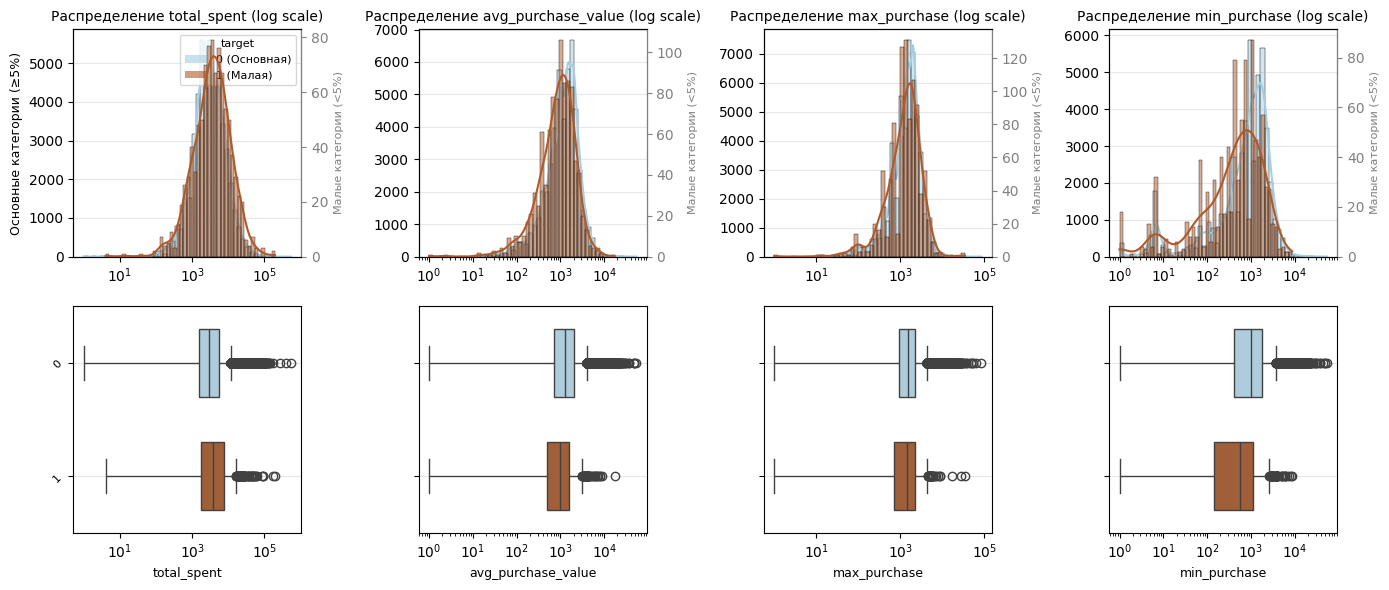

In [61]:
# выберем непрерывные числовые признаки
features = [
    #('purchase_count', 'purchase_count'),
    ('total_spent', 'total_spent'),
    ('avg_purchase_value', 'avg_purchase_value'),
    ('max_purchase', 'max_purchase'),
    ('min_purchase', 'min_purchase'),
    #('total_quantity', 'total_quantity'),
    #('avg_quantity', 'avg_quantity')
    ]

plot_distribution_with_boxplot(
    merged_purchases_df,
    features,
    'target',
    #category_order=['0', '1'],  # явно указываем порядок категорий
    bins=50,
    #auto_bins=True,
    log_scale='auto',
    minor_category_threshold=0.05
)

Различие по классам целевого признака, а именно положение мединного значения, присутствует в большинстве распределениях непрерывных числовых признаков (за исключением `max_purchase`) — хорошо для предсказательной способности модели.

Теперь исследуем распределения дискретных числовых признаков с помощью функции `plot_categorical_distributions`.

In [62]:
print(plot_categorical_distributions.__doc__)


    Визуализирует распределение категориальных признаков относительно бинарного целевого признака.
    Для каждого категориального признака строит два графика:
    1. Абсолютные значения (countplot)
    2. Относительные доли (stacked barplot)

    Parameters
    ----------
    df : pd.DataFrame
        Входной DataFrame с данными для визуализации.
    target_col : str
        Название целевого бинарного признака (должен содержать ровно 2 уникальных значения).
    categorical_features : List[str], optional
        Список категориальных признаков для анализа. Если None, будут использованы все столбцы
        с типами 'object' и 'category', исключая целевой признак.
    log_scale : bool, default=False
        Если True, ось Y на графиках абсолютных значений будет в логарифмическом масштабе.
    ncols : int, default=5
        Количество столбцов в сетке графиков.
    max_categories : int, default=10
        Максимальное количество категорий для отображения на одном графике.
        Если в

<a id='avg_quantity'></a>

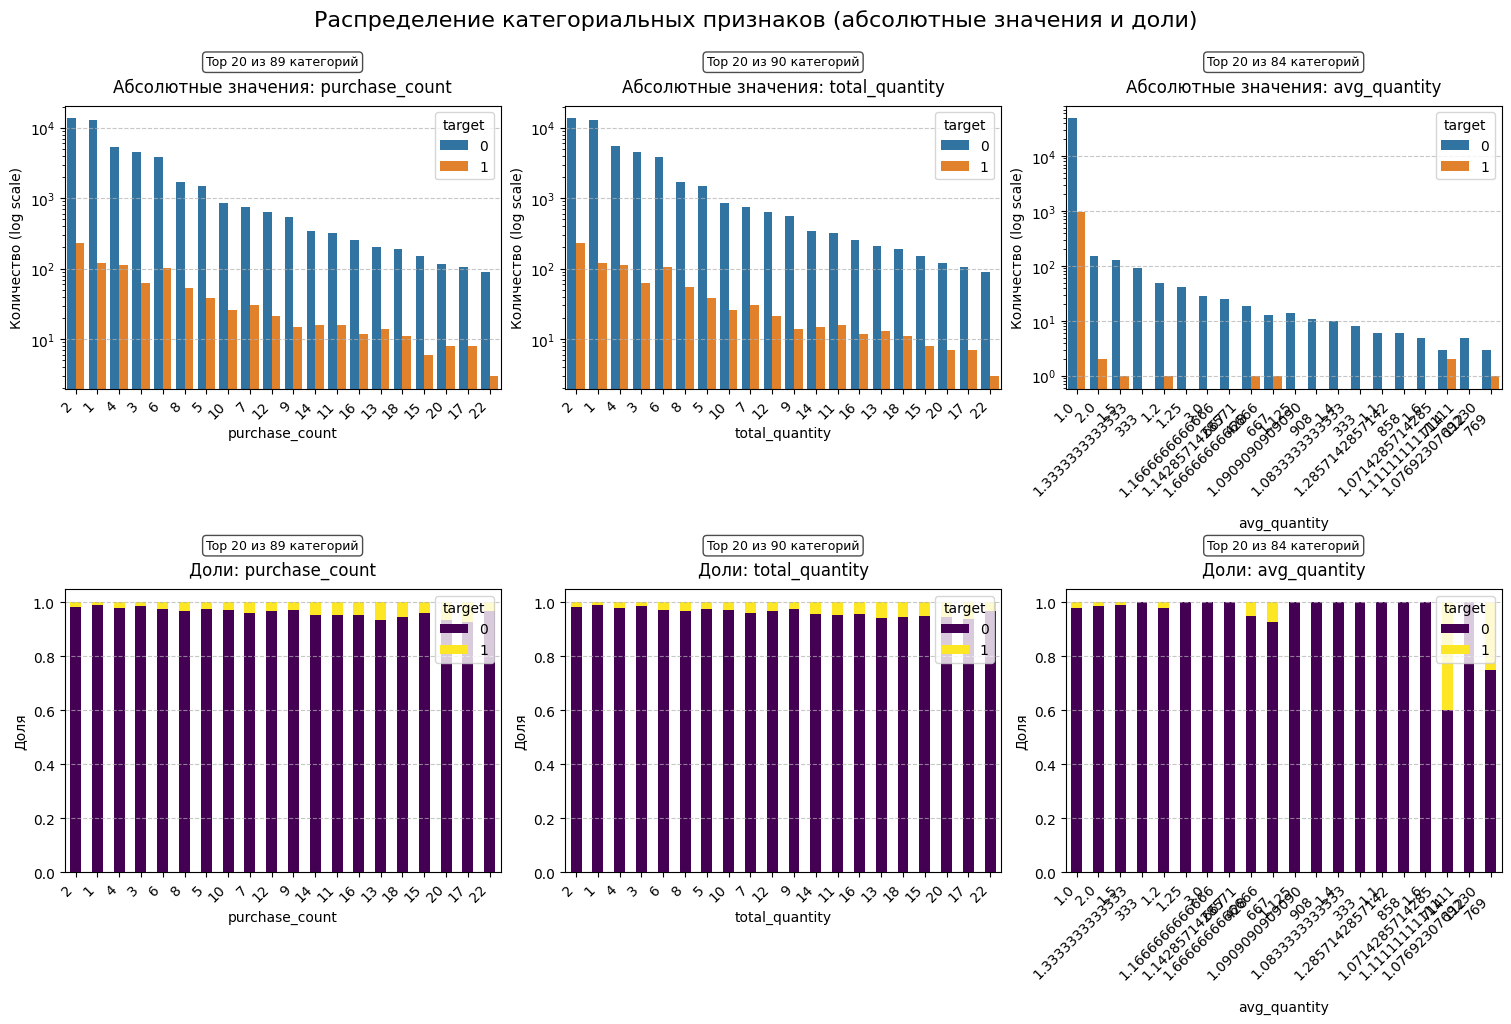

In [63]:
# выберем дискретные числовые признаки
features = [
    'purchase_count',
    'total_quantity',
    'avg_quantity'
    ]

plot_categorical_distributions(
    merged_purchases_df,
    'target',
    features,
    log_scale=True,
    ncols=3,
    max_categories=20,
    annotation_pos='above_title'
)

Можно отметить, что наблюдается увеличение доли класса `1` целевого признака для топ-20 категорий входных признаков `purchase_count`, `total_quantity`. Также видно, что для класса `1` все значения лежат в `avg_quantity=1`, что может сделать признак `avg_quantity` не информативным.

Рассмотрим теперь матрицу рассеяния для всех признаков

CPU times: total: 18.5 s
Wall time: 26.5 s


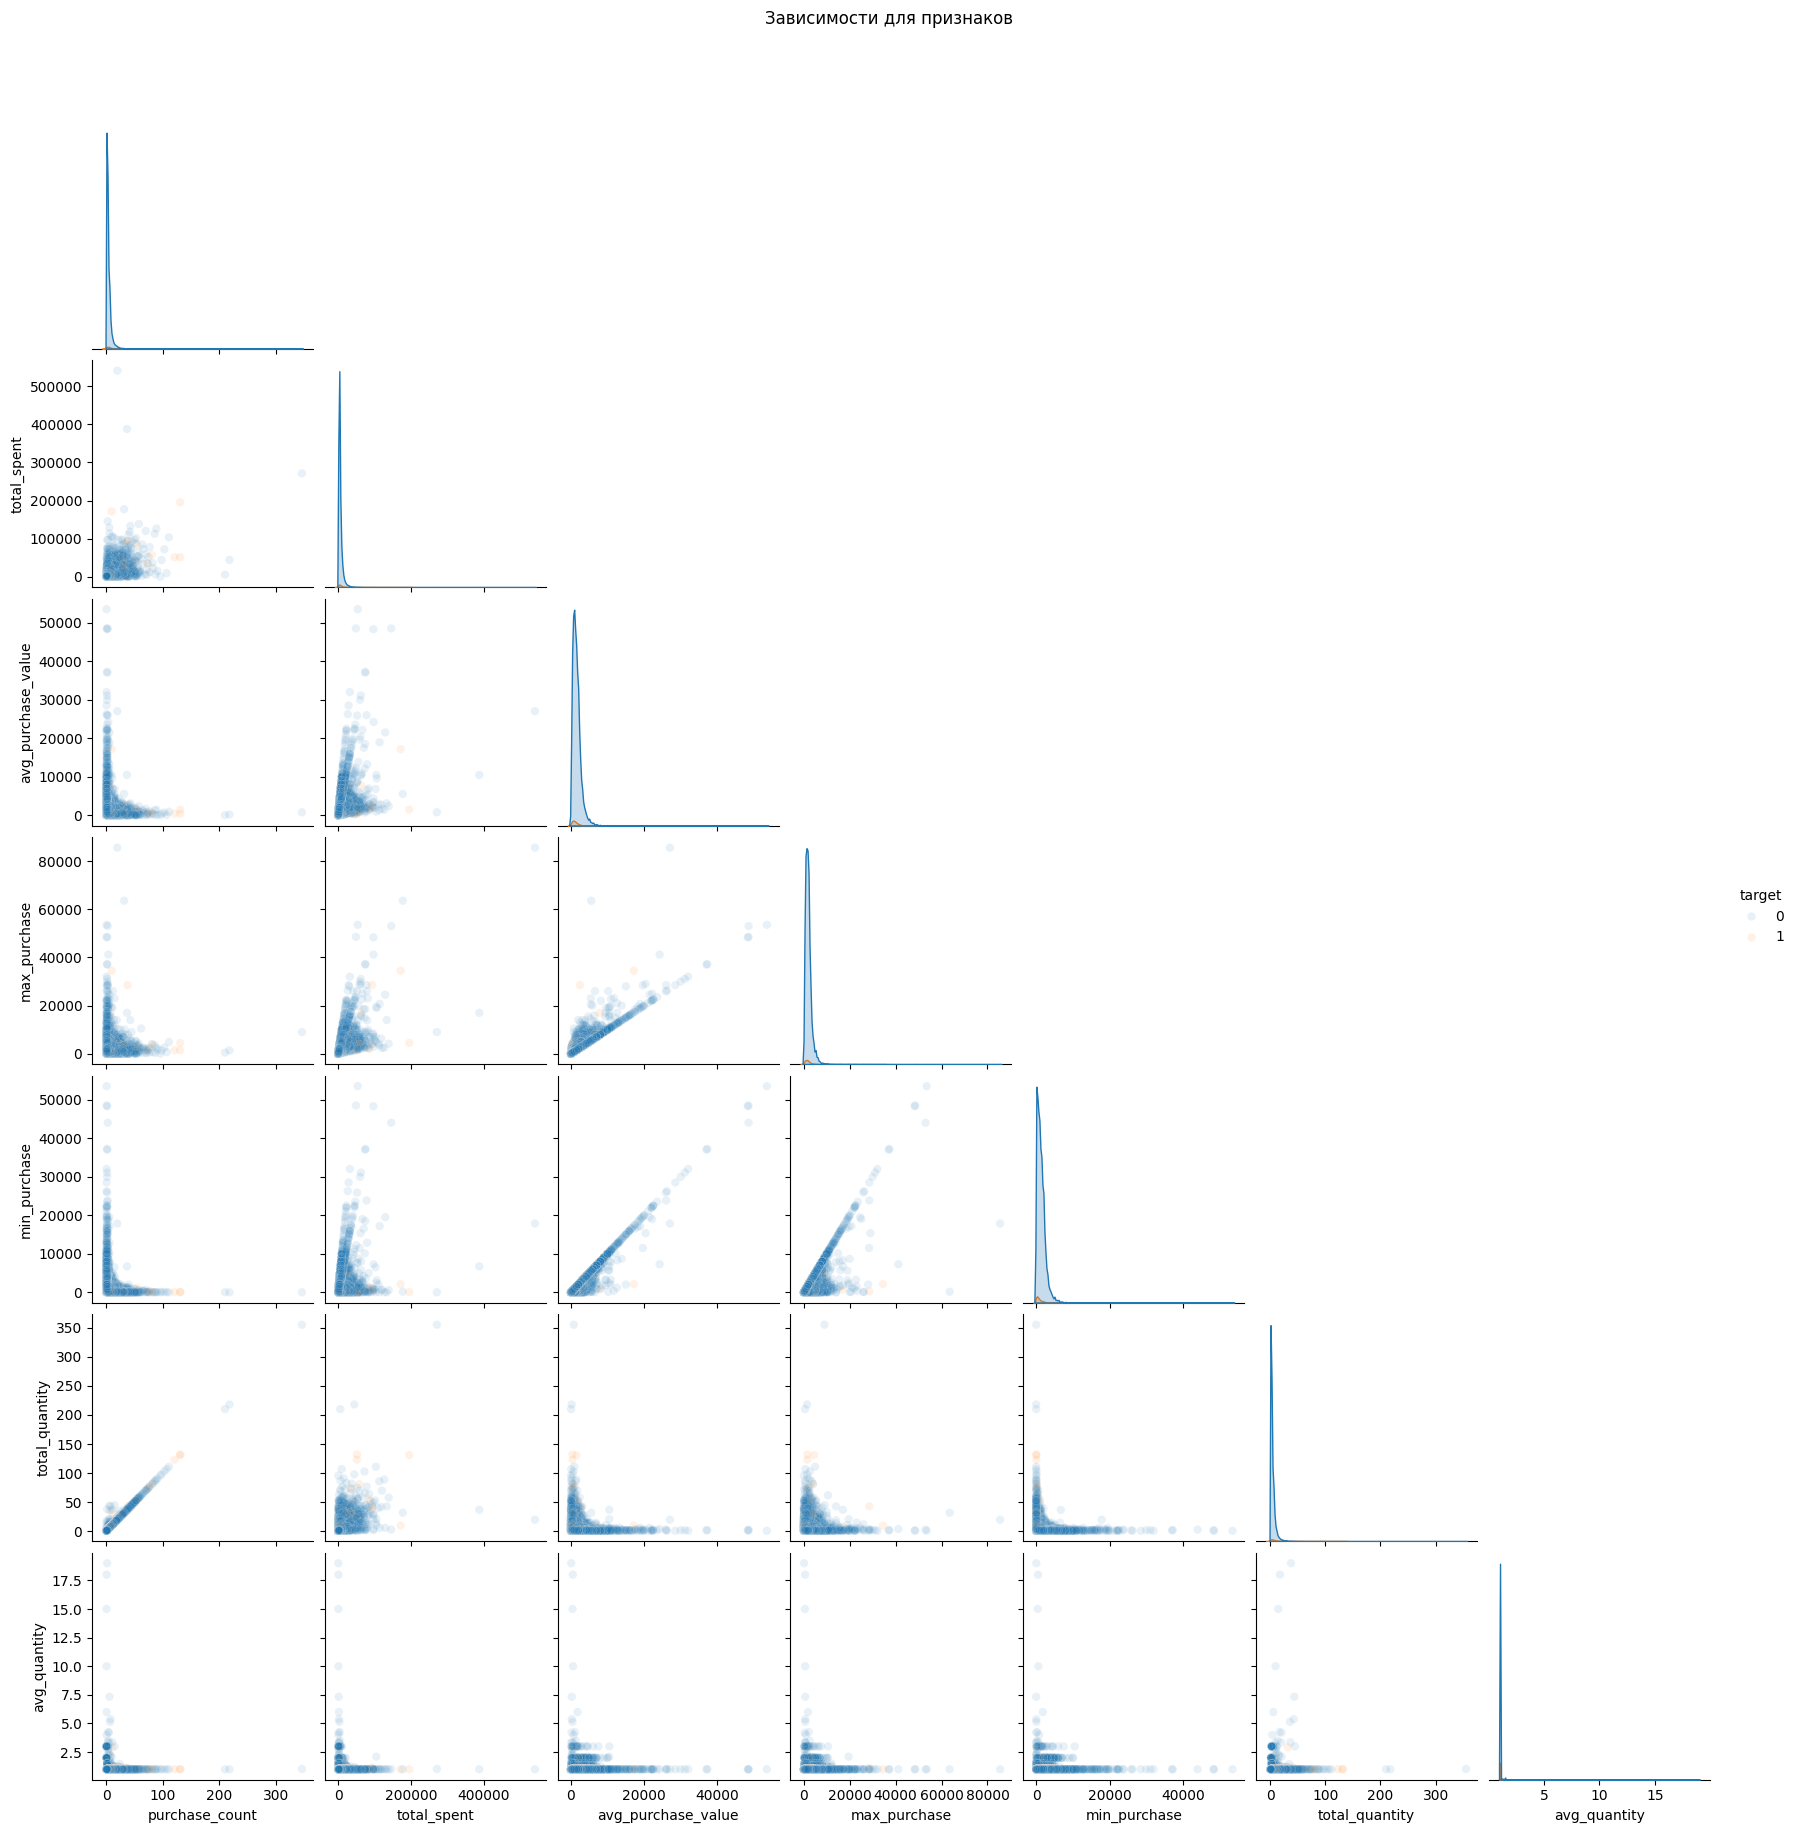

In [64]:
%%time
sns.pairplot(
    data=merged_purchases_df,
    hue='target',        # группировка по классам
    corner=True,         # не рисуем дублирующие графики
    plot_kws={'alpha': 0.1}
).fig.suptitle(
    'Зависимости для признаков',
    y=1.05
);

Видно, что для некоторых пар признаков существует сильная линейная зависимость, что объясняется природой их составления. Кроме них есть и нелинейные связи, поэтому составим матрицу корреляции Phi-k, которая даст понимание, между какими парами признаков есть мультиколлинеарность.   

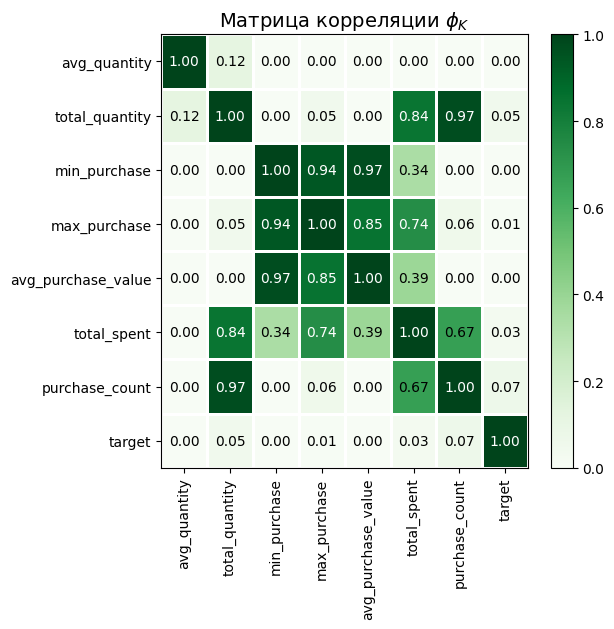

CPU times: total: 344 ms
Wall time: 4.76 s


In [65]:
%%time
# рассчитаем матрицу корреляции Phik
# присвоем переменной correlated_pairs датафрейм с парами признаков и их корреляцией Фи
# присвоем переменной threshold пороговое значение
# присвоем переменной interval_cols список названий всех столбцов с числовым непрерывным типом данных в обрабатываемом датафрейме
# присвоем переменной phi_k_with_target корреляции признаков с целевой переменной
result = phik_correlation_matrix(
    merged_purchases_df.drop(columns=['client_id']),
    threshold = 0.9,
    output_interval_cols=True,
    #interval_cols=['purchase_count', 'total_spent', 'avg_purchase_value',
    #'max_purchase', 'min_purchase', 'total_quantity', 'avg_quantity'],
    target_col='target',
    cell_size=0.8
)

# Результаты:
correlated_pairs = result[0]  # Пары коррелирующих признаков
interval_cols = result[1]     # Список числовых непрерывных столбцов
phi_k_with_target = result[2] # Корреляции признаков с целевой переменной

In [66]:
correlated_pairs

признак_1       признак_2  корреляция класс_корреляции
0      purchase_count  total_quantity        0.97    Очень высокая
1  avg_purchase_value    min_purchase        0.97    Очень высокая
2        max_purchase    min_purchase        0.94    Очень высокая

In [67]:
phi_k_with_target.sort_values(ascending=False)

purchase_count        0.07
total_quantity        0.05
total_spent           0.03
max_purchase          0.01
avg_purchase_value    0.00
min_purchase          0.00
avg_quantity          0.00
Name: target, dtype: float64

`avg_quantity` показал нулевую корреляцию с таргетом, вероятно, потому, что для класса `1` отсутствует какая-либо вариативность, так как преобладает одно значение (см. [здесь](#avg_quantity)). `avg_purchase_value` и `min_purchase` дают также нулевую корреляцию с таргетом. Последний в свою очередь дает мультиколлинеарность с признаком `max_purchase`. Среди признаков `purchase_count` и `total_quantity`, которые в паре дают мультиколлинеарность лучшую корреляцию с таргетом имеет признак `purchase_count`. Следовательно, удаляем признаки: `avg_quantity`, `avg_purchase_value`, `min_purchase`, `total_quantity`.

In [68]:
# оставляем отобранные новые признаки
merged_purchases_df = merged_purchases_df[['client_id', 'max_purchase', 'total_spent', 'purchase_count', 'target']]

## Временные признаки (активность клиента)

Эти признаки помогают понять, насколько клиент активен и как меняется его поведение со временем

In [69]:
# Преобразуем дату в datetime
purchases_df['date'] = pd.to_datetime(purchases_df['date'])

# Определяем текущую дату (последнюю дату в датасете)
current_date = purchases_df['date'].max()

# Определяем первую дату в датасете
min_date = purchases_df['date'].min()

# Определяем доступный временной период
print(f'Доступный временной период {current_date - min_date}')

Доступный временной период 641 days 00:00:00


In [70]:
# Группируем по client_id для временных признаков
time_features = purchases_df.groupby('client_id')['date'].agg(
    first_purchase_date='min',
    last_purchase_date='max',
    purchase_count='count'
).reset_index()

# Рассчитываем производные признаки
time_features['customer_age_days'] = (
    time_features['last_purchase_date'] - time_features['first_purchase_date']
).dt.days

time_features['days_since_last_purchase'] = (
    current_date - time_features['last_purchase_date']
).dt.days

time_features['purchase_frequency'] = (
    time_features['purchase_count'] / time_features['customer_age_days']
).replace([np.inf, -np.inf], 0)

# Рассчитываем тренд покупок (последние 90 дней vs предыдущие 90 дней)
# Граничная дата для анализа тренда
trend_cutoff_date = current_date - pd.Timedelta(days=90)

# Считаем покупки в последние 90 дней
recent_purchases = purchases_df[purchases_df['date'] > trend_cutoff_date]
recent_counts = recent_purchases.groupby('client_id').size().reset_index(name='recent_90d_purchases')

# Считаем покупки в предыдущие 90 дней (90-180 дней назад)
previous_period_start = trend_cutoff_date - pd.Timedelta(days=90)
previous_purchases = purchases_df[
    (purchases_df['date'] > previous_period_start) &
    (purchases_df['date'] <= trend_cutoff_date)
]
previous_counts = previous_purchases.groupby('client_id').size().reset_index(name='previous_90d_purchases')

# Объединяем все признаки
time_features = time_features.merge(
    recent_counts, on='client_id', how='left'
).merge(
    previous_counts, on='client_id', how='left'
)

# Заполняем пропуски нулями
time_features[['recent_90d_purchases', 'previous_90d_purchases']] = time_features[
    ['recent_90d_purchases', 'previous_90d_purchases']
].fillna(0)

# Рассчитываем тренд
time_features['purchase_trend_90d'] = (
    time_features['recent_90d_purchases'] - time_features['previous_90d_purchases']
)

# Удаляем промежуточные столбцы
time_features.drop(
    ['recent_90d_purchases', 'previous_90d_purchases', 'purchase_count'],
    axis=1,
    inplace=True
)

time_features = time_features.drop(columns = ['first_purchase_date', 'last_purchase_date'])

# Результат
time_features.head()

client_id  customer_age_days  days_since_last_purchase  \
0  1515915625468060902                  0                       630   
1  1515915625468061003                  0                       408   
2  1515915625468061099                  0                       640   
3  1515915625468061100                  0                         6   
4  1515915625468061170                 83                       244   

   purchase_frequency  purchase_trend_90d  
0            0.000000                 0.0  
1            0.000000                 0.0  
2            0.000000                 0.0  
3            0.000000                 2.0  
4            0.228916                 0.0

Пояснение к коду:

1. **Базовые временные признаки:**

- `first_purchase_date` — первая покупка клиента

- `last_purchase_date` — последняя покупка клиента

- `purchase_count` — общее количество покупок (дублируется из предыдущей агрегации)

2. **Производные признаки:**

- `customer_age_days` — "возраст" клиента в днях

- `days_since_last_purchase` — дней без покупок

- `purchase_frequency` — частота покупок (покупок в день)

3. **Тренд активности:**

*Сравниваем количество покупок за последние 90 дней с предыдущим 90-дневным периодом*

- `purchase_trend_90d` — разница между периодами (положительная = рост активности)

4. **Обработка крайних случаев:**

- Замена бесконечностей в частоте покупок для новых клиентов

- Заполнение пропусков нулями для клиентов без покупок в анализируемых периодах

Объединим с датасетом `target_df` по столбцу `client_id` и проведем исследовательский анализ

In [71]:
merged_purchases_df_1 = pd.merge(target_df, time_features, on='client_id', how='left')

In [72]:
extended_describe(merged_purchases_df_1, name="merged_purchases_df_1")

Числовое описание данных: merged_purchases_df_1


Объединение прошло успешно, так как все столбцы присутствуют, а количество строк соответствует количеству укникальных клиентов в `target_df`. В данной категории новых признаков мы имеем все числовые признаки. Есть небольшое расхождение среднего и мединного значений для признака `days_since_last_purchase` в 4%, а для остальных признаков мы наблюдаем заполнение преимущественно нулями. Рассмотрим их распределения более детально.

Для признака 'customer_age_days' автоматически выбрано 30 корзин
Для признака 'days_since_last_purchase' автоматически выбрано 39 корзин
Для признака 'purchase_frequency' автоматически выбрано 30 корзин
Для признака 'purchase_trend_90d' автоматически выбрано 30 корзин


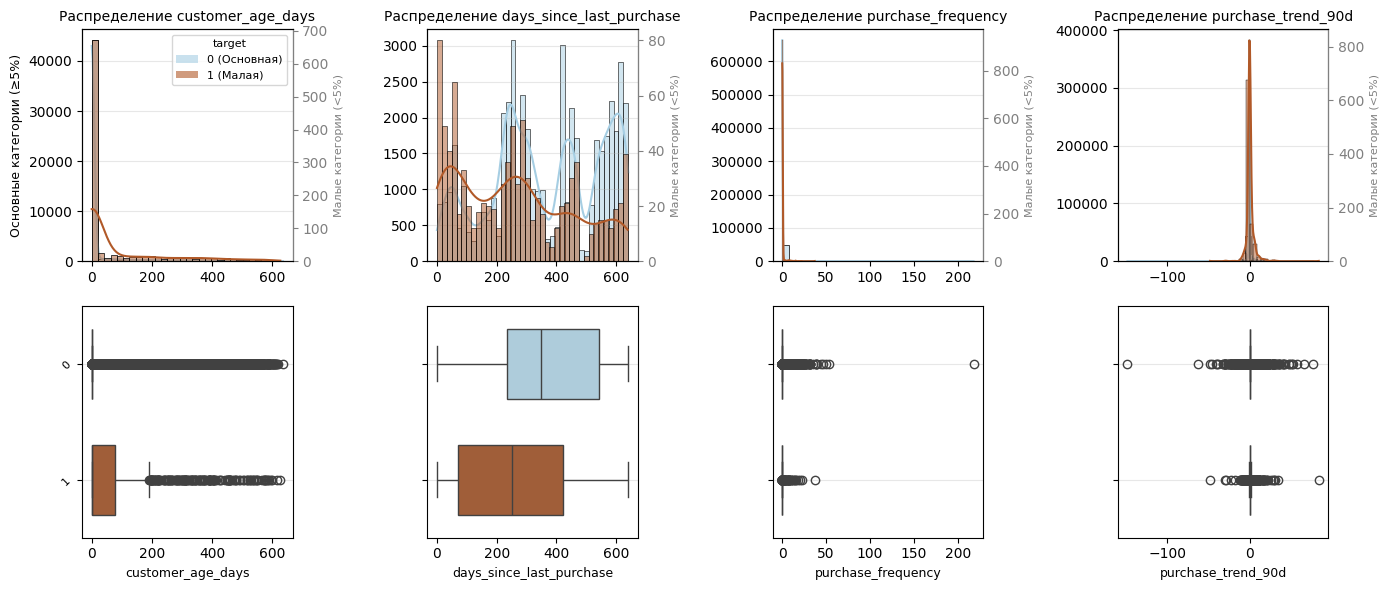

In [73]:
# выберем непрерывные числовые признаки
features = [
    ('customer_age_days', 'customer_age_days'),
    ('days_since_last_purchase', 'days_since_last_purchase'),
    ('purchase_frequency', 'purchase_frequency'),
    ('purchase_trend_90d', 'purchase_trend_90d')
    ]

plot_distribution_with_boxplot(
    merged_purchases_df_1,
    features,
    'target',
    #category_order=['0', '1'],  # явно указываем порядок категорий
    #bins=50,
    auto_bins=True,
    #log_scale='auto',
    minor_category_threshold=0.05
)

Разница для классов целевого признака заметно проявляется для признаков `customer_age_days` и `days_since_last_purchase`. В первом случае распределение для класса `1` более широкое, что говорит о более высоком "возрасте" клиентов класса `1`. Во втором случае распределение для класса `1` смещено уже в сторону меньших значений, что говорит о том, что они "недавно" совершали покупки. Два других признака квази-дискретные и их распределения сконцентрированы вблизи нуля, поэтому для большей информации воспользуемся функцией `plot_categorical_distributions`.

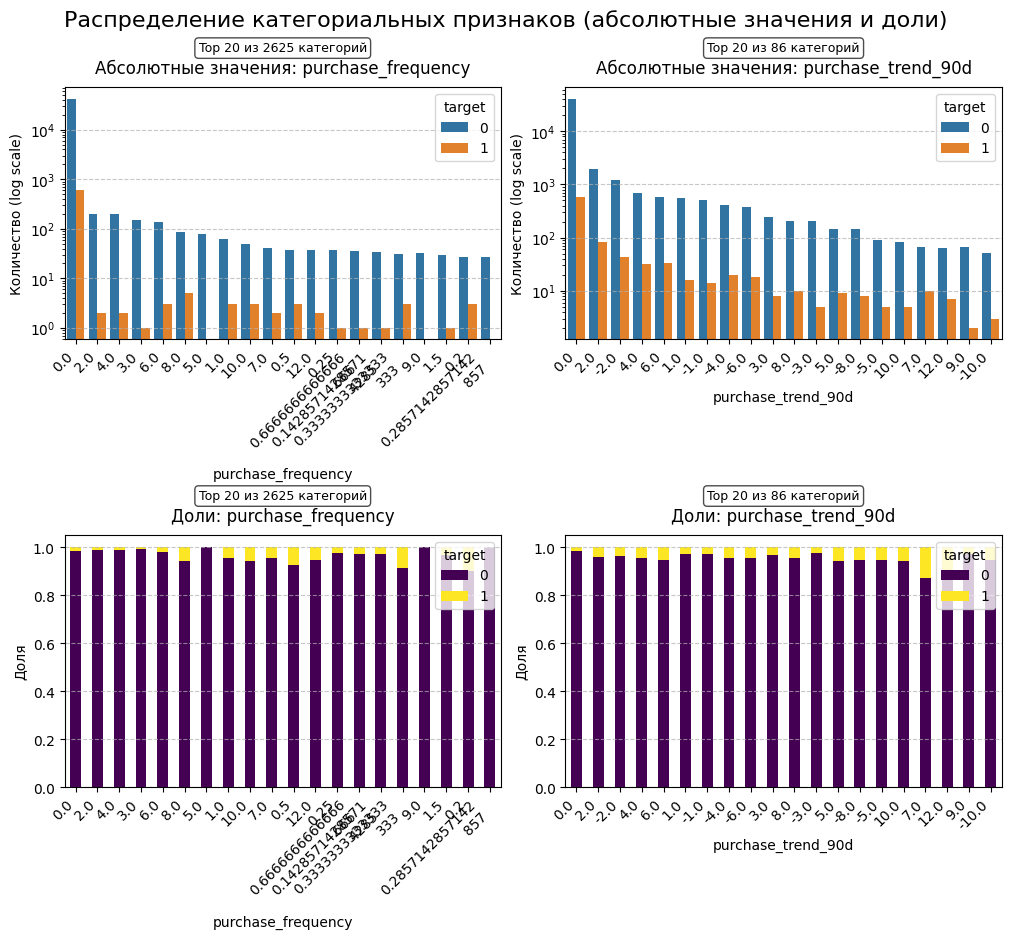

In [74]:
# выберем дискретные числовые признаки
features = [
    'purchase_frequency',
    'purchase_trend_90d'
    ]

plot_categorical_distributions(
    merged_purchases_df_1,
    'target',
    features,
    log_scale=True,
    #ncols=3,
    max_categories=20,
    annotation_pos='above_title'
)

Каких-либо серьезных различий для классов целевого признака не обнаружено, что косвено указывает на слабое влияние новых признаков `purchase_frequency`и `purchase_trend_90d` на предсказательную способность модели машинного обучения.

Корреляционный анализ даст дополнительную полезную информация о характере взаимодействия данных признаков.

CPU times: total: 3.72 s
Wall time: 8.4 s


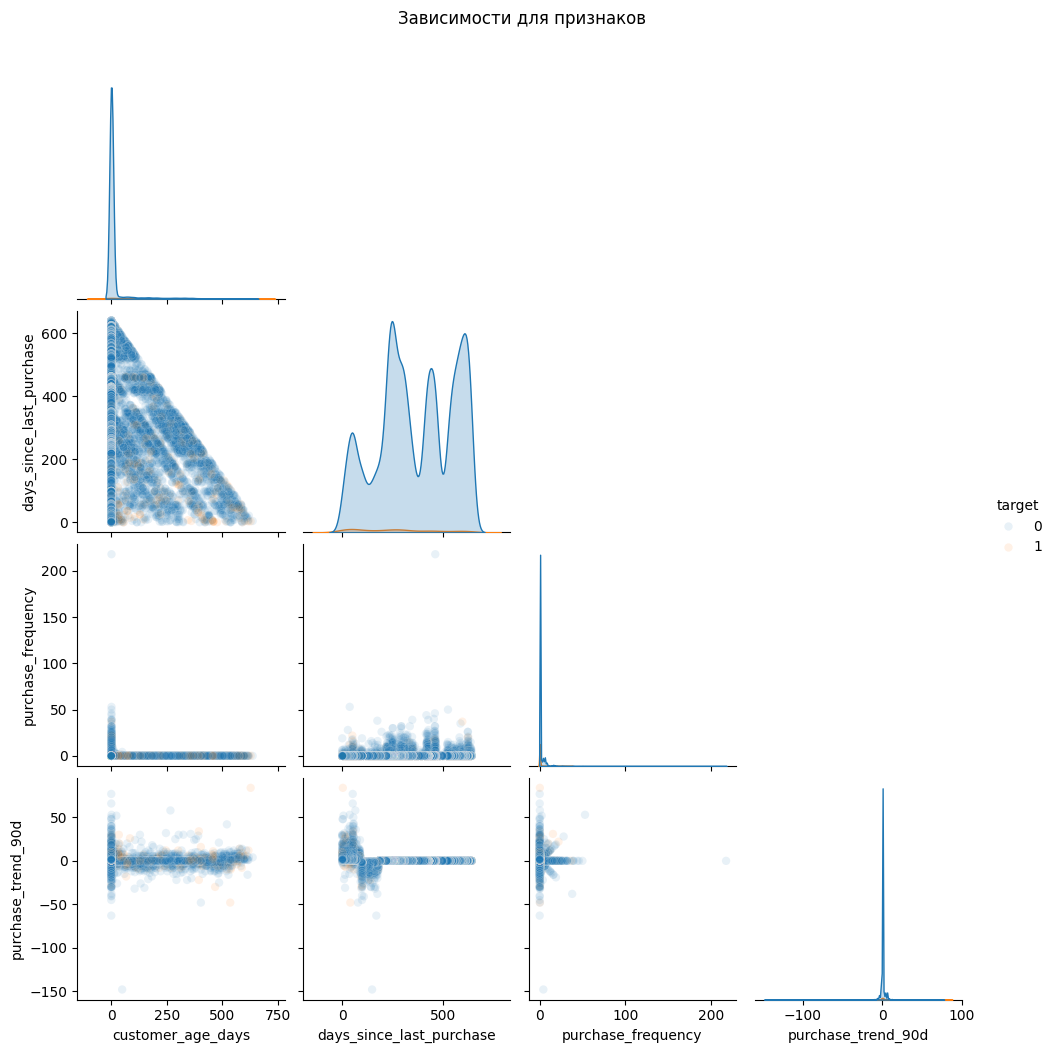

In [75]:
%%time
sns.pairplot(
    data=merged_purchases_df_1,
    hue='target',        # группировка по классам
    corner=True,         # не рисуем дублирующие графики
    plot_kws={'alpha': 0.1}
).fig.suptitle(
    'Зависимости для признаков',
    y=1.05
);

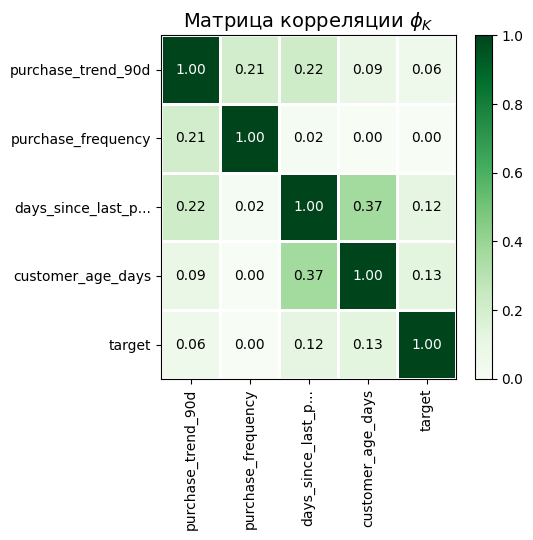

Мультиколлинеарность между парами входных признаков отсутствует
CPU times: total: 172 ms
Wall time: 275 ms


In [76]:
%%time
# рассчитаем матрицу корреляции Phik
# присвоем переменной correlated_pairs датафрейм с парами признаков и их корреляцией Фи
# присвоем переменной threshold пороговое значение
# присвоем переменной interval_cols список названий всех столбцов с числовым непрерывным типом данных в обрабатываемом датафрейме
# присвоем переменной phi_k_with_target корреляции признаков с целевой переменной
result = phik_correlation_matrix(
    merged_purchases_df_1.drop(columns=['client_id']),
    threshold = 0.9,
    output_interval_cols=True,
    #interval_cols=['customer_age_days', 'days_since_last_purchase', 'purchase_frequency', 'purchase_trend_90d'],
    target_col='target'
)

# Результаты:
correlated_pairs = result[0]  # Пары коррелирующих признаков
interval_cols = result[1]     # Список числовых непрерывных столбцов
phi_k_with_target = result[2] # Корреляции признаков с целевой переменной

Согласно матрице корреляции и диаграммам рассеяния признак `purchase_frequency` слабо коррелирует с целевым и с большинством других признаков данной категории. Поэтому предлагается его исключить.

In [77]:
# Исключаем признак purchase_frequency
merged_purchases_df_1 = merged_purchases_df_1.drop(columns=['purchase_frequency'])

Дополним датасет с новыми признаками временными характеристиками.

In [78]:
# добавляем новые признаки
merged_purchases_df = pd.merge(merged_purchases_df, merged_purchases_df_1.drop(columns=['target']), on='client_id', how='left')

## Финансовые метрики (стабильность трат)

In [79]:
# Создаем копию датафрейма, чтобы не изменять исходный
purchases = purchases_df.copy()

# Добавляем столбец с суммой покупки (price * quantity)
purchases['purchase_sum'] = purchases['price'] * purchases['quantity']

# Группируем по client_id и вычисляем финансовые метрики
financial_metrics = purchases.groupby('client_id')['purchase_sum'].agg([
    ('total_spent', 'sum'),              # Общая сумма покупок
    ('avg_purchase_value', 'mean'),      # Средний чек
    ('std_spent', 'std'),               # Стандартное отклонение суммы покупок
]).reset_index()

# Рассчитываем коэффициент вариации
financial_metrics['cv_spent'] = (
    financial_metrics['std_spent'] / financial_metrics['avg_purchase_value']
)

# Заменяем возможные бесконечные значения на 0
financial_metrics['cv_spent'] = financial_metrics['cv_spent'].replace([np.inf, -np.inf], 0)

# Также заменяем NaN на 0 (для случаев, когда std_spent = NaN и avg_purchase_value = 0)
financial_metrics['cv_spent'] = financial_metrics['cv_spent'].fillna(0)

financial_metrics['is_single_purchase'] = financial_metrics['std_spent'].isna().astype(int).astype(str)

# Удаляем avg_purchase_value и total_spent, так как уже исследовались
financial_metrics = financial_metrics.drop(columns=['avg_purchase_value', 'total_spent'])

# Результат
financial_metrics.head()

client_id   std_spent  cv_spent is_single_purchase
0  1515915625468060902  802.080628  0.802884                  0
1  1515915625468061003  560.494042  0.241667                  0
2  1515915625468061099         NaN  0.000000                  1
3  1515915625468061100    0.000000  0.000000                  0
4  1515915625468061170  802.921981  0.454020                  0

**Пояснение к коду:**

1 **Создание столбца с суммой покупки:**

- `purchase_sum = price * quantity` — сумма каждой отдельной покупки

2. **Агрегация по клиентам:**

- `total_spent` — общая сумма всех покупок клиента (сумма всех `purchase_sum`)

- `avg_purchase_value` — средний чек (среднее значение `purchase_sum`)

- `std_spent` — стандартное отклонение сумм покупок:

Показывает, насколько суммы покупок отклоняются от среднего

Высокое значение = нестабильные траты, низкое = стабильные траты

3. **Коэффициент вариации:**

- `cv_spent = std_spent / avg_purchase_value` — относительная мера вариативности:

- Чем выше коэффициент, тем менее предсказуемы траты клиента

- заменяем inf/-inf на 0 (Нулевое значение означает либо абсолютно стабильные траты, либо недостаток данных)

4. `is_single_purchase = 1` если `std_spent = NaN` (у клиента 1 покупка), иначе 0

Смысл:

1 — клиент совершил только одну покупку за весь период

0 — клиент совершил две и более покупок

5. **Обработка особых случаев:**

- Для клиентов с одной покупкой:

`std_spent = NaN` → автоматически заменяется на 0 в `cv_spent`

Логика: недостаточно данных для оценки вариативности

- При нулевом среднем чеке:

`cv_spent` становится бесконечным → заменяется на 0

Интерпретация: технически вариативность отсутствует

- Все NaN в `cv_spent` также заменяются на 0 для единообразия

Объединим с датасетом `target_df` по столбцу `client_id` и проведем исследовательский анализ

In [80]:
merged_purchases_df_2 = pd.merge(target_df, financial_metrics, on='client_id', how='left')

In [81]:
extended_describe(merged_purchases_df_2, name="merged_purchases_df_2")

Числовое описание данных: merged_purchases_df_2


Из числового описания видно, что у признака `std_spent` есть пропуски. Кроме этого он уже входит в формулу для расчета признака `cv_spent`. Поэтому предлагается его удалить. В признаке `cv_spent` сильное разногласие между средним и медианой, что указывает на неравномерное распределение с начиличем сильных выбросов. При этом он охватыват большой диапазон значений, так как `rel_std%` высок, что привнесет положительный вклад в обобщающую способность модели. Последний признак в данном разделе `is_single_purchase` является категориальным и имеет лишь два класса, среди которых превалирует класс `0` (74% среди всех данных), что указывает на тот факт, что преобладающее количество покупок более чем 1.

In [82]:
merged_purchases_df_2 = merged_purchases_df_2.drop(columns='std_spent')

Для признака 'cv_spent' автоматически выбрано 235 корзин


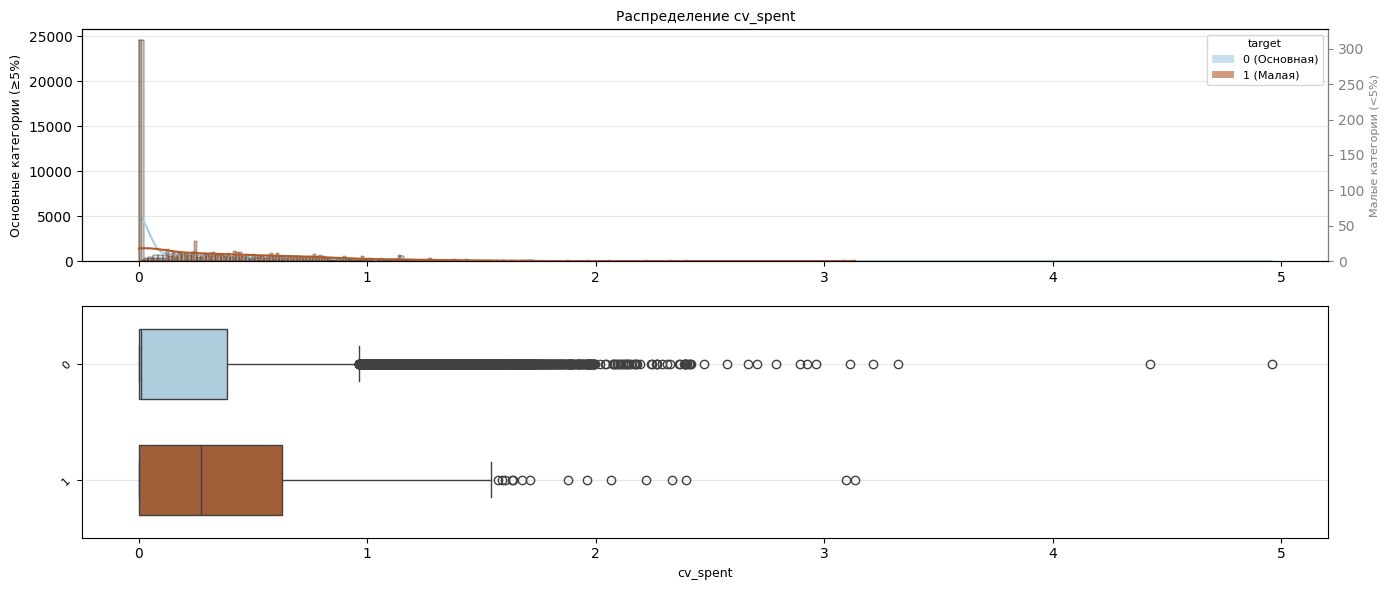

In [83]:
# выберем непрерывные числовые признаки
features = [
    ('cv_spent', 'cv_spent')
    ]

plot_distribution_with_boxplot(
    merged_purchases_df_2,
    features,
    'target',
    #category_order=['0', '1'],  # явно указываем порядок категорий
    #bins=50,
    auto_bins=True,
    #log_scale='auto',
    minor_category_threshold=0.05
)

На диаграммах размаха достаточно хорошо видная разница между классами целевого признака, что косвено указывает на значимость нового признака `cv_spent` для моделей машинного обучения.

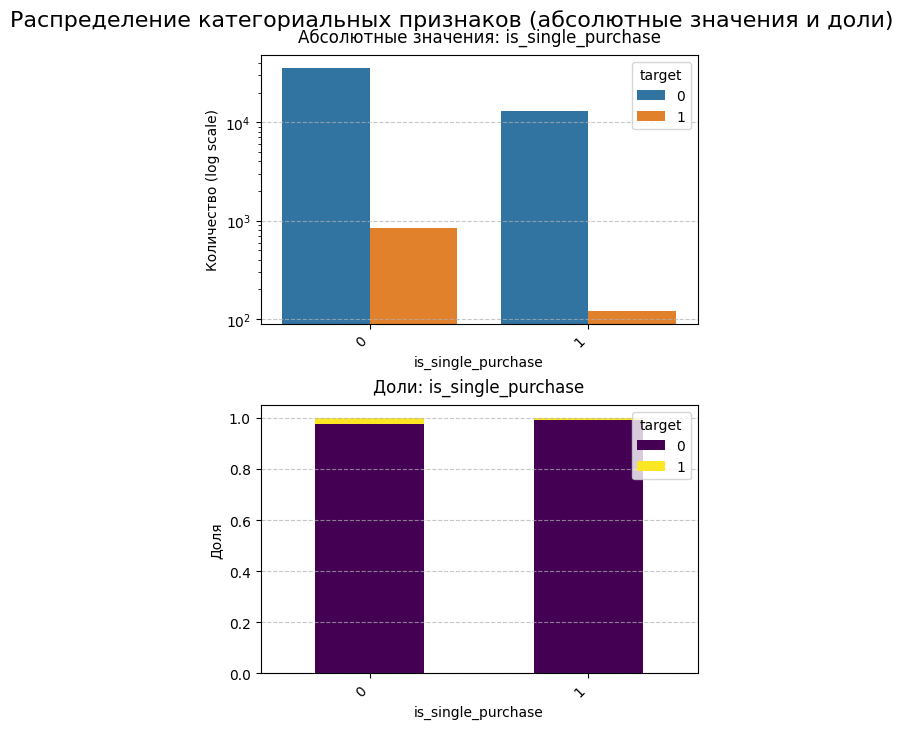

In [84]:
# выберем дискретные числовые признаки
features = [
    'is_single_purchase'
    ]

plot_categorical_distributions(
    merged_purchases_df_2,
    'target',
    features,
    log_scale=True,
    #ncols=3,
    max_categories=20,
    annotation_pos='above_title'
)

Согласно диаграммам новый признак `is_single_purchase` также дает различить классы целевого признака: клиенты класса `1` по целевому признаку чаще имеют количество покупок больше 1, чем клиенты класса `0`. 

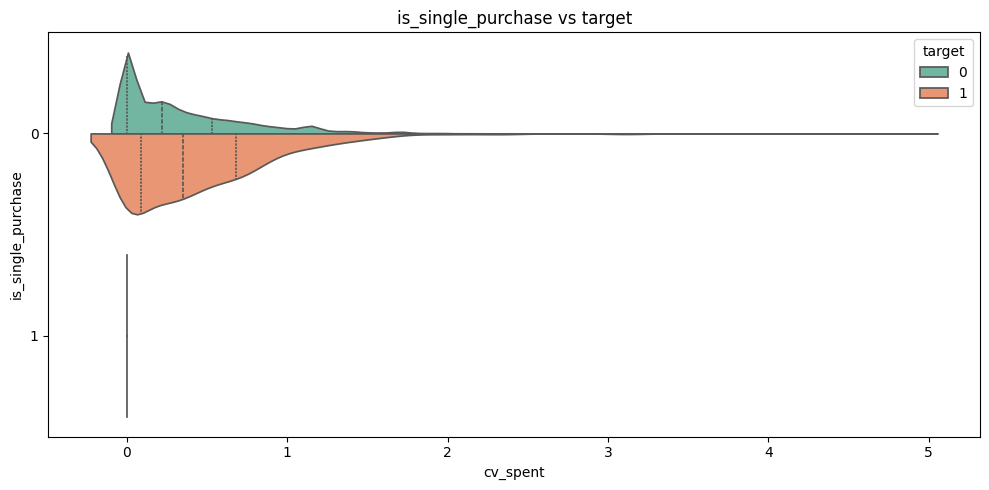

In [85]:
plot_violin_combinations(
    merged_purchases_df_2,
    x_column='cv_spent',
    y_features=[
        'is_single_purchase'
    ],
    hue_features=['target'],
    figsize_per_plot=(10, 5),
    log_scale_x=False
)

Данная диаграмма доказывает правильность выполнения логики создания новых признаков, так как по ней признак `cv_spent` имеет значение 0 для класса `1` признака `is_single_purchase`.

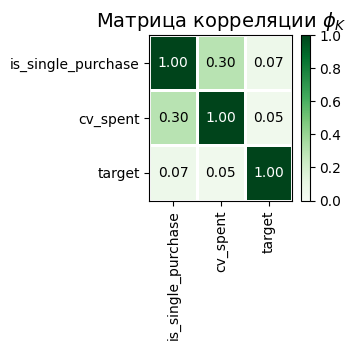

Мультиколлинеарность между парами входных признаков отсутствует
CPU times: total: 46.9 ms
Wall time: 181 ms


In [86]:
%%time
# рассчитаем матрицу корреляции Phik
# присвоем переменной correlated_pairs датафрейм с парами признаков и их корреляцией Фи
# присвоем переменной threshold пороговое значение
# присвоем переменной interval_cols список названий всех столбцов с числовым типом данных в обрабатываемом датафрейме
# присвоем переменной phi_k_with_target корреляции признаков с целевой переменной
result = phik_correlation_matrix(
    merged_purchases_df_2.drop(columns=['client_id']),
    threshold = 0.9,
    output_interval_cols=True,
    target_col='target',
    cell_size=1.2
)

# Результаты:
correlated_pairs = result[0]  # Пары коррелирующих признаков
interval_cols = result[1]     # Список числовых столбцов
phi_k_with_target = result[2] # Корреляции признаков с целевой переменной

Несмотря на то, что оба новых признака имеют некоторую связь, описанную выше, они не вносят мультиколлинеарность. При этом они имеют относительно хорошую корреляцию с целевым по сравнению с новыми признаками в предыдущих разделах. Поэтому включим оба из них в итоговый датасет.

In [87]:
# добавляем новые признаки
merged_purchases_df = pd.merge(merged_purchases_df, merged_purchases_df_2.drop(columns=['target']), on='client_id', how='left')

In [88]:
merged_purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 49849 non-null  object 
 1   max_purchase              49849 non-null  float64
 2   total_spent               49849 non-null  float64
 3   purchase_count            49849 non-null  int64  
 4   target                    49849 non-null  object 
 5   customer_age_days         49849 non-null  int64  
 6   days_since_last_purchase  49849 non-null  int64  
 7   purchase_trend_90d        49849 non-null  float64
 8   cv_spent                  49849 non-null  float64
 9   is_single_purchase        49849 non-null  object 
dtypes: float64(4), int64(3), object(3)
memory usage: 3.8+ MB


## Признаки, связанные с реакцией на рассылки

In [89]:
%%time

# Сначала агрегируем данные о рассылках на уровне клиента
client_campaigns = messages_df.groupby(['client_id', 'message_id']).agg({
    'created_at': 'min'  # Берём первую дату рассылки так как есть дубли
}).reset_index()

# Объединяем с покупками через client_id (а не через message_id)
merged_data = purchases_df.merge(
    client_campaigns,
    on=['client_id', 'message_id'],
    how='left'  # Сохраняем все покупки, даже без рассылки
)

# Фильтруем только валидные случаи с рассылкой
valid_responses_full = merged_data[merged_data['created_at'].notna()].copy()

# Вычисляем время отклика (только для покупок после рассылки)
valid_responses_full['days_to_purchase'] = (
    (pd.to_datetime(valid_responses_full['date']) - pd.to_datetime(valid_responses_full['created_at']))
    .dt.total_seconds() / (3600 * 24)
)
valid_responses = valid_responses_full[valid_responses_full['days_to_purchase'] >= 0]

# Агрегируем метрику
campaign_metrics = valid_responses.groupby('client_id').agg(
    purchases_after_campaign=('message_id', 'count')  # Все покупки после рассылок
).reset_index()

# Добавляем для всех клиентов (сохраняем тех, кто не получал рассылки)
all_clients = purchases_df[['client_id']].drop_duplicates()
campaign_metrics = all_clients.merge(campaign_metrics, on='client_id', how='left')

# Заполняем пропуски
campaign_metrics = campaign_metrics.fillna({
    'purchases_after_campaign': 0
})

# Доля покупок после рассылок от общего числа покупок
campaign_metrics = campaign_metrics.merge(
    purchase_aggregations[['client_id', 'purchase_count']],
    on='client_id',
    how='left'
)
campaign_metrics['campaign_purchase_ratio'] = np.where(
    campaign_metrics['purchase_count'] > 0,
    campaign_metrics['purchases_after_campaign'] / campaign_metrics['purchase_count'],
    0
)

# Удаляем purchase_count, так как уже исследовали
campaign_metrics = campaign_metrics.drop(columns='purchase_count')

CPU times: total: 2min 18s
Wall time: 3min 33s


In [90]:
# Определяем негативные события
negative_events = ['unsubscribe', 'complain', 'hbq_spam', 'hard_bounce', 'soft_bounce']

# Преобразуем даты в messages_df
messages_df['created_at'] = pd.to_datetime(messages_df['created_at'])
messages_df['date'] = pd.to_datetime(messages_df['date'])

# Агрегация данных на уровне клиента и канала
events_agg = messages_df.groupby('client_id').agg(
    total_sends=('event', lambda x: (x == 'send').sum()),
    total_clicks=('event', lambda x: (x == 'click').sum()),
    total_purchase_events=('event', lambda x: (x == 'purchase').sum()),
    total_negative=('event', lambda x: x.isin(negative_events).sum())
    ).reset_index()

# Рассчитываем метрику
events_agg['global_negative_rate'] = events_agg['total_negative'] / events_agg['total_sends']

# Бинарный флаг
events_agg['had_negative_event'] = (events_agg['total_negative'] > 0).astype(int)

# Замена бесконечных значений и NaN
rate_columns = [col for col in events_agg.columns if 'rate' in col]
events_agg[rate_columns] = events_agg[rate_columns].replace([np.inf, -np.inf], np.nan).fillna(0)

In [91]:
# Объединяем с ранее созданными campaign_metrics
final_metrics = campaign_metrics.merge(events_agg, on='client_id', how='left')

# Заполняем пропуски для клиентов без сообщений
message_cols = events_agg.columns.difference(['client_id'])
final_metrics[message_cols] = final_metrics[message_cols].fillna(0)

In [92]:
# Корректируем метрику для проблемных клиентов
positive_metrics = [
    'purchases_after_campaign'
]

for col in positive_metrics:
    final_metrics.loc[final_metrics['had_negative_event'] == 1, col] = 0

In [93]:
# Удалим вспомогательные признаки
final_metrics = final_metrics.drop(columns=['total_sends', 'total_negative', 'had_negative_event'])

# Оптимизация типов данных
for col in final_metrics.select_dtypes(include=['float64']):
    final_metrics[col] = pd.to_numeric(final_metrics[col], downcast='float')

for col in final_metrics.select_dtypes(include=['int64']):
    final_metrics[col] = pd.to_numeric(final_metrics[col], downcast='integer')

In [94]:
final_metrics.head()

client_id  purchases_after_campaign  campaign_purchase_ratio  \
0  1515915625468169594                       3.0                 0.333333   
1  1515915625471138230                       0.0                 0.000000   
2  1515915625471640575                       0.0                 0.000000   
3  1515915625490211585                       0.0                 0.000000   
4  1515915625490739153                       0.0                 0.000000   

   total_clicks  total_purchase_events  global_negative_rate  
0          14.0                    4.0              0.000000  
1          10.0                    0.0              0.000000  
2          21.0                    3.0              0.000000  
3           0.0                    0.0              0.000000  
4           5.0                    0.0              0.003145

**Признаки:**

1. *`purchases_after_campaign`*
- Описание: Общее количество покупок, совершенных после любых рассылок.
- Расчёт: Количество строк в `valid_responses` для каждого клиента.
- Важность: Индикатор общей отзывчивости клиента на маркетинг.

2. *`campaign_purchase_ratio`*
- Описание: Доля покупок, связанных с рассылками.
- Расчёт: `purchases_after_campaign / purchase_count`
- Важность: Показывает зависимость клиента от маркетинговых стимулов.

3. *`total_clicks`*  
- Описание: Общее количество кликов по рассылкам.
- Расчёт: Количество действий `click`
- Важность: Прямой индикатор интереса к контенту

4. *`total_purchase_events`*  
- Описание: Количество покупок, напрямую связанных с рассылками.
- Расчёт: Количество действий `purchase`
- Важность: Важнейший показатель конверсии

5. *`global_negative_rate`*  
- Описание: Общий процент негативных реакций.
- Расчёт: Количество негативных действий разделить на количество рассылок
- Важность: Критически важный анти-индикатор

**Особенности реализации (важные нюансы)**

1. *Обработка дублей рассылок:*

Использование `created_at: 'min'` гарантирует учет только первой отправки.

2. *Фильтрация некорректных данных:*

Удаление случаев с `days_to_purchase < 0` исключает покупки ДО рассылки.

3. *Сохранение всех клиентов:*

`how='left'` при объединении гарантирует, что клиенты без рассылок останутся в данных.

4. *Заполнение пропусков нулями:*

Позволяет работать с клиентами без реакции на рассылки.

In [95]:
merged_purchases_df_3 = pd.merge(target_df, final_metrics, on='client_id', how='left')

In [96]:
extended_describe(merged_purchases_df_3, name="final_metrics")

Числовое описание данных: final_metrics


Объединение с `target_df` прошло успешно. Проведем корреляционный анализ

CPU times: total: 9.72 s
Wall time: 13 s


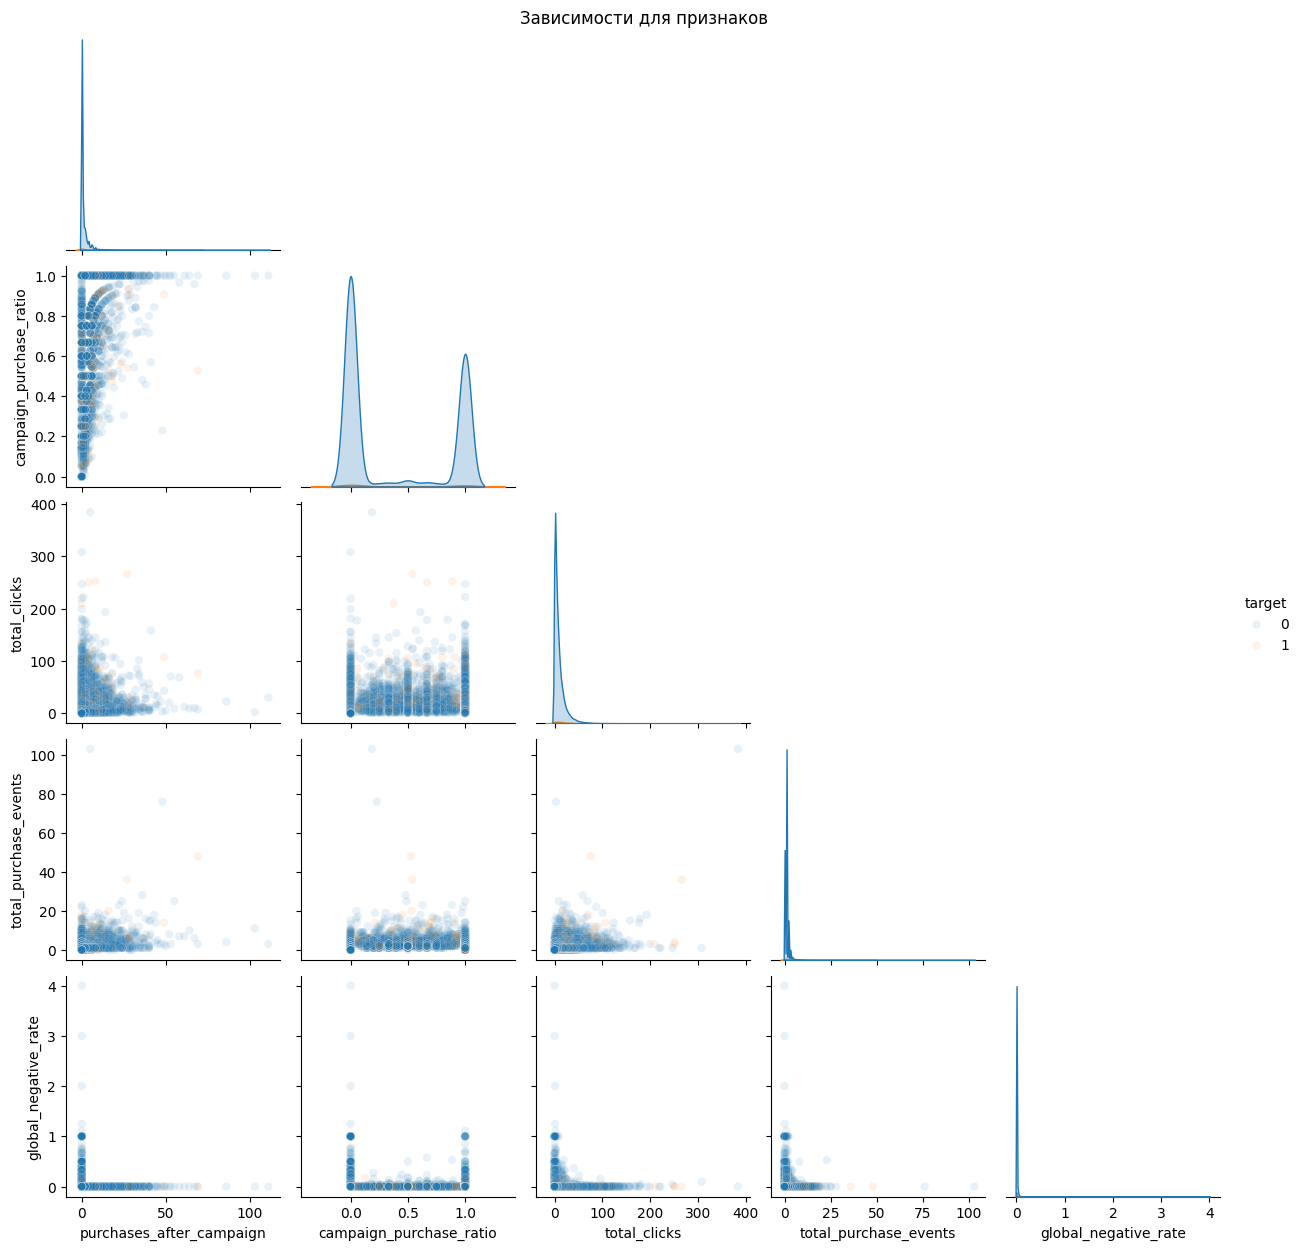

In [97]:
%%time
sns.pairplot(
    data=merged_purchases_df_3,
    hue='target',        # группировка по классам
    corner=True,         # не рисуем дублирующие графики
    plot_kws={'alpha': 0.1}
).fig.suptitle(
    'Зависимости для признаков',
    y=1.0
);

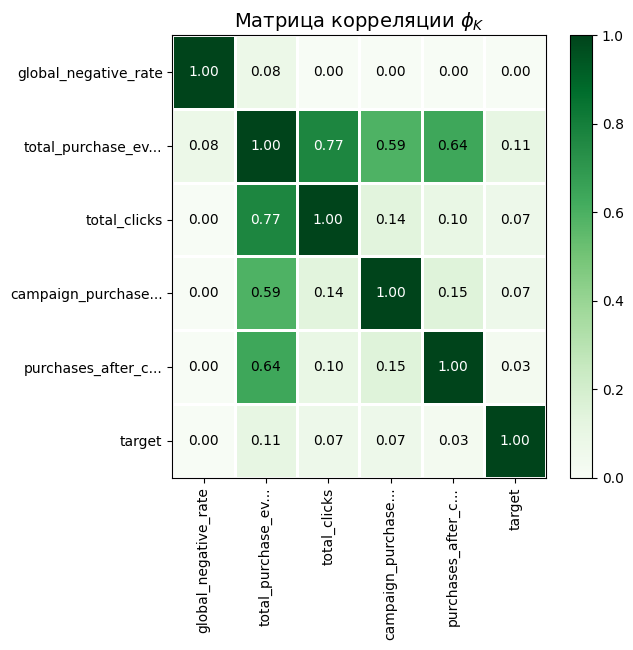

Мультиколлинеарность между парами входных признаков отсутствует
CPU times: total: 203 ms
Wall time: 373 ms


In [98]:
%%time
# рассчитаем матрицу корреляции Phik
# присвоем переменной correlated_pairs датафрейм с парами признаков и их корреляцией Фи
# присвоем переменной threshold пороговое значение
# присвоем переменной interval_cols список названий всех столбцов с числовым типом данных в обрабатываемом датафрейме
# присвоем переменной phi_k_with_target корреляции признаков с целевой переменной
result = phik_correlation_matrix(merged_purchases_df_3.drop(columns=['client_id']), threshold = 0.9, output_interval_cols=True, target_col='target')

# Результаты:
correlated_pairs = result[0]  # Пары коррелирующих признаков
interval_cols = result[1]     # Список числовых столбцов
phi_k_with_target = result[2] # Корреляции признаков с целевой переменной

In [99]:
merged_purchases_df = pd.merge(merged_purchases_df, merged_purchases_df_3.drop(columns=['target']), on='client_id', how='left')

# Итоговый датасет

In [100]:
merged_purchases_df.head()

client_id  max_purchase  total_spent  purchase_count target  \
0  1515915625468060902        1999.0       6993.0               7      0   
1  1515915625468061003        3499.0      16235.0               7      1   
2  1515915625468061099         299.0        299.0               1      0   
3  1515915625468061100        1049.0       2098.0               2      0   
4  1515915625468061170        2699.0      33601.0              19      0   

   customer_age_days  days_since_last_purchase  purchase_trend_90d  cv_spent  \
0                  0                       630                 0.0  0.802884   
1                  0                       408                 0.0  0.241667   
2                  0                       640                 0.0  0.000000   
3                  0                         6                 2.0  0.000000   
4                 83                       244                 0.0  0.454020   

  is_single_purchase  purchases_after_campaign  campaign_purchase_ratio  \
0                  0                       0.0                 0.000000   
1                  0                       0.0                 0.000000   
2                  1                       0.0                 0.000000   
3                  0                       0.0                 1.000000   
4                  0                       7.0                 0.368421   

   total_clicks  total_purchase_events  global_negative_rate  
0          10.0                    5.0              0.007937  
1           6.0                    1.0              0.000000  
2           8.0                    0.0              0.009302  
3           1.0                    1.0              0.007491  
4          16.0                    3.0              0.000000

In [101]:
merged_purchases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 49849 non-null  object 
 1   max_purchase              49849 non-null  float64
 2   total_spent               49849 non-null  float64
 3   purchase_count            49849 non-null  int64  
 4   target                    49849 non-null  object 
 5   customer_age_days         49849 non-null  int64  
 6   days_since_last_purchase  49849 non-null  int64  
 7   purchase_trend_90d        49849 non-null  float64
 8   cv_spent                  49849 non-null  float64
 9   is_single_purchase        49849 non-null  object 
 10  purchases_after_campaign  49849 non-null  float32
 11  campaign_purchase_ratio   49849 non-null  float32
 12  total_clicks              49849 non-null  float32
 13  total_purchase_events     49849 non-null  float32
 14  global

In [102]:
extended_describe(merged_purchases_df, name="merged_purchases_df")

Числовое описание данных: merged_purchases_df


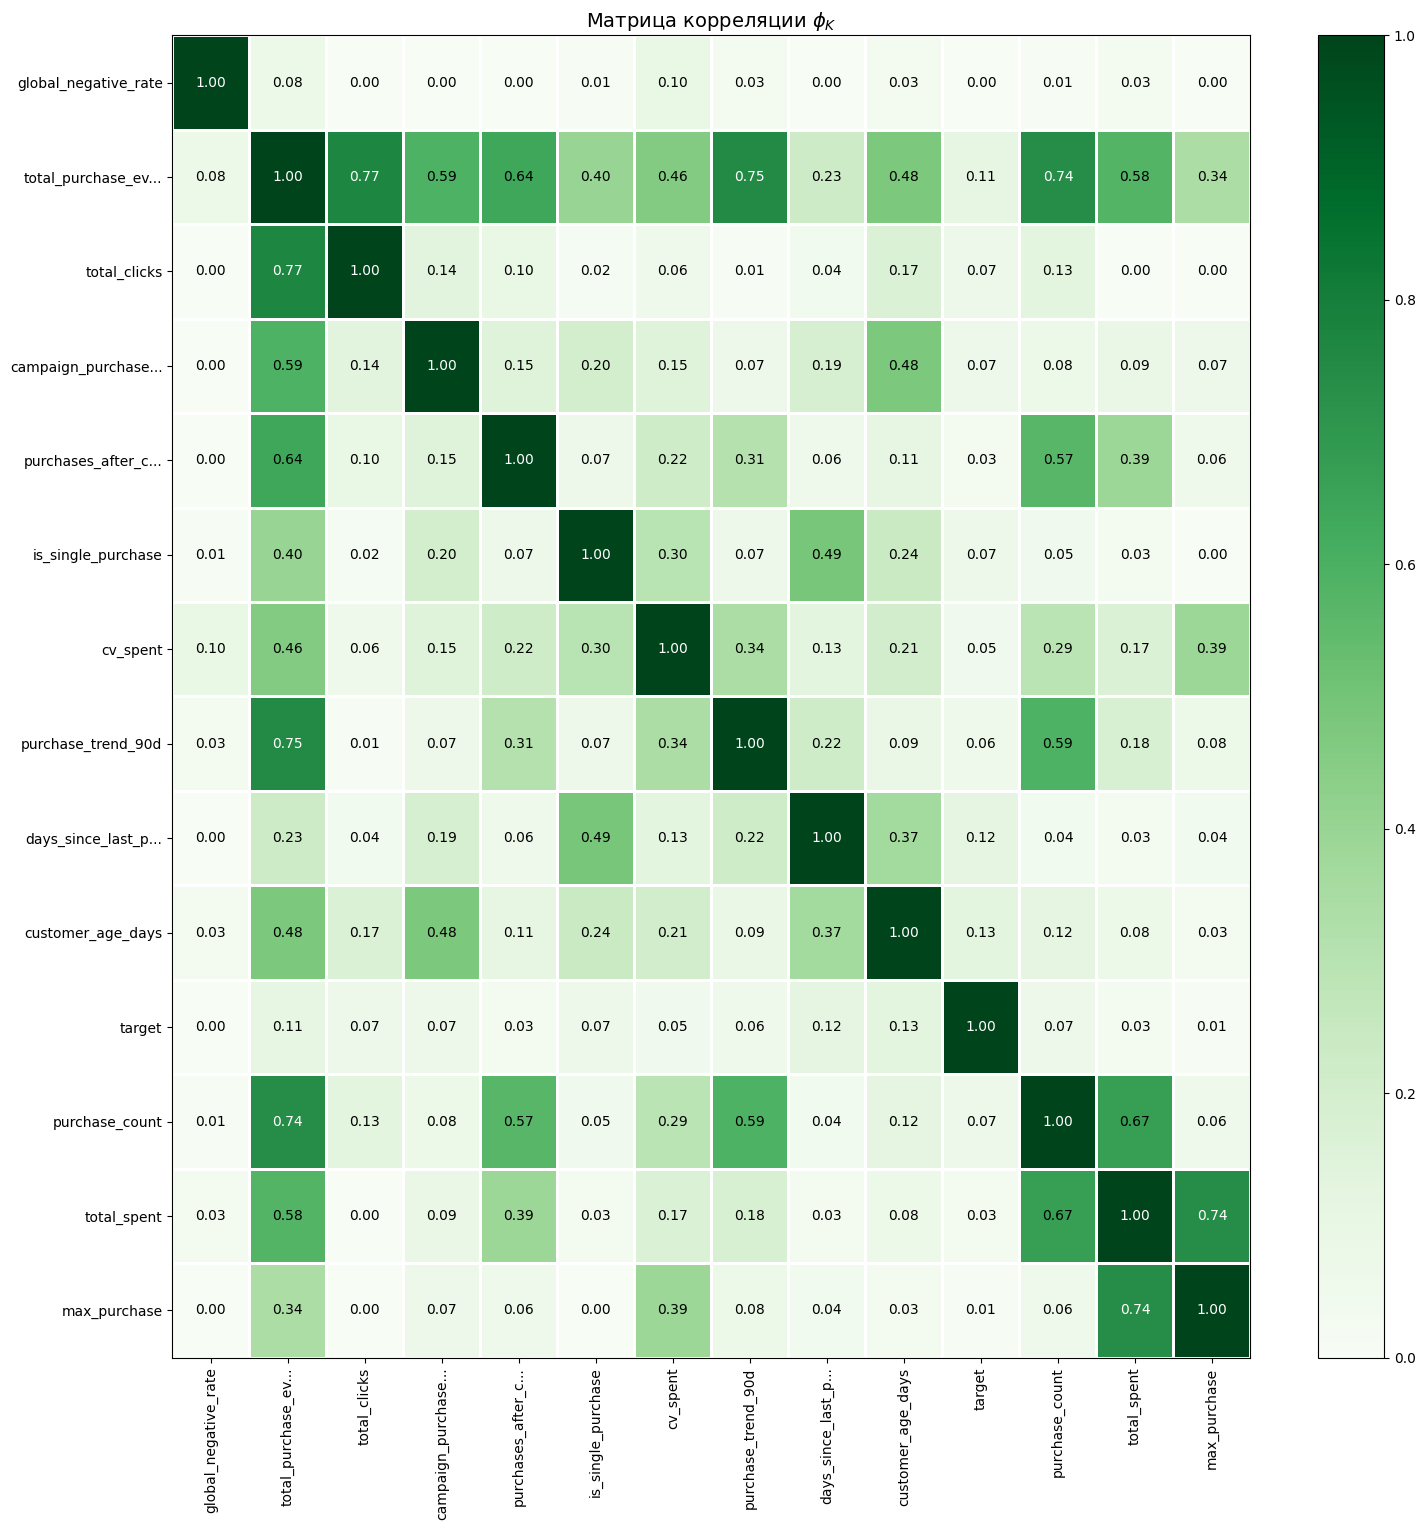

Мультиколлинеарность между парами входных признаков отсутствует
CPU times: total: 484 ms
Wall time: 989 ms


In [103]:
%%time
# рассчитаем матрицу корреляции Phik
# присвоем переменной correlated_pairs датафрейм с парами признаков и их корреляцией Фи
# присвоем переменной threshold пороговое значение
# присвоем переменной interval_cols список названий всех столбцов с числовым типом данных в обрабатываемом датафрейме
# присвоем переменной phi_k_with_target корреляции признаков с целевой переменной
result = phik_correlation_matrix(merged_purchases_df.drop(columns=['client_id']), threshold = 0.9, output_interval_cols=True, target_col='target')

# Результаты:
correlated_pairs = result[0]  # Пары коррелирующих признаков
interval_cols = result[1]     # Список числовых столбцов
phi_k_with_target = result[2] # Корреляции признаков с целевой переменной

CPU times: total: 57.6 s
Wall time: 1min 19s


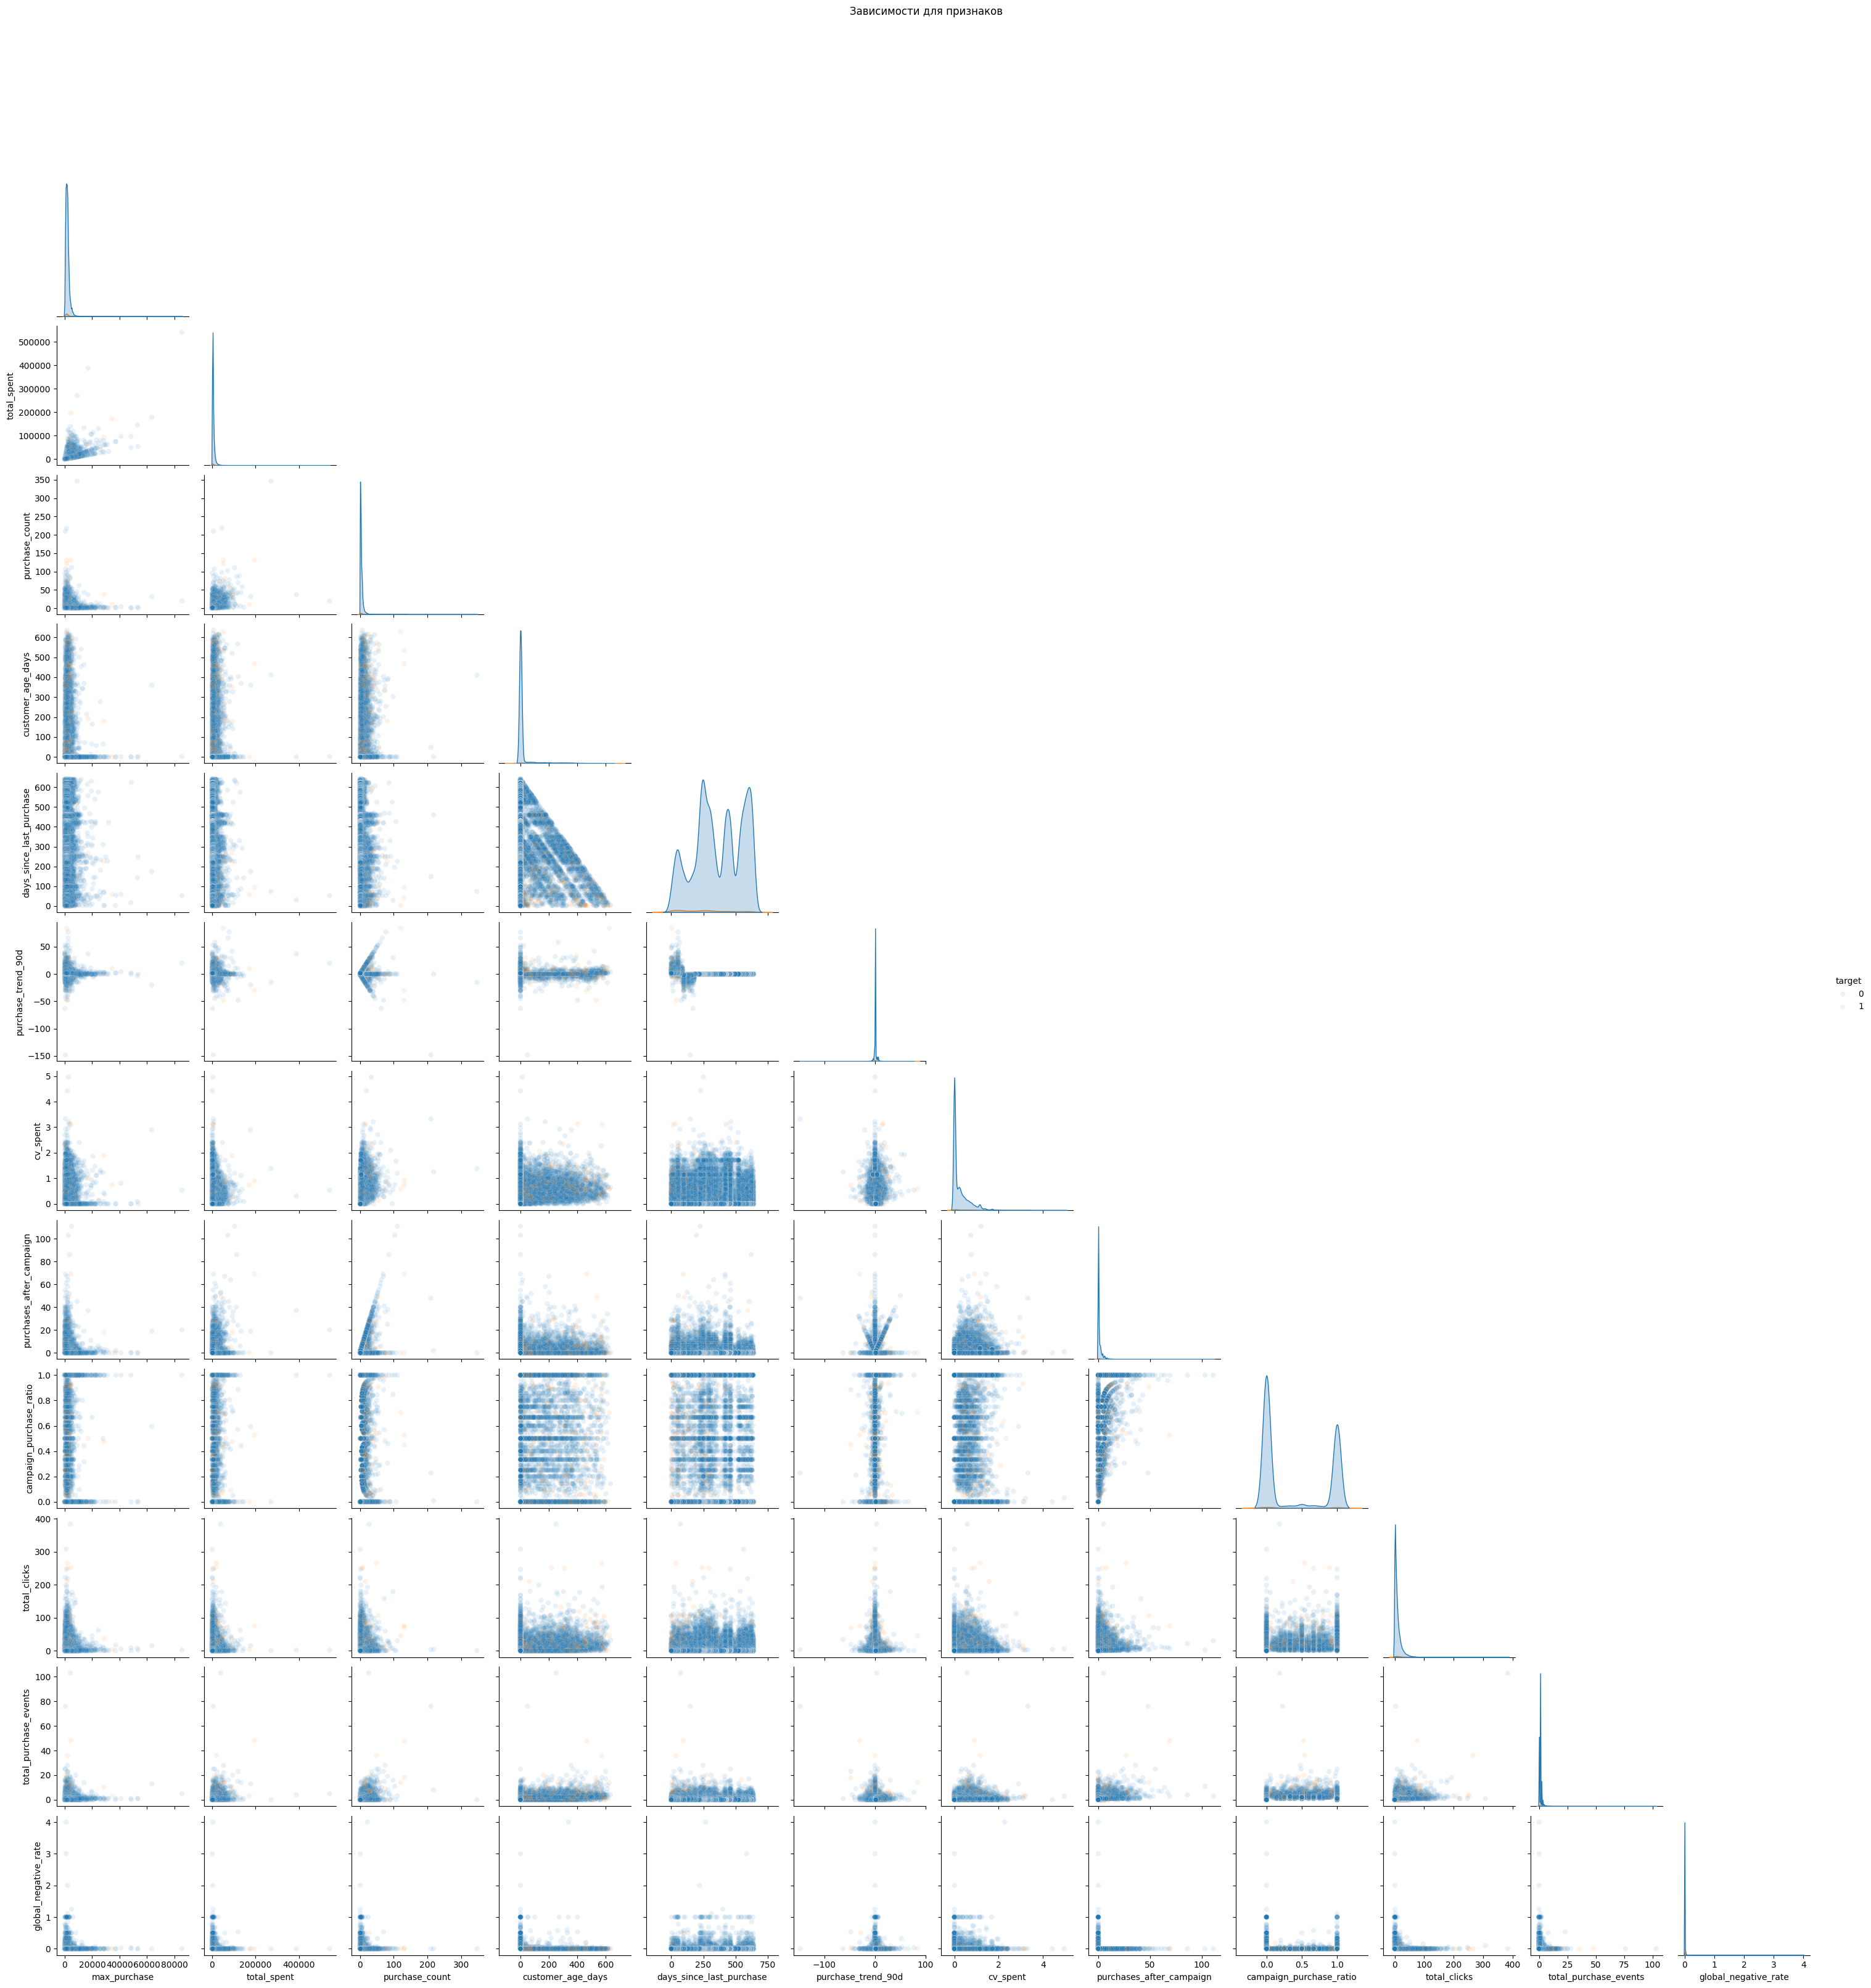

In [104]:
%%time
sns.pairplot(
    data=merged_purchases_df,
    hue='target',        # группировка по классам
    corner=True,         # не рисуем дублирующие графики
    plot_kws={'alpha': 0.1}
).fig.suptitle(
    'Зависимости для признаков',
    y=1.08
);

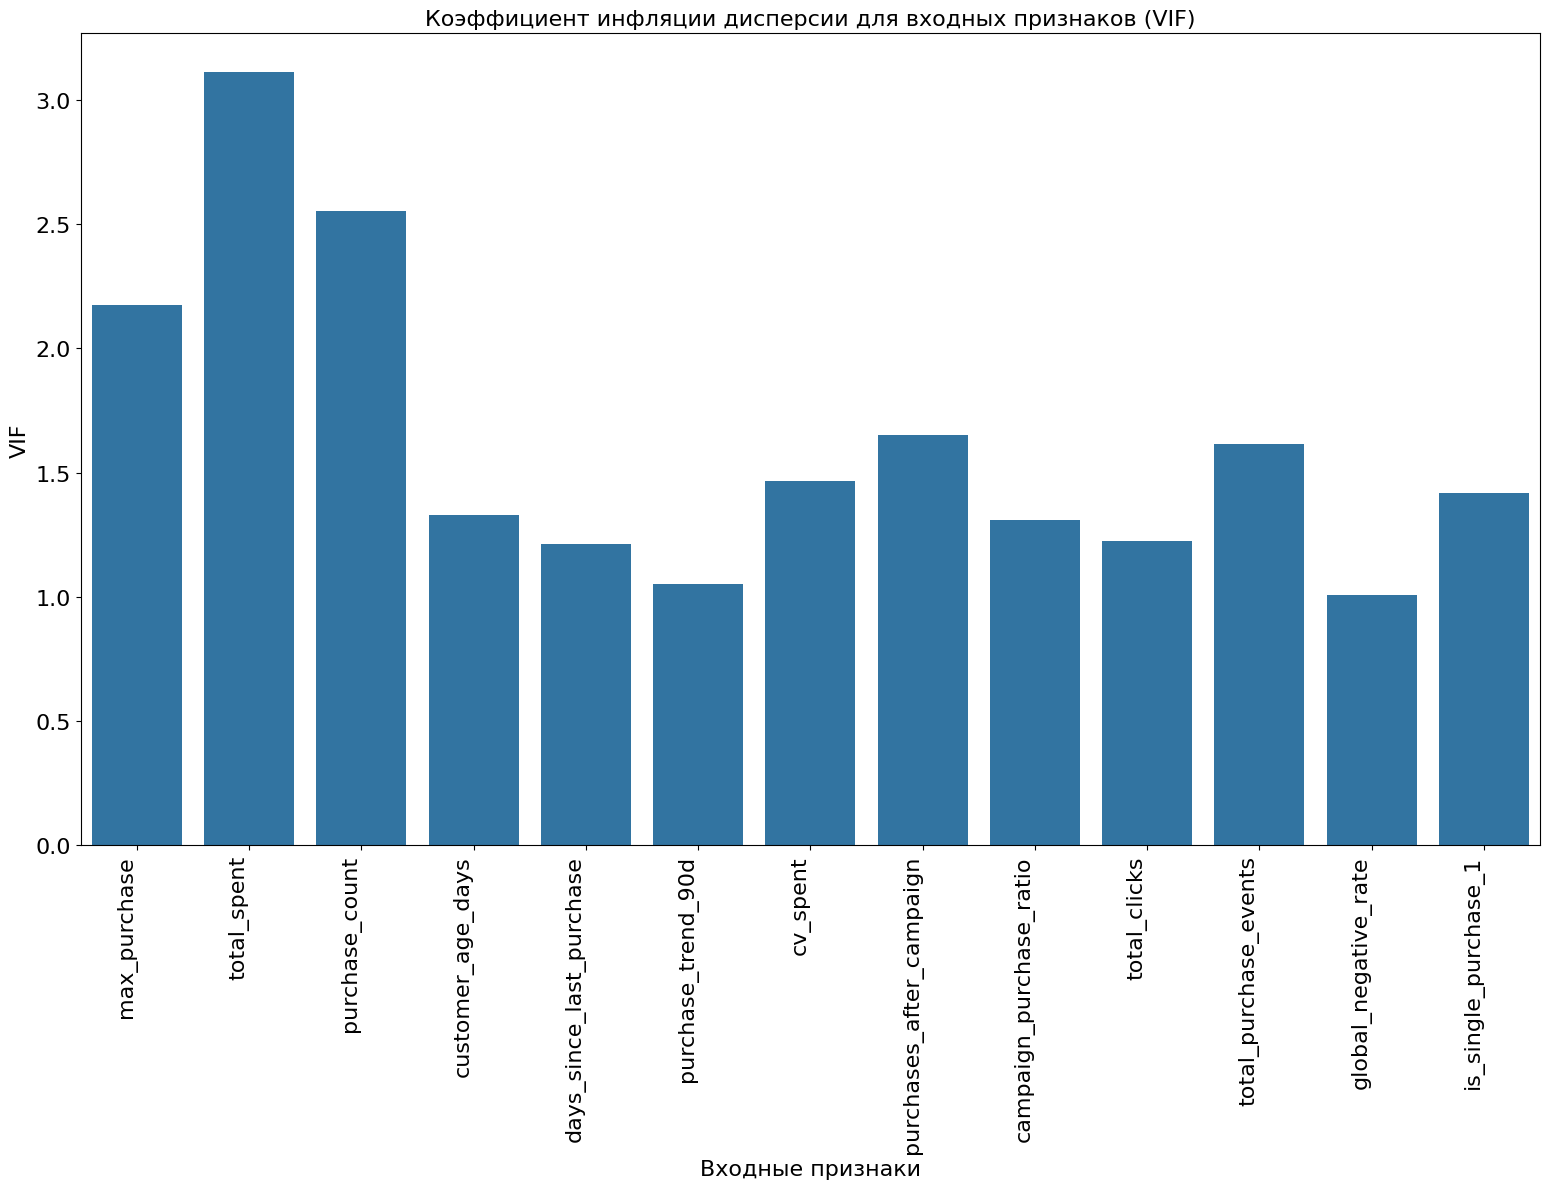

In [105]:
# используем созданную функцию рассчета VIF
vif(merged_purchases_df.drop(columns=['client_id', 'target']), font_size=16)

In [106]:
# Устанавливаем client_id в качестве индекса
merged_purchases_df = merged_purchases_df.set_index('client_id')

# Проверяем результат
display(merged_purchases_df.head())  # Выводим первые строки для проверки
print("\nИнформация о датафрейме после изменения:")
merged_purchases_df.info()  # Показываем информацию о структуре

max_purchase  total_spent  purchase_count target  \
client_id                                                               
1515915625468060902        1999.0       6993.0               7      0   
1515915625468061003        3499.0      16235.0               7      1   
1515915625468061099         299.0        299.0               1      0   
1515915625468061100        1049.0       2098.0               2      0   
1515915625468061170        2699.0      33601.0              19      0   

                     customer_age_days  days_since_last_purchase  \
client_id                                                          
1515915625468060902                  0                       630   
1515915625468061003                  0                       408   
1515915625468061099                  0                       640   
1515915625468061100                  0                         6   
1515915625468061170                 83                       244   

                     purchase_trend_90d  cv_spent is_single_purchase  \
client_id                                                              
1515915625468060902                 0.0  0.802884                  0   
1515915625468061003                 0.0  0.241667                  0   
1515915625468061099                 0.0  0.000000                  1   
1515915625468061100                 2.0  0.000000                  0   
1515915625468061170                 0.0  0.454020                  0   

                     purchases_after_campaign  campaign_purchase_ratio  \
client_id                                                                
1515915625468060902                       0.0                 0.000000   
1515915625468061003                       0.0                 0.000000   
1515915625468061099                       0.0                 0.000000   
1515915625468061100                       0.0                 1.000000   
1515915625468061170                       7.0                 0.368421   

                     total_clicks  total_purchase_events  global_negative_rate  
client_id                                                                       
1515915625468060902          10.0                    5.0              0.007937  
1515915625468061003           6.0                    1.0              0.000000  
1515915625468061099           8.0                    0.0              0.009302  
1515915625468061100           1.0                    1.0              0.007491  
1515915625468061170          16.0                    3.0              0.000000


Информация о датафрейме после изменения:
<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   max_purchase              49849 non-null  float64
 1   total_spent               49849 non-null  float64
 2   purchase_count            49849 non-null  int64  
 3   target                    49849 non-null  object 
 4   customer_age_days         49849 non-null  int64  
 5   days_since_last_purchase  49849 non-null  int64  
 6   purchase_trend_90d        49849 non-null  float64
 7   cv_spent                  49849 non-null  float64
 8   is_single_purchase        49849 non-null  object 
 9   purchases_after_campaign  49849 non-null  float32
 10  campaign_purchase_ratio   49849 non-null  float32
 11  total_clicks              49849 non-null  float32
 12  total_purchase_events     49849 non-null  float

# Моделирование

## Подготовка данных к моделированию

Делим данные на тренировочную, валидационную и тестовую выборки

In [107]:
# Разбиваем данные на обучающую+валидационную и тестовую выборки
train_valid_idx, test_idx = train_test_split(
    merged_purchases_df.index,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=merged_purchases_df['target']  # Стратификация только по target
)

train_valid_df = merged_purchases_df.loc[train_valid_idx]
test_df = merged_purchases_df.loc[test_idx]

# Разбиваем обучающую+валидационную выборку на обучающую и валидационную
train_idx, valid_idx = train_test_split(
    train_valid_df.index,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=train_valid_df['target']  # Стратификация только по target
)

train_df = merged_purchases_df.loc[train_idx]
valid_df = merged_purchases_df.loc[valid_idx]

## Обучение моделей

### LogisticRegression (RandomUnderSampler+SMOTETomek)

In [108]:
# Подготовка данных
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']
X_valid = valid_df.drop(columns=['target'])
y_valid = valid_df['target']
X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

In [109]:
# используем LabelEncoder для кодирования целевого признака
# инициализируем LabelEncoder
le = LabelEncoder()
# обучаем LabelEncoder на тренировочной выборке
y_train = le.fit_transform(y_train)
# кодируем целевой признак тестовой выборки
y_valid = le.transform(y_valid)
# кодируем целевой признак тестовой выборки
y_test = le.transform(y_test)

In [110]:
# Выведем исходные классы в порядке их кодирования
print(le.classes_)

['0' '1']


In [111]:
merged_purchases_df.columns

Index(['max_purchase', 'total_spent', 'purchase_count', 'target',
       'customer_age_days', 'days_since_last_purchase', 'purchase_trend_90d',
       'cv_spent', 'is_single_purchase', 'purchases_after_campaign',
       'campaign_purchase_ratio', 'total_clicks', 'total_purchase_events',
       'global_negative_rate'],
      dtype='object')

In [112]:
# создаем списки с названиями признаков
ohe_columns = ['is_single_purchase']
num_columns = ['max_purchase', 'total_spent', 'purchase_count',
               'customer_age_days', 'days_since_last_purchase',
               'purchase_trend_90d', 'cv_spent', 'purchases_after_campaign',
               'campaign_purchase_ratio', 'total_clicks', 'total_purchase_events',
               'global_negative_rate'
                ] 

In [113]:
# создаем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
        ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [114]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

In [115]:
# Параметры для RandomizedSearchCV
param_dist = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    'classifier__C': np.logspace(-3, 3, 7),  # 0.001 до 1000
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__solver': ['saga'],  # Единственный solver, поддерживающий все penalties
    'classifier__l1_ratio': [0, 0.3, 0.5, 0.7, 1],  # Для elasticnet
    #'classifier__class_weight': [None, 'balanced', {0: 1, 1: 5}], # либо его либо RandomUnderSampler+SMOTETomek
    'classifier__max_iter': [500, 1000, 1500]
}

# Настройка кросс-валидации
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=3,
    refit=True,
    return_train_score=True
)

# индексы категориальных признаков
categorical_features = [X_train.columns.get_loc('is_single_purchase')]

# 1. Сначала undersampler
undersampler = RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_STATE)

# 2. Используем SMOTENC (NC = Numerical + Categorical)
smote = SMOTENC(categorical_features=categorical_features, random_state=RANDOM_STATE)

# 3. TomekLinks для очистки границ
tomek = TomekLinks()

# Полный пайплайн балансировки
pipeline = ImbPipeline([
    ('undersampler', undersampler),
    ('smote', smote),
    ('tomek', tomek)
])

# Применяем пайплайн
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)
X_train_balanced['is_single_purchase'] = X_train_balanced['is_single_purchase'].astype(int).astype(str)

# Проверка баланса классов
print("Original class distribution:", np.bincount(y_train))
print("After SMOTETomek:", np.bincount(y_train_balanced))

# Запуск поиска
random_search.fit(X_train_balanced, y_train_balanced)

# Вывод результатов кросс-валидации
cv_results = pd.DataFrame(random_search.cv_results_)
print("\nРезультаты кросс-валидации:")
display(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(5))

# Лучшие параметры
print("\nЛучшие параметры:", random_search.best_params_)
print(f"Лучший ROC-AUC на кросс-валидации: {random_search.best_score_:.4f}")
best_model = random_search.best_estimator_

### Оценка на валидационных данных
y_valid_pred = best_model.predict(X_valid)
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]

print("\nValidation Classification Report:")
print(classification_report(y_valid, y_valid_pred))
print(f"Validation ROC-AUC: {roc_auc_score(y_valid, y_valid_proba):.4f}")

# Получение коэффициентов модели (важность признаков)
coefs = best_model.named_steps['classifier'].coef_[0]
feature_names = X_train.columns

Original class distribution: [29332   577]
After SMOTETomek: [2885 2701]
Fitting 2 folds for each of 50 candidates, totalling 100 fits

Результаты кросс-валидации:


C:\Users\shaht\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


params  mean_test_score  \
36  {'preprocessor__num': StandardScaler(), 'class...         0.721775   
48  {'preprocessor__num': StandardScaler(), 'class...         0.721775   
6   {'preprocessor__num': StandardScaler(), 'class...         0.721712   
11  {'preprocessor__num': StandardScaler(), 'class...         0.721712   
12  {'preprocessor__num': StandardScaler(), 'class...         0.721527   

    std_test_score  rank_test_score  
36        0.003754                1  
48        0.003754                1  
6         0.003320                3  
11        0.003320                3  
12        0.003141                5


Лучшие параметры: {'preprocessor__num': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__max_iter': 500, 'classifier__l1_ratio': 0.5, 'classifier__C': 0.01}
Лучший ROC-AUC на кросс-валидации: 0.7218

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83      9778
           1       0.04      0.64      0.08       192

    accuracy                           0.71      9970
   macro avg       0.52      0.68      0.45      9970
weighted avg       0.97      0.71      0.81      9970

Validation ROC-AUC: 0.7250


Длина feature_names: 13
Длина coefs: 13


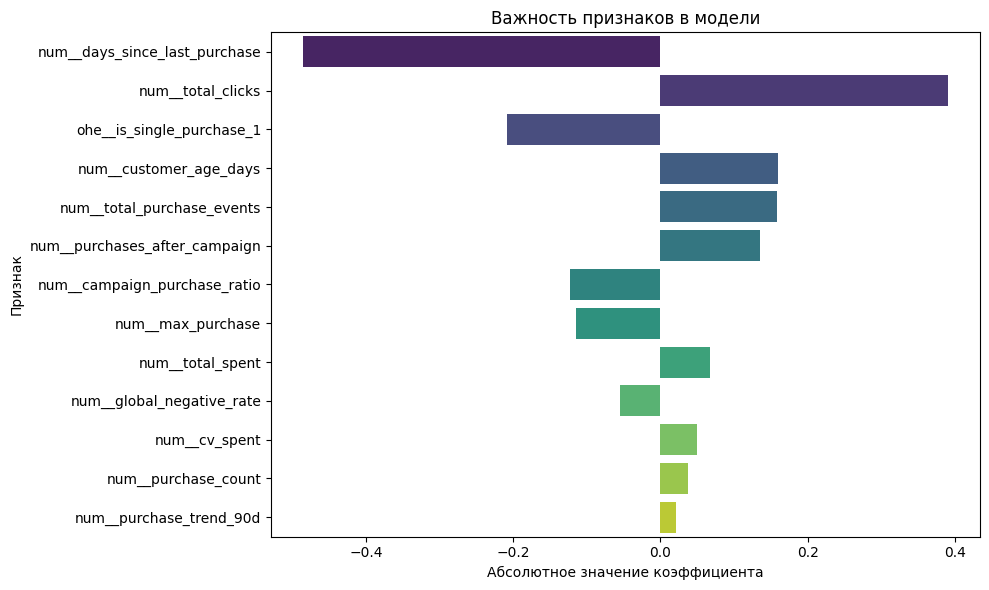

In [116]:
# Получаем трансформированные признаки и их названия
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Проверка длины
print("Длина feature_names:", len(feature_names))
print("Длина coefs:", len(coefs))

# Создаём DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Abs_Coefficient': np.abs(coefs)
}).sort_values('Abs_Coefficient', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков в модели')
plt.xlabel('Абсолютное значение коэффициента')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

In [117]:
### Оценка на тестовых данных
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))
#print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
#print(f"Validation F1-Score: {f1_score(y_test, y_test_pred):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      9778
           1       0.04      0.65      0.08       192

    accuracy                           0.71      9970
   macro avg       0.52      0.68      0.46      9970
weighted avg       0.97      0.71      0.82      9970

ROC-AUC: 0.7338


In [118]:
# Исходные вероятности для класса 1
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Перебираем разные пороги от 0.1 до 0.9
thresholds = np.linspace(0.1, 0.9, 9)

for threshold in thresholds:
    # Применяем порог: если вероятность > threshold → класс 1, иначе 0
    y_pred_threshold = (y_test_proba > threshold).astype(int)

    # Считаем precision для класса 1
    precision = precision_score(y_test, y_pred_threshold, pos_label=1)
    recall = recall_score(y_test, y_pred_threshold, pos_label=1)
    f1 = f1_score(y_test, y_pred_threshold, pos_label=1)

    print(f"\nThreshold: {threshold:.2f}")
    print(classification_report(y_test, y_pred_threshold))
    print(f"Precision for class 1: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


Threshold: 0.10
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      9778
           1       0.02      1.00      0.04       192

    accuracy                           0.02      9970
   macro avg       0.51      0.50      0.02      9970
weighted avg       0.98      0.02      0.00      9970

Precision for class 1: 0.0193, Recall: 1.0000, F1: 0.0378

Threshold: 0.20
              precision    recall  f1-score   support

           0       0.99      0.05      0.09      9778
           1       0.02      0.98      0.04       192

    accuracy                           0.06      9970
   macro avg       0.51      0.52      0.06      9970
weighted avg       0.97      0.06      0.09      9970

Precision for class 1: 0.0199, Recall: 0.9844, F1: 0.0390

Threshold: 0.30
              precision    recall  f1-score   support

           0       0.99      0.27      0.42      9778
           1       0.02      0.92      0.05       192

    accuracy   

In [119]:
### Оценка на всех данных
y_pred = best_model.predict(merged_purchases_df.drop(columns=['target']))
y_proba = best_model.predict_proba(merged_purchases_df.drop(columns=['target']))[:, 1]
y = le.transform(merged_purchases_df['target'])

classification_report_final = classification_report(y, y_pred)
roc_auc_score_final = roc_auc_score(y, y_proba)
print("\nClassification Report:")
print(classification_report(y, y_pred))
print(f"ROC-AUC: {roc_auc_score(y, y_proba):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     48888
           1       0.04      0.60      0.07       961

    accuracy                           0.71     49849
   macro avg       0.51      0.66      0.45     49849
weighted avg       0.97      0.71      0.81     49849

ROC-AUC: 0.7131


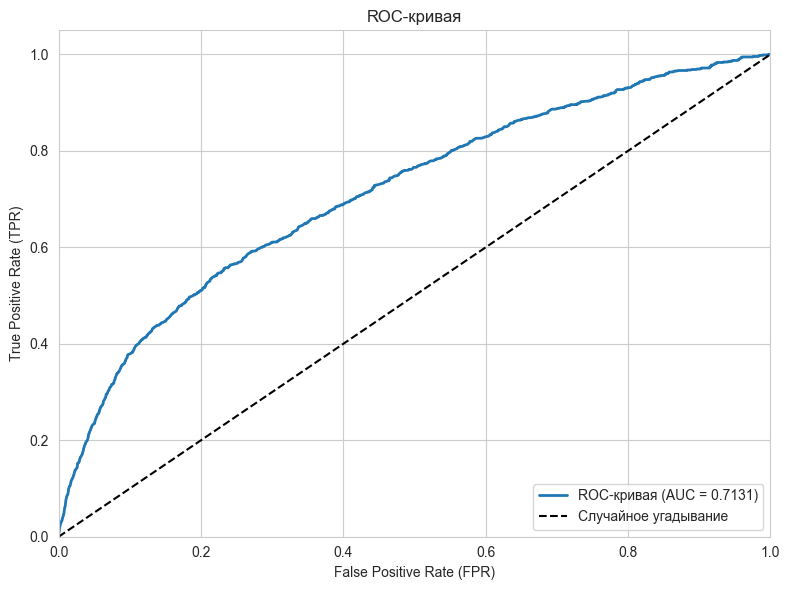

In [120]:
y = le.transform(merged_purchases_df['target'])

# Получаем FPR, TPR и пороги
fpr, tpr, thresholds = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)

# Строим график с помощью seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC-кривая (AUC = {roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [121]:
# Предсказываем вероятности для всего датасета
probabilities = best_model.predict_proba(merged_purchases_df.drop(columns=['target']))[:, 1]

# Создаем новый датафрейм с client_id (из индекса) и вероятностями
client_probabilities = pd.DataFrame({
    'client_id': merged_purchases_df.index,
    'probability': probabilities
})

In [122]:
client_probabilities.head()

client_id  probability
0  1515915625468060902     0.368312
1  1515915625468061003     0.391517
2  1515915625468061099     0.220703
3  1515915625468061100     0.554892
4  1515915625468061170     0.700665

### LogisticRegression (classifier_class_weight)

In [123]:
# Подготовка данных
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']
X_valid = valid_df.drop(columns=['target'])
y_valid = valid_df['target']
X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

In [124]:
# используем LabelEncoder для кодирования целевого признака
# инициализируем LabelEncoder
le = LabelEncoder()
# обучаем LabelEncoder на тренировочной выборке
y_train = le.fit_transform(y_train)
# кодируем целевой признак тестовой выборки
y_valid = le.transform(y_valid)
# кодируем целевой признак тестовой выборки
y_test = le.transform(y_test)

In [125]:
# Выведем исходные классы в порядке их кодирования
print(le.classes_)

['0' '1']


In [126]:
merged_purchases_df.columns

Index(['max_purchase', 'total_spent', 'purchase_count', 'target',
       'customer_age_days', 'days_since_last_purchase', 'purchase_trend_90d',
       'cv_spent', 'is_single_purchase', 'purchases_after_campaign',
       'campaign_purchase_ratio', 'total_clicks', 'total_purchase_events',
       'global_negative_rate'],
      dtype='object')

In [127]:
# создаем списки с названиями признаков
ohe_columns = ['is_single_purchase']
num_columns = ['max_purchase', 'total_spent', 'purchase_count',
               'customer_age_days', 'days_since_last_purchase',
               'purchase_trend_90d', 'cv_spent', 'purchases_after_campaign',
               'campaign_purchase_ratio', 'total_clicks', 'total_purchase_events',
               'global_negative_rate'
                ] 

In [128]:
# создаем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
        ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [129]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

In [130]:
# Параметры для RandomizedSearchCV
param_dist = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    'classifier__C': np.logspace(-3, 3, 7),  # 0.001 до 1000
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],
    'classifier__solver': ['saga'],  # Единственный solver, поддерживающий все penalties
    'classifier__l1_ratio': [0, 0.3, 0.5, 0.7, 1],  # Для elasticnet
    'classifier__class_weight': ['balanced', {0: 1, 1: 5}], # либо его либо RandomUnderSampler+SMOTETomek
    'classifier__max_iter': [3000]
}

# Настройка кросс-валидации
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_dist,
    n_iter=50,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=3,
    refit=True,
    return_train_score=True
)

# Балансировка классов (применяем только к обучающим данным)
#undersampler = RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_STATE)
#smote_tomek = SMOTETomek(random_state=RANDOM_STATE)

#X_temp, y_temp = undersampler.fit_resample(X_train, y_train)
#X_train_balanced, y_train_balanced = smote_tomek.fit_resample(X_temp, y_temp)

# Проверка баланса классов
#print("Original class distribution:", np.bincount(y_train))
#print("After undersampling:", np.bincount(y_temp))
#print("After SMOTETomek:", np.bincount(y_train_balanced))

# Запуск поиска
#random_search.fit(X_train_balanced, y_train_balanced)
random_search.fit(X_train, y_train)

# Вывод результатов кросс-валидации
cv_results = pd.DataFrame(random_search.cv_results_)
print("\nРезультаты кросс-валидации:")
display(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head(5))

# Лучшие параметры
print("\nЛучшие параметры:", random_search.best_params_)
print(f"Лучший ROC-AUC на кросс-валидации: {random_search.best_score_:.4f}")
best_model = random_search.best_estimator_

### Оценка на валидационных данных
y_valid_pred = best_model.predict(X_valid)
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]

print("\nValidation Classification Report:")
print(classification_report(y_valid, y_valid_pred))
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print(f"Validation ROC-AUC: {roc_auc_score(y_valid, y_valid_proba):.4f}")
print(f"Validation F1-Score: {f1_score(y_valid, y_valid_pred):.4f}")

# Получение коэффициентов модели (важность признаков)
coefs = best_model.named_steps['classifier'].coef_[0]
feature_names = X_train.columns

Fitting 2 folds for each of 50 candidates, totalling 100 fits

Результаты кросс-валидации:


C:\Users\shaht\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


params  mean_test_score  \
34  {'preprocessor__num': StandardScaler(), 'class...         0.696070   
13  {'preprocessor__num': StandardScaler(), 'class...         0.696070   
41  {'preprocessor__num': StandardScaler(), 'class...         0.695877   
3   {'preprocessor__num': StandardScaler(), 'class...         0.694784   
24  {'preprocessor__num': StandardScaler(), 'class...         0.694591   

    std_test_score  rank_test_score  
34        0.007541                1  
13        0.007541                1  
41        0.009414                3  
3         0.009099                4  
24        0.009282                5


Лучшие параметры: {'preprocessor__num': StandardScaler(), 'classifier__solver': 'saga', 'classifier__penalty': 'l1', 'classifier__max_iter': 3000, 'classifier__l1_ratio': 0, 'classifier__class_weight': 'balanced', 'classifier__C': 0.01}
Лучший ROC-AUC на кросс-валидации: 0.6961

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.70      0.82      9778
           1       0.04      0.65      0.08       192

    accuracy                           0.70      9970
   macro avg       0.52      0.67      0.45      9970
weighted avg       0.97      0.70      0.80      9970

Accuracy: 0.6954864593781344
Validation ROC-AUC: 0.7251
Validation F1-Score: 0.0761


Длина feature_names: 13
Длина coefs: 13


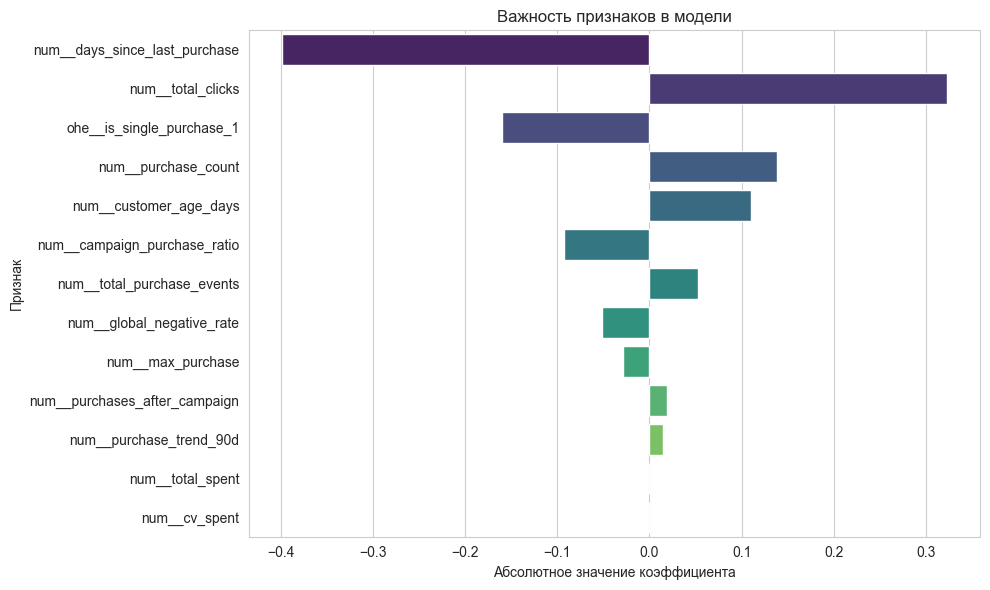

In [131]:
# Получаем трансформированные признаки и их названия
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Проверка длины
print("Длина feature_names:", len(feature_names))
print("Длина coefs:", len(coefs))

# Создаём DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs,
    'Abs_Coefficient': np.abs(coefs)
}).sort_values('Abs_Coefficient', ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков в модели')
plt.xlabel('Абсолютное значение коэффициента')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

### DecisionTreeClassifier

In [132]:
# Подготовка данных
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']
X_valid = valid_df.drop(columns=['target'])
y_valid = valid_df['target']
X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

In [133]:
# используем LabelEncoder для кодирования целевого признака
# инициализируем LabelEncoder
le = LabelEncoder()
# обучаем LabelEncoder на тренировочной выборке
y_train = le.fit_transform(y_train)
# кодируем целевой признак тестовой выборки
y_valid = le.transform(y_valid)
# кодируем целевой признак тестовой выборки
y_test = le.transform(y_test)

In [134]:
# Выведем исходные классы в порядке их кодирования
print(le.classes_)

['0' '1']


In [135]:
merged_purchases_df.columns

Index(['max_purchase', 'total_spent', 'purchase_count', 'target',
       'customer_age_days', 'days_since_last_purchase', 'purchase_trend_90d',
       'cv_spent', 'is_single_purchase', 'purchases_after_campaign',
       'campaign_purchase_ratio', 'total_clicks', 'total_purchase_events',
       'global_negative_rate'],
      dtype='object')

In [136]:
# создаем списки с названиями признаков
ohe_columns = ['is_single_purchase']
num_columns = ['max_purchase', 'total_spent', 'purchase_count',
               'customer_age_days', 'days_since_last_purchase',
               'purchase_trend_90d', 'cv_spent', 'purchases_after_campaign',
               'campaign_purchase_ratio', 'total_clicks', 'total_purchase_events',
               'global_negative_rate'
                ] 

In [137]:
# создаем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
        ('simpleImputer_after_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
    )

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
    ],
    remainder='passthrough'
)

In [138]:
# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [139]:
# Параметры для RandomizedSearchCV
param_dist = {
    'classifier__max_depth': [3, 5, 7, 10, None],          # Глубина дерева
    'classifier__min_samples_split': [2, 5, 10, 15, 20],           # Минимальное количество образцов для разделения узла
    'classifier__min_samples_leaf': [1, 2, 4, 6],             # Минимальное количество образцов в листе
    'classifier__max_features': ['sqrt', 'log2', None],    # Количество признаков для поиска лучшего разделения
    'classifier__criterion': ['gini', 'entropy']          # Критерий для разделения
    #'class_weight': [None, 'balanced', {0: 1, 1: 5}]  # Веса классов - либо его либо RandomUnderSampler+SMOTETomek
}

### Создание модели для поиска
#dt_model = DecisionTreeClassifier(
#    random_state=RANDOM_STATE
#)

### RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_dist,
    n_iter=10,  # Количество комбинаций
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,  # Использовать все ядра CPU
    random_state=RANDOM_STATE,
    verbose=3
)

# индексы категориальных признаков
categorical_features = [X_train.columns.get_loc('is_single_purchase')]

# 1. Сначала undersampler
undersampler = RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_STATE)

# 2. Используем SMOTENC (NC = Numerical + Categorical)
smote = SMOTENC(categorical_features=categorical_features, random_state=RANDOM_STATE)

# 3. TomekLinks для очистки границ
tomek = TomekLinks()

# Полный пайплайн балансировки
pipeline = ImbPipeline([
    ('undersampler', undersampler),
    ('smote', smote),
    ('tomek', tomek)
])

# Применяем пайплайн
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)
X_train_balanced['is_single_purchase'] = X_train_balanced['is_single_purchase'].astype(int).astype(str)

# Проверка баланса классов
print("Original class distribution:", np.bincount(y_train))
print("After SMOTETomek:", np.bincount(y_train_balanced))

# Запуск поиска
random_search.fit(X_train_balanced, y_train_balanced)

# Вывод результатов кросс-валидации для всех комбинаций параметров
cv_results = pd.DataFrame(random_search.cv_results_)
print("\nРезультаты кросс-валидации:")
print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score'))

# Лучшие параметры и лучший score на кросс-валидации
print(f"Лучший ROC-AUC на кросс-валидации: {random_search.best_score_:.4f}")

# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)
best_model = random_search.best_estimator_

### Оценка на валидационных данных
y_valid_pred = best_model.predict(X_valid)
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]

print("\nValidation Classification Report:")
print(classification_report(y_valid, y_valid_pred))
print("Accuracy:", accuracy_score(y_valid, y_valid_pred))
print(f"Validation ROC-AUC: {roc_auc_score(y_valid, y_valid_proba):.4f}")
print(f"Validation F1-Score: {f1_score(y_valid, y_valid_pred):.4f}")

Original class distribution: [29332   577]
After SMOTETomek: [2885 2701]
Fitting 2 folds for each of 10 candidates, totalling 20 fits

Результаты кросс-валидации:
                                              params  mean_test_score  \
5  {'classifier__min_samples_split': 20, 'classif...         0.860663   
7  {'classifier__min_samples_split': 20, 'classif...         0.855789   
1  {'classifier__min_samples_split': 20, 'classif...         0.839659   
4  {'classifier__min_samples_split': 5, 'classifi...         0.827833   
0  {'classifier__min_samples_split': 2, 'classifi...         0.825880   
2  {'classifier__min_samples_split': 2, 'classifi...         0.819763   
3  {'classifier__min_samples_split': 10, 'classif...         0.799706   
8  {'classifier__min_samples_split': 15, 'classif...         0.798394   
9  {'classifier__min_samples_split': 20, 'classif...         0.748823   
6  {'classifier__min_samples_split': 2, 'classifi...         0.732202   

   std_test_score  rank_test_scor

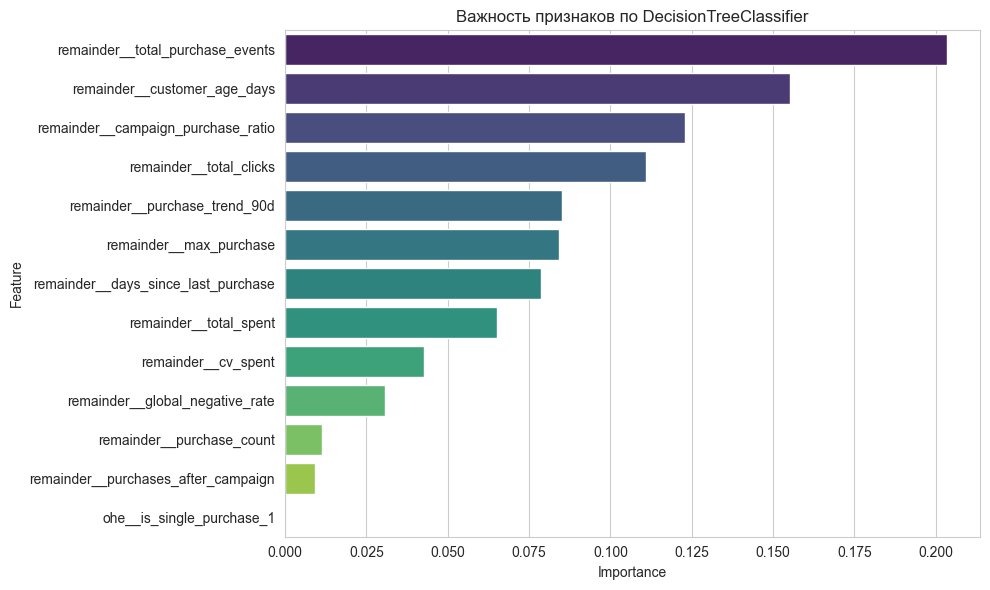

In [140]:
# Получаем важности признаков
feature_importance = best_model.named_steps['classifier'].feature_importances_

# Получаем названия признаков после предобработки
preprocessor = best_model.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# Создаём DataFrame для удобства отображения
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Сортируем по убыванию важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализируем с помощью seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков по DecisionTreeClassifier')
plt.tight_layout()
plt.show()

### CatBoostClassifier

In [141]:
# Подготовка данных
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']
X_valid = valid_df.drop(columns=['target'])
y_valid = valid_df['target']
X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

In [142]:
# используем LabelEncoder для кодирования целевого признака
# инициализируем LabelEncoder
le = LabelEncoder()
# обучаем LabelEncoder на тренировочной выборке
y_train = le.fit_transform(y_train)
# кодируем целевой признак тестовой выборки
y_valid = le.transform(y_valid)
# кодируем целевой признак тестовой выборки
y_test = le.transform(y_test)

In [143]:
# Выведем исходные классы в порядке их кодирования
print(le.classes_)

['0' '1']


In [144]:
### Параметры для RandomizedSearchCV
param_dist = {
    'iterations': [1400, 1600, 1800],         #[800, 1000, 1200],          # 3 варианта (с шагом 200)
    'learning_rate': [0.01, 0.03, 0.05],         #[0.05, 0.07, 0.1],       # 3 ключевых значения
    'depth': [6, 7, 8, 9],         #[6, 7],                          # 2 варианта (исключена глубина 8)
    'l2_leaf_reg': [0.3, 0.5, 1.0, 2.0],         #[1.0, 3.0, 5.0],           # 3 значения (мин/сред/макс)
    'random_strength': [0.3, 0.5, 1.0, 2.0],         #[0.5, 1.0, 2.0],       # 3 варианта (средние значения)
    'bagging_temperature': [0.5, 0.7, 1.0],         #[0.7, 1.0],        # 2 варианта (верхняя половина)
    'grow_policy': ['SymmetricTree'],         # 1 вариант (надежнее)
    #'loss_function': ['Logloss', 'CrossEntropy'], # лучше с 'auto_class_weights': ['Balanced']
    'bootstrap_type': ['Bayesian']
    #'sampling_frequency': ['PerTree'] # лучше с 'auto_class_weights': ['Balanced']
    #'auto_class_weights': ['Balanced'] # либо auto_class_weights либо RandomUnderSampler+SMOTETomek
}

### Создание модели для поиска
catboost = CatBoostClassifier(
    eval_metric='AUC',
    #class_weights=[1, 3], # Финальное соотношение ~1:3 после RandomUnderSampler и SMOTETomek
    early_stopping_rounds=50,
    random_seed=RANDOM_STATE,
    verbose=0,
    cat_features = ['is_single_purchase']
)

### RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost,
    param_distributions=param_dist,
    n_iter=30,  # Количество комбинаций
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,  # Использовать все ядра CPU
    random_state=RANDOM_STATE,
    verbose=3
)

# индексы категориальных признаков
categorical_features = [X_train.columns.get_loc('is_single_purchase')]

# 1. Сначала undersampler
undersampler = RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_STATE)

# 2. Используем SMOTENC (NC = Numerical + Categorical)
smote = SMOTENC(categorical_features=categorical_features, random_state=RANDOM_STATE)

# 3. TomekLinks для очистки границ
tomek = TomekLinks()

# Полный пайплайн балансировки
pipeline = ImbPipeline([
    ('undersampler', undersampler),
    ('smote', smote),
    ('tomek', tomek)
])

# Применяем пайплайн
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)
X_train_balanced['is_single_purchase'] = X_train_balanced['is_single_purchase'].astype(int).astype(str)

# Проверка баланса классов
print("Original class distribution:", np.bincount(y_train))
print("After SMOTETomek:", np.bincount(y_train_balanced))

# Запуск поиска
random_search.fit(X_train_balanced, y_train_balanced)

# Вывод результатов кросс-валидации для всех комбинаций параметров
cv_results = pd.DataFrame(random_search.cv_results_)
print("\nРезультаты кросс-валидации:")
print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head())

# Лучшие параметры и лучший score на кросс-валидации
print(f"Лучший ROC-AUC на кросс-валидации: {random_search.best_score_:.4f}")

# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)
best_model = random_search.best_estimator_

### Оценка на валидационных данных
y_valid_pred = best_model.predict(X_valid)
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]

print("\nValid Classification Report:")
print(classification_report(y_valid, y_valid_pred))
print(f"Validation ROC-AUC: {roc_auc_score(y_valid, y_valid_proba):.4f}")

Original class distribution: [29332   577]
After SMOTETomek: [2885 2701]
Fitting 2 folds for each of 30 candidates, totalling 60 fits

Результаты кросс-валидации:
                                               params  mean_test_score  \
16  {'random_strength': 0.5, 'learning_rate': 0.01...         0.945823   
20  {'random_strength': 0.3, 'learning_rate': 0.05...         0.945710   
8   {'random_strength': 0.3, 'learning_rate': 0.03...         0.945626   
5   {'random_strength': 2.0, 'learning_rate': 0.03...         0.945053   
27  {'random_strength': 0.5, 'learning_rate': 0.05...         0.944911   

    std_test_score  rank_test_score  
16        0.002483                1  
20        0.001520                2  
8         0.002639                3  
5         0.002599                4  
27        0.002564                5  
Лучший ROC-AUC на кросс-валидации: 0.9458
Лучшие параметры: {'random_strength': 0.5, 'learning_rate': 0.01, 'l2_leaf_reg': 0.3, 'iterations': 1800, 'grow_policy': '

In [145]:
### Оценка на тестовых данных
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_test_proba):.4f}")


Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      9778
           1       0.08      0.29      0.13       192

    accuracy                           0.92      9970
   macro avg       0.53      0.61      0.54      9970
weighted avg       0.97      0.92      0.94      9970

Test ROC-AUC: 0.7147


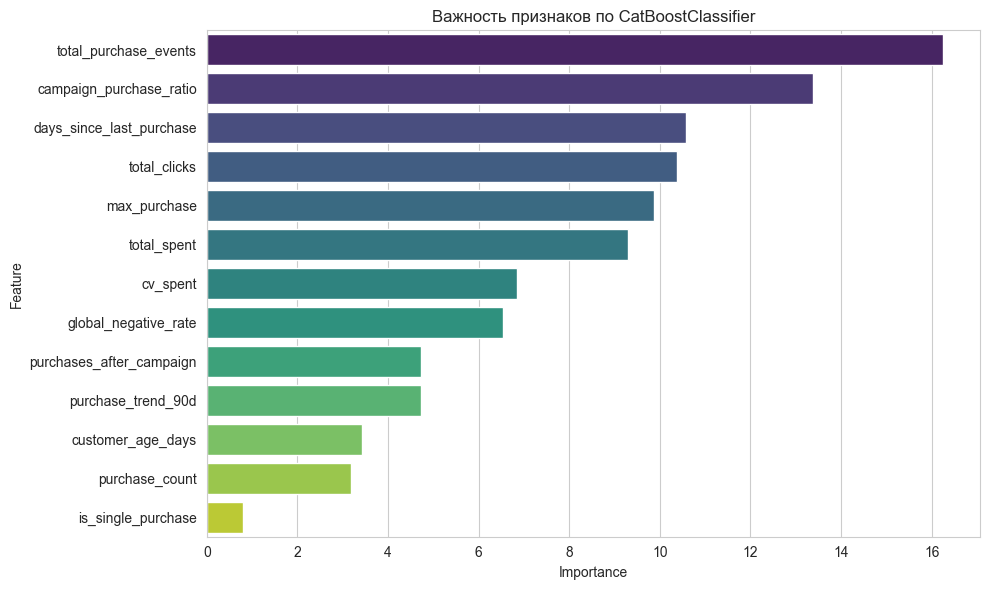

In [146]:
# Получаем список всех признаков, на которых обучалась модель
model_features = best_model.feature_names_

# Получаем важности признаков
feature_importance = best_model.get_feature_importance()

# Создаём DataFrame для удобства отображения
importance_df = pd.DataFrame({
    'Feature': model_features,
    'Importance': feature_importance
})

# Сортируем по убыванию важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализируем с помощью seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков по CatBoostClassifier')
plt.tight_layout()
plt.show()

In [147]:
### Оценка на всех данных
y_pred = best_model.predict(merged_purchases_df.drop(columns=['target']))
y_proba = best_model.predict_proba(merged_purchases_df.drop(columns=['target']))[:, 1]
y = le.transform(merged_purchases_df['target'])

print("\nClassification Report:")
print(classification_report(y, y_pred))
print(f"ROC-AUC: {roc_auc_score(y, y_proba):.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     48888
           1       0.16      0.64      0.26       961

    accuracy                           0.93     49849
   macro avg       0.58      0.79      0.61     49849
weighted avg       0.98      0.93      0.95     49849

ROC-AUC: 0.8598


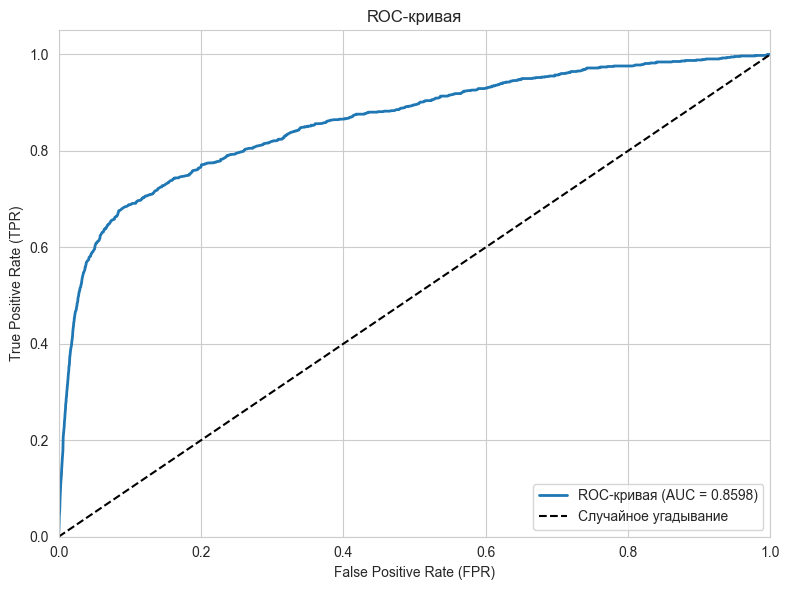

In [148]:
y = le.transform(merged_purchases_df['target'])

# Получаем FPR, TPR и пороги
fpr, tpr, thresholds = roc_curve(y, y_proba)
roc_auc = auc(fpr, tpr)

# Строим график с помощью seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.lineplot(x=fpr, y=tpr, label=f'ROC-кривая (AUC = {roc_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Случайное угадывание')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [149]:
# Исходные вероятности для класса 1
#y_proba = best_model.predict_proba(X_test)[:, 1]
y = le.transform(merged_purchases_df['target'])

# Перебираем разные пороги от 0.1 до 0.9
thresholds = np.linspace(0.1, 0.9, 9)

for threshold in thresholds:
    # Применяем порог: если вероятность > threshold → класс 1, иначе 0
    y_pred_threshold = (y_proba > threshold).astype(int)

    # Считаем precision для класса 1
    precision = precision_score(y, y_pred_threshold, pos_label=1)
    recall = recall_score(y, y_pred_threshold, pos_label=1)
    f1 = f1_score(y, y_pred_threshold, pos_label=1)

    print(f"\nThreshold: {threshold:.2f}")
    print(classification_report(y, y_pred_threshold))
    print(f"Precision for class 1: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")


Threshold: 0.10
              precision    recall  f1-score   support

           0       1.00      0.62      0.77     48888
           1       0.04      0.86      0.08       961

    accuracy                           0.63     49849
   macro avg       0.52      0.74      0.42     49849
weighted avg       0.98      0.63      0.75     49849

Precision for class 1: 0.0430, Recall: 0.8595, F1: 0.0819

Threshold: 0.20
              precision    recall  f1-score   support

           0       0.99      0.78      0.88     48888
           1       0.07      0.78      0.12       961

    accuracy                           0.78     49849
   macro avg       0.53      0.78      0.50     49849
weighted avg       0.98      0.78      0.86     49849

Precision for class 1: 0.0660, Recall: 0.7752, F1: 0.1217

Threshold: 0.30
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     48888
           1       0.09      0.72      0.16       961

    accuracy   

### LGBMClassifier

In [150]:
# Подготовка данных
X_train = train_df.drop(columns=['target'])
y_train = train_df['target']
X_valid = valid_df.drop(columns=['target'])
y_valid = valid_df['target']
X_test = test_df.drop(columns=['target'])
y_test = test_df['target']

In [151]:
# Для LGBM переводим категориальный признак в тип category
X_train['is_single_purchase'] = X_train['is_single_purchase'].astype('category')
X_valid['is_single_purchase'] = X_valid['is_single_purchase'].astype('category')
X_test['is_single_purchase'] = X_test['is_single_purchase'].astype('category')

In [152]:
# используем LabelEncoder для кодирования целевого признака
# инициализируем LabelEncoder
le = LabelEncoder()
# обучаем LabelEncoder на тренировочной выборке
y_train = le.fit_transform(y_train)
# кодируем целевой признак тестовой выборки
y_valid = le.transform(y_valid)
# кодируем целевой признак тестовой выборки
y_test = le.transform(y_test)

In [153]:
# Выведем исходные классы в порядке их кодирования
print(le.classes_)

['0' '1']


In [154]:
### Параметры для RandomizedSearchCV (оптимизированы для дисбаланса)
param_dist = {
    'n_estimators': [800, 1000, 1200],
    'learning_rate': [0.05, 0.07, 0.1],
    'max_depth': [6, 7, -1],  # -1 означает no limit
    'reg_alpha': [0.1, 1.0, 5.0],  # L1 regularization
    'reg_lambda': [0.1, 1.0, 5.0],  # L2 regularization
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_samples': [10, 20, 30],
    'scale_pos_weight': [50, 75, 100]  # Примерно ratio(0/1)*1.5-2
    #'class_weight': [None, 'balanced'] #  либо class_weight либо RandomUnderSampler+SMOTETomek
}

### Создание модели (без is_unbalance!)
lgbm = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    metric='auc',
    categorical_feature=['is_single_purchase']
)

### RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE),
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=3
)

# индексы категориальных признаков
categorical_features = [X_train.columns.get_loc('is_single_purchase')]

# 1. Сначала undersampler
undersampler = RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_STATE)

# 2. Используем SMOTENC (NC = Numerical + Categorical)
smote = SMOTENC(categorical_features=categorical_features, random_state=RANDOM_STATE)

# 3. TomekLinks для очистки границ
tomek = TomekLinks()

# Полный пайплайн балансировки
pipeline = ImbPipeline([
    ('undersampler', undersampler),
    ('smote', smote),
    ('tomek', tomek)
])

# Применяем пайплайн
X_train_balanced, y_train_balanced = pipeline.fit_resample(X_train, y_train)
#X_train_balanced['is_single_purchase'] = X_train_balanced['is_single_purchase'].astype(int).astype(str)

# Проверка баланса классов
print("Original class distribution:", np.bincount(y_train))
print("After SMOTETomek:", np.bincount(y_train_balanced))

# Запуск поиска
random_search.fit(X_train_balanced, y_train_balanced)

# Вывод результатов кросс-валидации для всех комбинаций параметров
cv_results = pd.DataFrame(random_search.cv_results_)
print("\nРезультаты кросс-валидации:")
print(cv_results[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score').head())

# Лучшие параметры и лучший score на кросс-валидации
print(f"Лучший ROC-AUC на кросс-валидации: {random_search.best_score_:.4f}")

# Лучшие параметры
print("Лучшие параметры:", random_search.best_params_)
best_model = random_search.best_estimator_

### Оценка на валидационных данных
y_valid_pred = best_model.predict(X_valid)
y_valid_proba = best_model.predict_proba(X_valid)[:, 1]

print("\nValidation Classification Report:")
print(classification_report(y_valid, y_valid_pred))
print(f"Validation ROC-AUC: {roc_auc_score(y_valid, y_valid_proba):.4f}")

Original class distribution: [29332   577]
After SMOTETomek: [2885 2701]
Fitting 2 folds for each of 10 candidates, totalling 20 fits


C:\Users\shaht\anaconda3\Lib\site-packages\lightgbm\basic.py:2137: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
C:\Users\shaht\anaconda3\Lib\site-packages\lightgbm\basic.py:2159: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=is_single_purchase, categorical_column=7 will be ignored. Current value: categorical_feature=is_single_purchase
[LightGBM] [Info] Number of positive: 2701, number of negative: 2885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2854
[LightGBM] [Info] Number of data points in the train set: 5586, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.483530 -> initscore=-0.065903
[LightGBM] [Info] Start training from score -0.065903

Результаты кросс-валидации:
                                              params  mean_test_score  \
6  {'subsample': 0.9, 'scale_pos_weight': 50, 're...         0.942734   
5  {'subsample': 0.8, 'scale_pos_weight': 50, 're...         0.941261   
1  {'subsample': 0.9, 'scale_pos_weig

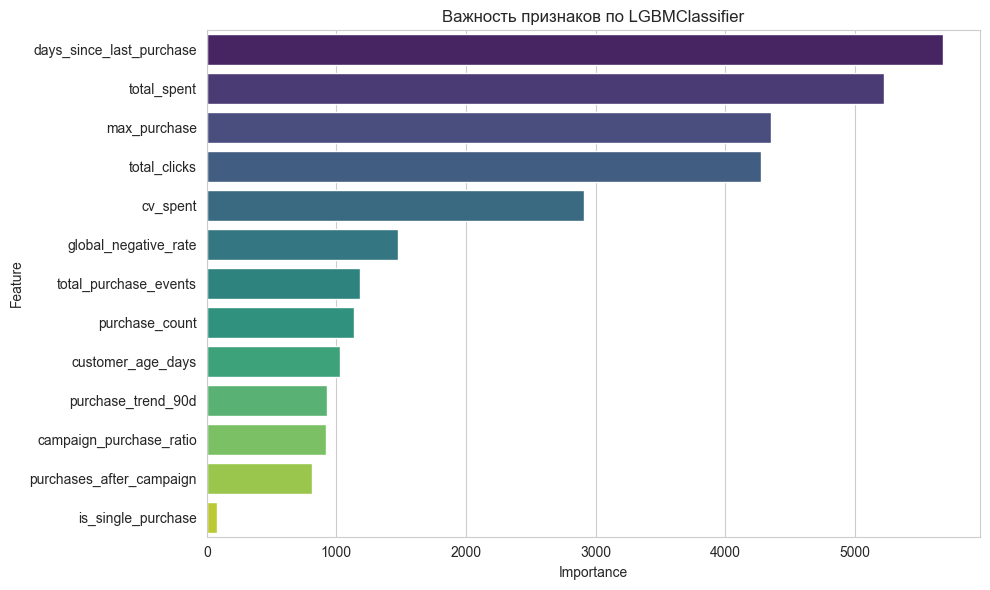

In [155]:
# Получаем список всех признаков, на которых обучалась модель
model_features = best_model.feature_name_

# Получаем важности признаков
feature_importance = best_model.feature_importances_

# Создаём DataFrame для удобства отображения
importance_df = pd.DataFrame({
    'Feature': model_features,
    'Importance': feature_importance
})

# Сортируем по убыванию важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Визуализируем с помощью seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Важность признаков по LGBMClassifier')
plt.tight_layout()
plt.show()

# Итоговый вывод

Можно выделить две модели, которые показали себя наилучшим образом: `LogisticRegression (RandomUnderSampler+SMOTETomek)` и `CatBoostClassifier`. Правда `CatBoostClassifier` на тренировочных данных сильно переобучилась и на всех данных дает завышенные метрики. При этом на тестовой выборке модель `CatBoostClassifier` ни чуть не уступает модели `LogisticRegression (RandomUnderSampler+SMOTETomek)` по метирке ROC-AUC. При этом модель `LogisticRegression (RandomUnderSampler+SMOTETomek)` лучше подстроилась под дисбаланс классов, так как RECALL для обоих классов на одном уровне, нежели чем модель `CatBoostClassifier`, которая имеет бОльший RECALL для превалирующего класса. Учитывая результаты тестирования и тот факт, что `LogisticRegression` значительно более простая модель, то предпочтение отдается ей. 

In [156]:
print('Метрики LogisticRegression на всех данных:')
print(classification_report_final)
print(f'ROC-AUC: {roc_auc_score_final:.4f}')

Метрики LogisticRegression на всех данных:
              precision    recall  f1-score   support

           0       0.99      0.71      0.83     48888
           1       0.04      0.60      0.07       961

    accuracy                           0.71     49849
   macro avg       0.51      0.66      0.45     49849
weighted avg       0.97      0.71      0.81     49849

ROC-AUC: 0.7131


**Анализ Classification Report**

На всех данных размером 49849 примеров, модель показала следующие результаты в задаче бинарной классификации:

- **Класс `0`** (мажорный класс): 48888 примеров (около 98%)
- **Класс `1`** (минорный класс): 961 примера (около 2%)

Для класса `0`:
- **Precision = 0.99** — из тех, кого модель определила как `0`, 99% действительно оказались `0`. Модель почти не ошибается в этом классе.
- **Recall = 0.71** — модель находит только 71% всех реальных объектов класса `0`.
- **F1-score = 0.83** — средний баланс между precision и recall.

Для класса `1`:
- **Precision = 0.04** — из тех, кого модель определила как `1`, только 4% действительно являются `1`. То есть модель **очень часто ошибается**, предсказывая этот класс.
- **Recall = 0.60** — модель находит 60% всех реальных объектов класса `1`.
- **F1-score = 0.07** — очень низкий, что говорит о плохом общем качестве предсказаний для этого класса.

Accuracy: 0.71 (71%)

- Хотя точность кажется приемлемой, она **вводит в заблуждение** из-за несбалансированности классов.
- Модель может просто почти всегда предсказывать `0` и всё равно получать высокую accuracy.

Средние метрики:

- **Macro avg**:
  - Precision: 0.51
  - Recall: 0.66
  - F1-score: 0.45  
  Учитывает оба класса одинаково.


- **Weighted avg**:
  - Precision: 0.97
  - Recall: 0.71
  - F1-score: 0.81  
  Преобладают метрики класса `0`, так как он доминирует по количеству.

**Вывод —** Модель сильно смещена в пользу класса `0`: Хорошо определяет `0`, но почти не находит `1` без огромного количества ложных срабатываний.

В датасете `client_probabilities` представлены предсказания вероятностей покупки в течение 90 дней всех клиентов из датасета `target_df`. 

In [157]:
client_probabilities.head()

client_id  probability
0  1515915625468060902     0.368312
1  1515915625468061003     0.391517
2  1515915625468061099     0.220703
3  1515915625468061100     0.554892
4  1515915625468061170     0.700665